In [1]:
# Basics
from glob import glob # finds pathnames
import os # Miscellaneous operating system interfaces
import sys
import random
import timeit
import imp
import gc

# Processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.ndimage import label as scipy_label
from scipy.ndimage import generate_binary_structure

# Image manipulation
import skimage

# Import Mask RCNN
sys.path.append('mrcnn')  # To find local version of the library
from config import Config
# Imp import to ensure loading the correct utils package
fp, pathname, description = imp.find_module('utils',['mrcnn'])
utils = imp.load_module('utils',fp,pathname,description)
import model as modellib
import visualize
from model import log

# Plotting
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Paths
ROOT_DIR = 'C:/Users/HPDQ/Mask_RCNN/DATASET/severstal'
Train_Dir = os.path.join(ROOT_DIR, 'train_images/')
Test_Dir = os.path.join(ROOT_DIR, 'test_images/')

# Directory to save logs and trained model
MODEL_DIR = 'logs'

# Local path to trained weights file
# Trained_Weights = '../input/????.h5'

In [3]:
print (Train_Dir)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images/


In [3]:
class SteelConfig(Config):
    """Configuration for training on the steel dataset.
    Derives from the base Config class and overrides values specific
    to the steel dataset.
    """
    # Give the configuration a recognizable name
    NAME = "steel"

    # Train on 1 GPU and 1 image per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 defect classes

    # Use small images (128x128) for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our objects tend to be small 
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images have few objects.
    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7
    
    # Number of epochs
    EPOCHS = 20
    
    # Steps per epoch
    STEPS_PER_EPOCH = 100

    # validation steps per epoch
    VALIDATION_STEPS = 5
    
    # Non-maximum suppression threshold for detection, default 0.3
    DETECTION_NMS_THRESHOLD = 0.3
    
    # Non-max suppression threshold to filter RPN proposals. default 0.7
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.7
    
config = SteelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         20
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE     

In [4]:
class SteelDataset(utils.Dataset):

    def load_steel(self, dataset_dir, files):
        """Load a subset of the Steel dataset.
        
        Input:
        dataset_dir: Root directory of the dataset.
        files: filenames of images to load
        
        Creates:
        image objects:
            source: source label
            image_id: id, used filename
            path: path + filename
            rle: rle mask encoded pixels, required for mask conversion
            classes: classes for the rle masks, required for mask conversion        
        """
        # Add classes.
        self.add_class("steel", 1, "defect1")
        self.add_class("steel", 2, "defect2")
        self.add_class("steel", 3, "defect3")
        self.add_class("steel", 4, "defect4")
        
        # Load annotations CSV
        annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

        # Remove images without Encoding
        #annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        
        annotations_train_Encoded = annotations_train
        # Split ImageId_ClassId
        #ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
        #annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
        #annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]     

        for file in files:
            EncodedPixels = [annotations_train_Encoded['EncodedPixels'][annotations_train_Encoded['ImageId'] == file]]
            ClassID = (annotations_train_Encoded['ClassId'][annotations_train_Encoded['ImageId'] == file])

            self.add_image(
                source = "steel",
                image_id = file,  # use filename as a unique image id
                path = Train_Dir + '/' + file,
                rle = EncodedPixels,
                classes = ClassID)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Input:
        image_id: id of the image
        
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D int array of class IDs of the instance masks.
        """
        print(image_id)
        # If not a steel dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "steel":
            return super(self.__class__, self).load_mask(image_id)
        
        # Convert rle to single mask
        ClassIDIndex = 0
        ClassID = np.empty(0, dtype = int)
        maskarray = np.empty((256, 1600, 0), dtype = int)
        for rlelist in image_info['rle']:
            for row in rlelist:
                mask= np.zeros(1600 * 256 ,dtype=np.uint8)
                array = np.asarray([int(x) for x in row.split()])
                starts = array[0::2]-1
                lengths = array[1::2]    
                for index, start in enumerate(starts):
                    mask[int(start):int(start+lengths[index])] = 1
                mask = mask.reshape((256,1600), order='F')
                # Label mask elements
                structure = generate_binary_structure(2,2)
                labeled_array, labels = scipy_label(mask, structure)
                # Convert labeled_array elements to bitmap mask array
                for label in range(labels):
                    labelmask = np.copy(labeled_array)    
                    labelmask[labelmask != label + 1] = 0
                    if label == 0:
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    else:
                        labelmask[labelmask == label + 1] = 1
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    # Update ClassID list
                    ClassID = np.append(ClassID,int(image_info['classes'].iloc[ClassIDIndex]))
                ClassIDIndex = ClassIDIndex + 1

        # Return mask, and array of class IDs of each instance.
        return maskarray.astype(np.bool), ClassID

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "steel":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal
0
image_id  0 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//00fe04c98.jpg
image                    shape: (256, 1600, 3)        min:   38.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 0)        min:             max:             bool
class_ids                shape: (0,)                  min:             max:             int32
bbox                     shape: (0, 4)                min:             max:             int32

*** No instances to display *** 



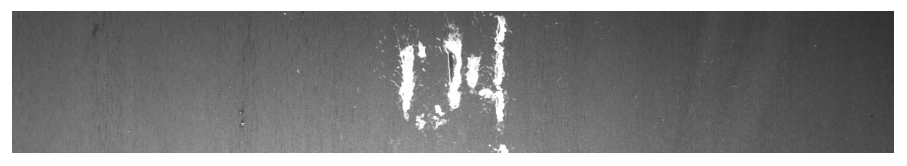

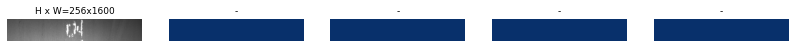

1
image_id  1 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//0a5a82b86.jpg
image                    shape: (256, 1600, 3)        min:    1.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 0)        min:             max:             bool
class_ids                shape: (0,)                  min:             max:             int32
bbox                     shape: (0, 4)                min:             max:             int32

*** No instances to display *** 



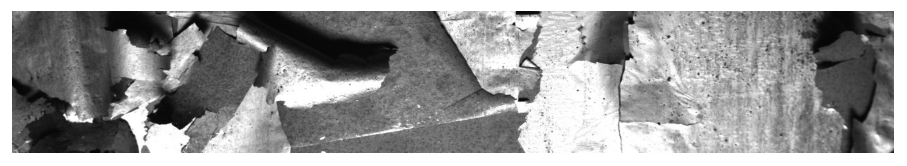

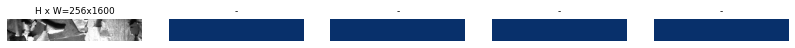

2
image_id  2 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//0a9a7a6c7.jpg
image                    shape: (256, 1600, 3)        min:    2.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 2)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    3.00000  max:    3.00000  int32
bbox                     shape: (2, 4)                min:    0.00000  max: 1239.00000  int32


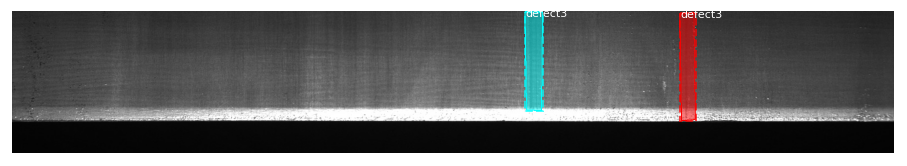

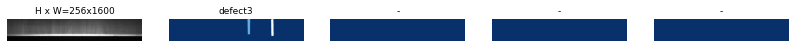

3
image_id  3 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//0a34e73df.jpg
image                    shape: (256, 1600, 3)        min:   20.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 0)        min:             max:             bool
class_ids                shape: (0,)                  min:             max:             int32
bbox                     shape: (0, 4)                min:             max:             int32

*** No instances to display *** 



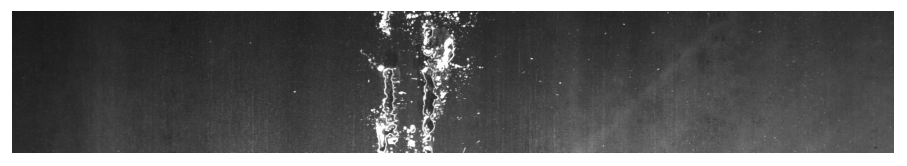

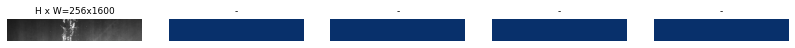

In [5]:
# Load example images and masks.
#files = ['000a4bcdd.jpg', '000f6bf48.jpg', '00ac8372f.jpg', '00af2671f.jpg']
files = ['00fe04c98.jpg','0a5a82b86.jpg','0a9a7a6c7.jpg','0a34e73df.jpg','0a76ac9b8.jpg','0a76c7934.jpg','0a122ef42.jpg']
dataset = SteelDataset()
print(ROOT_DIR)
dataset.load_steel(ROOT_DIR, files)
dataset.prepare()

image_ids = [0,1,2,3] 
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    # Display image and additional stats
    print("image_id ", image_id, dataset.image_reference(image_id))
    log("image", image)
    log("mask", mask)
    log("class_ids", class_ids)
    log("bbox", bbox)
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [8]:
# select files for test and validation dataset
# Load annotations CSV
annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

# Remove images without Encoding
#annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        
annotations_train_Encoded = annotations_train
# Split ImageId_ClassId
#ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
#annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
#annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]

# Split dataframe
msk = np.random.rand(len(annotations_train_Encoded)) < 0.8
train_msk = annotations_train_Encoded[msk]
val_msk = annotations_train_Encoded[~msk]
train = train_msk['ImageId'].unique().copy()
val = val_msk['ImageId'].unique().copy()
print('Train images: ' + str(len(train)))
print('Test images: ' + str(len(val)))
# Cleanup
#del annotations_train, annotations_train_Encoded, msk, train_msk, val_msk 
#gc.collect()

Train images: 5392
Test images: 1411


In [36]:
b = np.random.rand(len(annotations_train_Encoded)) < 0.8
b.shape

(7095,)

In [38]:
c = train_msk['ImageId'].unique().copy()
c.shape

(5469,)

In [35]:
b.shape

(7095,)

In [9]:
# Training preperations
# Training dataset
dataset_train = SteelDataset()
dataset_train.load_steel(ROOT_DIR, train)
dataset_train.prepare()

# Validation dataset
dataset_val = SteelDataset()
dataset_val.load_steel(ROOT_DIR, val)
dataset_val.prepare()

# Build training model
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
# Required due to change in new Tensorflow / Keras version
model.keras_model.metrics_tensors = []
# Load weights to continue training
# model.load_weights(Trained_Weights, by_name=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [9]:
# Train model
#timestart = timeit.default_timer()
print("Training")
model.train(dataset_train, 
            dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=config.EPOCHS,
            layers='all')
#print ('Total run time: ' + str(runtime) + ' minutes')

Training

Starting at epoch 0. LR=0.0001

Checkpoint Path: logs\steel20211012T0857\mask_rcnn_steel_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "












Epoch 1/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:28:13 - loss: 32.8265 - rpn_class_loss: 18.5097 - rpn_bbox_loss: 8.6435 - mrcnn_class_loss: 5.6733 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:17:24 - loss: 35.9881 - rpn_class_loss: 18.9066 - rpn_bbox_loss: 11.8123 - mrcnn_class_loss: 5.2692 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:11:39 - loss: 36.0229 - rpn_class_loss: 18.7112 - rpn_bbox_loss: 12.6478 - mrcnn_class_loss: 4.6639 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:09:00 - loss: 34.4238 - rpn_class_loss: 18.0693 - rpn_bbox_loss: 12.4198 - mrcnn_class_loss: 3.9347 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:07:10 - loss: 32.5827 - rpn_class_loss: 17.1845 - rpn_bbox_loss: 12.1529 - mrcnn_class_loss: 3.2453 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:05:56 - loss: 30.5959 - rpn_class_loss: 16.1871 - rpn_bbox_loss: 11.6899 - mrcnn_class_loss: 2.7189 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:04:32 - loss: 29.6868 - rpn_class_loss: 15.1347 - rpn_bbox_loss: 12.2194 - mrcnn_class_loss: 2.3327 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:03:33 - loss: 28.7611 - rpn_class_loss: 14.1058 - rpn_bbox_loss: 12.6138 - mrcnn_class_loss: 2.0416 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:02:45 - loss: 27.1572 - rpn_class_loss: 12.9481 - rpn_bbox_loss: 12.3942 - mrcnn_class_loss: 1.8149 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:01:45 - loss: 25.7037 - rpn_class_loss: 11.9294 - rpn_bbox_loss: 12.1408 - mrcnn_class_loss: 1.6334 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:00:45 - loss: 24.5388 - rpn_class_loss: 11.1429 - rpn_bbox_loss: 11.9110 - mrcnn_class_loss: 1.4849 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 59:51 - loss: 23.4393 - rpn_class_loss: 10.3810 - rpn_bbox_loss: 11.6971 - mrcnn_class_loss: 1.3612 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 58:59 - loss: 22.5698 - rpn_class_loss: 9.7155 - rpn_bbox_loss: 11.5977 - mrcnn_class_loss: 1.2565 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 58:07 - loss: 21.4317 - rpn_class_loss: 9.1044 - rpn_bbox_loss: 11.1606 - mrcnn_class_loss: 1.1667 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 57:17 - loss: 20.6240 - rpn_class_loss: 8.5550 - rpn_bbox_loss: 10.9800 - mrcnn_class_loss: 1.0890 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 56:28 - loss: 19.8103 - rpn_class_loss: 8.0767 - rpn_bbox_loss: 10.7127 - mrcnn_class_loss: 1.0209 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 55:39 - loss: 19.0725 - rpn_class_loss: 7.6241 - rpn_bbox_loss: 10.4875 - mrcnn_class_loss: 0.9608 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:50 - loss: 18.4400 - rpn_class_loss: 7.2564 - rpn_bbox_loss: 10.2761 - mrcnn_class_loss: 0.9075 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 54:06 - loss: 17.8134 - rpn_class_loss: 6.8966 - rpn_bbox_loss: 10.0570 - mrcnn_class_loss: 0.8597 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 53:20 - loss: 17.1875 - rpn_class_loss: 6.5617 - rpn_bbox_loss: 9.8091 - mrcnn_class_loss: 0.8167 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:36 - loss: 16.5284 - rpn_class_loss: 6.2577 - rpn_bbox_loss: 9.4928 - mrcnn_class_loss: 0.7778 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:48 - loss: 16.1170 - rpn_class_loss: 5.9955 - rpn_bbox_loss: 9.3790 - mrcnn_class_loss: 0.7425 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 51:03 - loss: 15.7682 - rpn_class_loss: 5.7654 - rpn_bbox_loss: 9.2926 - mrcnn_class_loss: 0.7102 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:28 - loss: 15.3172 - rpn_class_loss: 5.5422 - rpn_bbox_loss: 9.0944 - mrcnn_class_loss: 0.6806 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:44 - loss: 15.1318 - rpn_class_loss: 5.3419 - rpn_bbox_loss: 9.1365 - mrcnn_class_loss: 0.6534 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 49:01 - loss: 14.8304 - rpn_class_loss: 5.1650 - rpn_bbox_loss: 9.0371 - mrcnn_class_loss: 0.6282 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:16 - loss: 14.5102 - rpn_class_loss: 4.9785 - rpn_bbox_loss: 8.9266 - mrcnn_class_loss: 0.6050 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:32 - loss: 14.3094 - rpn_class_loss: 4.8143 - rpn_bbox_loss: 8.9117 - mrcnn_class_loss: 0.5834 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:51 - loss: 13.9160 - rpn_class_loss: 4.6531 - rpn_bbox_loss: 8.6996 - mrcnn_class_loss: 0.5633 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:09 - loss: 13.6017 - rpn_class_loss: 4.5089 - rpn_bbox_loss: 8.5483 - mrcnn_class_loss: 0.5445 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:27 - loss: 13.3595 - rpn_class_loss: 4.3684 - rpn_bbox_loss: 8.4642 - mrcnn_class_loss: 0.5269 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:45 - loss: 13.1314 - rpn_class_loss: 4.2391 - rpn_bbox_loss: 8.3818 - mrcnn_class_loss: 0.5104 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:03 - loss: 12.8929 - rpn_class_loss: 4.1204 - rpn_bbox_loss: 8.2775 - mrcnn_class_loss: 0.4950 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:21 - loss: 12.6157 - rpn_class_loss: 4.0094 - rpn_bbox_loss: 8.1259 - mrcnn_class_loss: 0.4804 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:40 - loss: 12.3442 - rpn_class_loss: 3.9007 - rpn_bbox_loss: 7.9767 - mrcnn_class_loss: 0.4667 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:02 - loss: 12.1004 - rpn_class_loss: 3.7957 - rpn_bbox_loss: 7.8510 - mrcnn_class_loss: 0.4537 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:23 - loss: 11.9391 - rpn_class_loss: 3.6974 - rpn_bbox_loss: 7.8002 - mrcnn_class_loss: 0.4415 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:41 - loss: 11.6850 - rpn_class_loss: 3.6032 - rpn_bbox_loss: 7.6519 - mrcnn_class_loss: 0.4299 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:00 - loss: 11.4446 - rpn_class_loss: 3.5128 - rpn_bbox_loss: 7.5129 - mrcnn_class_loss: 0.4188 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:20 - loss: 11.2573 - rpn_class_loss: 3.4317 - rpn_bbox_loss: 7.4173 - mrcnn_class_loss: 0.4084 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:40 - loss: 11.1647 - rpn_class_loss: 3.3554 - rpn_bbox_loss: 7.4109 - mrcnn_class_loss: 0.3984 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 37:59 - loss: 10.9951 - rpn_class_loss: 3.2784 - rpn_bbox_loss: 7.3278 - mrcnn_class_loss: 0.3889 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:19 - loss: 10.8117 - rpn_class_loss: 3.2042 - rpn_bbox_loss: 7.2277 - mrcnn_class_loss: 0.3799 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:38 - loss: 10.7613 - rpn_class_loss: 3.1541 - rpn_bbox_loss: 7.2359 - mrcnn_class_loss: 0.3712 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 35:59 - loss: 10.5594 - rpn_class_loss: 3.0887 - rpn_bbox_loss: 7.1077 - mrcnn_class_loss: 0.3630 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:19 - loss: 10.4469 - rpn_class_loss: 3.0275 - rpn_bbox_loss: 7.0643 - mrcnn_class_loss: 0.3551 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:39 - loss: 10.2708 - rpn_class_loss: 2.9673 - rpn_bbox_loss: 6.9560 - mrcnn_class_loss: 0.3475 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 33:59 - loss: 10.1046 - rpn_class_loss: 2.9087 - rpn_bbox_loss: 6.8556 - mrcnn_class_loss: 0.3403 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:19 - loss: 9.9349 - rpn_class_loss: 2.8535 - rpn_bbox_loss: 6.7481 - mrcnn_class_loss: 0.3334 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:38 - loss: 9.8208 - rpn_class_loss: 2.8026 - rpn_bbox_loss: 6.6914 - mrcnn_class_loss: 0.3267 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:57 - loss: 9.6535 - rpn_class_loss: 2.7478 - rpn_bbox_loss: 6.5854 - mrcnn_class_loss: 0.3203 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:17 - loss: 9.5125 - rpn_class_loss: 2.6966 - rpn_bbox_loss: 6.5017 - mrcnn_class_loss: 0.3141 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:38 - loss: 9.3604 - rpn_class_loss: 2.6486 - rpn_bbox_loss: 6.4036 - mrcnn_class_loss: 0.3082 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:58 - loss: 9.2665 - rpn_class_loss: 2.6031 - rpn_bbox_loss: 6.3608 - mrcnn_class_loss: 0.3025 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:18 - loss: 9.1442 - rpn_class_loss: 2.5569 - rpn_bbox_loss: 6.2903 - mrcnn_class_loss: 0.2970 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:38 - loss: 9.0145 - rpn_class_loss: 2.5147 - rpn_bbox_loss: 6.2081 - mrcnn_class_loss: 0.2917 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 27:58 - loss: 8.8769 - rpn_class_loss: 2.4712 - rpn_bbox_loss: 6.1192 - mrcnn_class_loss: 0.2866 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:19 - loss: 8.7829 - rpn_class_loss: 2.4348 - rpn_bbox_loss: 6.0665 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:39 - loss: 8.7082 - rpn_class_loss: 2.3945 - rpn_bbox_loss: 6.0368 - mrcnn_class_loss: 0.2769 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 25:59 - loss: 8.6058 - rpn_class_loss: 2.3589 - rpn_bbox_loss: 5.9746 - mrcnn_class_loss: 0.2722 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:20 - loss: 8.5105 - rpn_class_loss: 2.3251 - rpn_bbox_loss: 5.9175 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:40 - loss: 8.4000 - rpn_class_loss: 2.2943 - rpn_bbox_loss: 5.8422 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:01 - loss: 8.3081 - rpn_class_loss: 2.2590 - rpn_bbox_loss: 5.7898 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:21 - loss: 8.2156 - rpn_class_loss: 2.2246 - rpn_bbox_loss: 5.7357 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:41 - loss: 8.1183 - rpn_class_loss: 2.1911 - rpn_bbox_loss: 5.6759 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:02 - loss: 8.0238 - rpn_class_loss: 2.1608 - rpn_bbox_loss: 5.6155 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:22 - loss: 7.9580 - rpn_class_loss: 2.1311 - rpn_bbox_loss: 5.5831 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:43 - loss: 7.8704 - rpn_class_loss: 2.1015 - rpn_bbox_loss: 5.5286 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:04 - loss: 7.7786 - rpn_class_loss: 2.0740 - rpn_bbox_loss: 5.4678 - mrcnn_class_loss: 0.2367 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:25 - loss: 7.7077 - rpn_class_loss: 2.0457 - rpn_bbox_loss: 5.4286 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:45 - loss: 7.6152 - rpn_class_loss: 2.0172 - rpn_bbox_loss: 5.3679 - mrcnn_class_loss: 0.2301 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:06 - loss: 7.5540 - rpn_class_loss: 1.9941 - rpn_bbox_loss: 5.3330 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:27 - loss: 7.4981 - rpn_class_loss: 1.9685 - rpn_bbox_loss: 5.3059 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:48 - loss: 7.4456 - rpn_class_loss: 1.9426 - rpn_bbox_loss: 5.2823 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:09 - loss: 7.3797 - rpn_class_loss: 1.9192 - rpn_bbox_loss: 5.2427 - mrcnn_class_loss: 0.2178 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:30 - loss: 7.2950 - rpn_class_loss: 1.8945 - rpn_bbox_loss: 5.1855 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 14:50 - loss: 7.2202 - rpn_class_loss: 1.8700 - rpn_bbox_loss: 5.1381 - mrcnn_class_loss: 0.2121 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:11 - loss: 7.1914 - rpn_class_loss: 1.8471 - rpn_bbox_loss: 5.1349 - mrcnn_class_loss: 0.2094 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:32 - loss: 7.1269 - rpn_class_loss: 1.8250 - rpn_bbox_loss: 5.0951 - mrcnn_class_loss: 0.2068 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 12:53 - loss: 7.0508 - rpn_class_loss: 1.8032 - rpn_bbox_loss: 5.0434 - mrcnn_class_loss: 0.2042 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:15 - loss: 6.9793 - rpn_class_loss: 1.7829 - rpn_bbox_loss: 4.9947 - mrcnn_class_loss: 0.2017 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:36 - loss: 6.9228 - rpn_class_loss: 1.7635 - rpn_bbox_loss: 4.9601 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 10:57 - loss: 6.8570 - rpn_class_loss: 1.7424 - rpn_bbox_loss: 4.9178 - mrcnn_class_loss: 0.1968 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:18 - loss: 6.8100 - rpn_class_loss: 1.7231 - rpn_bbox_loss: 4.8924 - mrcnn_class_loss: 0.1945 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:39 - loss: 6.7616 - rpn_class_loss: 1.7035 - rpn_bbox_loss: 4.8659 - mrcnn_class_loss: 0.1922 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:00 - loss: 6.7055 - rpn_class_loss: 1.6844 - rpn_bbox_loss: 4.8311 - mrcnn_class_loss: 0.1899 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:22 - loss: 6.6408 - rpn_class_loss: 1.6658 - rpn_bbox_loss: 4.7873 - mrcnn_class_loss: 0.1878 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:43 - loss: 6.5836 - rpn_class_loss: 1.6483 - rpn_bbox_loss: 4.7496 - mrcnn_class_loss: 0.1856 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:04 - loss: 6.5313 - rpn_class_loss: 1.6303 - rpn_bbox_loss: 4.7175 - mrcnn_class_loss: 0.1835 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:25 - loss: 6.4984 - rpn_class_loss: 1.6137 - rpn_bbox_loss: 4.7032 - mrcnn_class_loss: 0.1815 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:47 - loss: 6.4473 - rpn_class_loss: 1.5965 - rpn_bbox_loss: 4.6713 - mrcnn_class_loss: 0.1795 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:08 - loss: 6.4341 - rpn_class_loss: 1.5840 - rpn_bbox_loss: 4.6725 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:30 - loss: 6.3970 - rpn_class_loss: 1.5675 - rpn_bbox_loss: 4.6539 - mrcnn_class_loss: 0.1756 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:51 - loss: 6.4040 - rpn_class_loss: 1.5513 - rpn_bbox_loss: 4.6789 - mrcnn_class_loss: 0.1738 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:12 - loss: 6.3622 - rpn_class_loss: 1.5389 - rpn_bbox_loss: 4.6513 - mrcnn_class_loss: 0.1719 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:34 - loss: 6.3108 - rpn_class_loss: 1.5238 - rpn_bbox_loss: 4.6168 - mrcnn_class_loss: 0.1702 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:55 - loss: 6.2638 - rpn_class_loss: 1.5090 - rpn_bbox_loss: 4.5864 - mrcnn_class_loss: 0.1684 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:17 - loss: 6.2048 - rpn_class_loss: 1.4940 - rpn_bbox_loss: 4.5441 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 38s - loss: 6.1615 - rpn_class_loss: 1.4802 - rpn_bbox_loss: 4.5163 - mrcnn_class_loss: 0.1650 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3903s 39s/step - loss: 6.1265 - rpn_class_loss: 1.4659 - rpn_bbox_loss: 4.4973 - mrcnn_class_loss: 0.1633 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 2.8173 - val_rpn_class_loss: 0.1015 - val_rpn_bbox_loss: 2.7158 - val_mrcnn_class_loss: 1.6451e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00

Epoch 2/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:05:25 - loss: 3.0205 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 3.0116 - mrcnn_class_loss: 1.6451e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:04:23 - loss: 2.1744 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 2.1216 - mrcnn_class_loss: 1.6689e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:38 - loss: 2.1492 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 2.1125 - mrcnn_class_loss: 1.6928e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:02:53 - loss: 2.0651 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.9970 - mrcnn_class_loss: 1.7136e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:10 - loss: 2.0882 - rpn_class_loss: 0.0976 - rpn_bbox_loss: 1.9906 - mrcnn_class_loss: 1.7357e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:26 - loss: 2.2240 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 2.1015 - mrcnn_class_loss: 1.7583e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:00:43 - loss: 2.2146 - rpn_class_loss: 0.1255 - rpn_bbox_loss: 2.0890 - mrcnn_class_loss: 1.7864e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:04 - loss: 2.2197 - rpn_class_loss: 0.1255 - rpn_bbox_loss: 2.0942 - mrcnn_class_loss: 1.8164e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:24 - loss: 2.8147 - rpn_class_loss: 0.1182 - rpn_bbox_loss: 2.6964 - mrcnn_class_loss: 1.8477e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 58:46 - loss: 2.6519 - rpn_class_loss: 0.1188 - rpn_bbox_loss: 2.5332 - mrcnn_class_loss: 1.8823e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:11 - loss: 2.4919 - rpn_class_loss: 0.1128 - rpn_bbox_loss: 2.3791 - mrcnn_class_loss: 1.9203e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 57:29 - loss: 2.4536 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 2.3484 - mrcnn_class_loss: 1.9610e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 56:49 - loss: 2.4127 - rpn_class_loss: 0.1138 - rpn_bbox_loss: 2.2988 - mrcnn_class_loss: 2.0073e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:10 - loss: 2.3739 - rpn_class_loss: 0.1127 - rpn_bbox_loss: 2.2612 - mrcnn_class_loss: 2.0589e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 55:32 - loss: 2.2713 - rpn_class_loss: 0.1088 - rpn_bbox_loss: 2.1625 - mrcnn_class_loss: 2.1163e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 54:51 - loss: 2.8597 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 2.1950 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.4270 - mrcnn_mask_loss: 0.0781            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:14 - loss: 2.8968 - rpn_class_loss: 0.1090 - rpn_bbox_loss: 2.2655 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.4019 - mrcnn_mask_loss: 0.0735

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 53:33 - loss: 3.0074 - rpn_class_loss: 0.1059 - rpn_bbox_loss: 2.4081 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.3796 - mrcnn_mask_loss: 0.0694

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 52:53 - loss: 3.0672 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 2.4967 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.3596 - mrcnn_mask_loss: 0.0658

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:13 - loss: 2.9466 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 2.4012 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.3416 - mrcnn_mask_loss: 0.0625

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 51:32 - loss: 3.2876 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 2.7570 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.3254 - mrcnn_mask_loss: 0.0595

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 50:53 - loss: 3.1855 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 2.6761 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.3106 - mrcnn_mask_loss: 0.0568

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:15 - loss: 3.1274 - rpn_class_loss: 0.1062 - rpn_bbox_loss: 2.6351 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 0.0543

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 49:38 - loss: 3.0641 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 2.5911 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.2847 - mrcnn_mask_loss: 0.0521

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 48:57 - loss: 2.9822 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 2.5268 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.2733 - mrcnn_mask_loss: 0.0500

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:18 - loss: 2.9297 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 2.4868 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.0481

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 47:38 - loss: 2.8743 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 2.4459 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.2531 - mrcnn_mask_loss: 0.0463

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 46:59 - loss: 2.8307 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 2.4160 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.0446

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:20 - loss: 2.7936 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 2.3899 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.0431

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 45:41 - loss: 2.7688 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 2.3729 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2278 - mrcnn_mask_loss: 0.0416

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:01 - loss: 2.7919 - rpn_class_loss: 0.0996 - rpn_bbox_loss: 2.4059 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.0403

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:22 - loss: 2.7986 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 2.4221 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.0390

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 43:43 - loss: 2.8973 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 2.5229 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.0379

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:03 - loss: 2.8422 - rpn_class_loss: 0.1047 - rpn_bbox_loss: 2.4763 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.0367

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:25 - loss: 2.8026 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 2.4458 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1952 - mrcnn_mask_loss: 0.0357

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 41:45 - loss: 2.7662 - rpn_class_loss: 0.1017 - rpn_bbox_loss: 2.4179 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1898 - mrcnn_mask_loss: 0.0347

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:05 - loss: 2.7576 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 2.4151 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1847 - mrcnn_mask_loss: 0.0338

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:26 - loss: 2.8454 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 2.5102 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1798 - mrcnn_mask_loss: 0.0329

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 39:47 - loss: 2.8297 - rpn_class_loss: 0.1023 - rpn_bbox_loss: 2.4996 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.0320

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:07 - loss: 2.7858 - rpn_class_loss: 0.1022 - rpn_bbox_loss: 2.4615 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.0312

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:28 - loss: 2.7544 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 2.4357 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.0305

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 37:48 - loss: 2.7371 - rpn_class_loss: 0.0999 - rpn_bbox_loss: 2.4257 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1627 - mrcnn_mask_loss: 0.0297

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:09 - loss: 2.7004 - rpn_class_loss: 0.0988 - rpn_bbox_loss: 2.3950 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.0291

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:29 - loss: 2.7456 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 2.4448 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.1553 - mrcnn_mask_loss: 0.0284

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 35:50 - loss: 2.7173 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 2.4224 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.0278

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:10 - loss: 2.6992 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 2.4092 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.0272

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:31 - loss: 2.6591 - rpn_class_loss: 0.0961 - rpn_bbox_loss: 2.3740 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.0266

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 33:52 - loss: 2.8893 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 2.3664 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.3543 - mrcnn_mask_loss: 0.0487

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:13 - loss: 2.8696 - rpn_class_loss: 0.0980 - rpn_bbox_loss: 2.3544 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.3471 - mrcnn_mask_loss: 0.0477

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:34 - loss: 2.8941 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 2.3885 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.3401 - mrcnn_mask_loss: 0.0468

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 31:55 - loss: 2.8819 - rpn_class_loss: 0.0988 - rpn_bbox_loss: 2.3823 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.3334 - mrcnn_mask_loss: 0.0459

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:15 - loss: 2.8420 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 2.3518 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.3270 - mrcnn_mask_loss: 0.0450

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:36 - loss: 2.8104 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 2.3281 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.3209 - mrcnn_mask_loss: 0.0441

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 29:57 - loss: 2.8021 - rpn_class_loss: 0.0951 - rpn_bbox_loss: 2.3284 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.3149 - mrcnn_mask_loss: 0.0433

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:17 - loss: 2.7737 - rpn_class_loss: 0.0943 - rpn_bbox_loss: 2.3077 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.3092 - mrcnn_mask_loss: 0.0425

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:38 - loss: 2.7710 - rpn_class_loss: 0.0942 - rpn_bbox_loss: 2.3118 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.0418

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:00 - loss: 2.7588 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 2.3064 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.0410

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:20 - loss: 2.7572 - rpn_class_loss: 0.0927 - rpn_bbox_loss: 2.3120 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.2932 - mrcnn_mask_loss: 0.0403

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:41 - loss: 2.7274 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 2.2894 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.2882 - mrcnn_mask_loss: 0.0396

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:02 - loss: 2.7143 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 2.2817 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.2834 - mrcnn_mask_loss: 0.0390

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:23 - loss: 2.7064 - rpn_class_loss: 0.0934 - rpn_bbox_loss: 2.2779 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.2788 - mrcnn_mask_loss: 0.0383

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:44 - loss: 2.7011 - rpn_class_loss: 0.0941 - rpn_bbox_loss: 2.2773 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.2743 - mrcnn_mask_loss: 0.0377

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:05 - loss: 2.6949 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 2.2739 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.2699 - mrcnn_mask_loss: 0.0371

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:26 - loss: 2.6819 - rpn_class_loss: 0.0952 - rpn_bbox_loss: 2.2673 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2657 - mrcnn_mask_loss: 0.0365

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:46 - loss: 2.6648 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 2.2549 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.2616 - mrcnn_mask_loss: 0.0360

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:07 - loss: 2.7138 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 2.2989 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 0.0354

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:28 - loss: 2.7337 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 2.3244 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.2538 - mrcnn_mask_loss: 0.0349

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:49 - loss: 2.7203 - rpn_class_loss: 0.1035 - rpn_bbox_loss: 2.3162 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.2501 - mrcnn_mask_loss: 0.0344

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:10 - loss: 2.7410 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 2.3416 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.2465 - mrcnn_mask_loss: 0.0339

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:31 - loss: 2.7147 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 2.3200 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.0334

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:52 - loss: 2.6963 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 2.3059 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.2395 - mrcnn_mask_loss: 0.0329

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:13 - loss: 2.6689 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 2.2837 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.0325

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:34 - loss: 2.6657 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 2.2838 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.2330 - mrcnn_mask_loss: 0.0320

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:55 - loss: 2.6471 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 2.2690 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.0316

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:16 - loss: 2.6579 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 2.2828 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.2267 - mrcnn_mask_loss: 0.0312

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:36 - loss: 2.6373 - rpn_class_loss: 0.1018 - rpn_bbox_loss: 2.2665 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.0308

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 14:57 - loss: 2.6306 - rpn_class_loss: 0.1034 - rpn_bbox_loss: 2.2617 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.0304

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:18 - loss: 2.6176 - rpn_class_loss: 0.1028 - rpn_bbox_loss: 2.2527 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2180 - mrcnn_mask_loss: 0.0300

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:39 - loss: 2.6033 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 2.2415 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.0296

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:01 - loss: 2.6186 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 2.2568 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.0292

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:21 - loss: 2.5971 - rpn_class_loss: 0.1054 - rpn_bbox_loss: 2.2394 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.0289

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:42 - loss: 2.6979 - rpn_class_loss: 0.1114 - rpn_bbox_loss: 2.3372 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.2074 - mrcnn_mask_loss: 0.0285

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:03 - loss: 2.7010 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 2.3437 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.2049 - mrcnn_mask_loss: 0.0282

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:24 - loss: 2.6987 - rpn_class_loss: 0.1100 - rpn_bbox_loss: 2.3453 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.2024 - mrcnn_mask_loss: 0.0278

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:45 - loss: 2.6796 - rpn_class_loss: 0.1090 - rpn_bbox_loss: 2.3301 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.2001 - mrcnn_mask_loss: 0.0275 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:06 - loss: 2.6625 - rpn_class_loss: 0.1092 - rpn_bbox_loss: 2.3156 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.1977 - mrcnn_mask_loss: 0.0272

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:27 - loss: 2.6469 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 2.3033 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.1955 - mrcnn_mask_loss: 0.0269

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:48 - loss: 2.6299 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 2.2897 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.0266

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:09 - loss: 2.6210 - rpn_class_loss: 0.1082 - rpn_bbox_loss: 2.2831 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.1911 - mrcnn_mask_loss: 0.0263

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:30 - loss: 2.6300 - rpn_class_loss: 0.1075 - rpn_bbox_loss: 2.2954 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1890 - mrcnn_mask_loss: 0.0260

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:51 - loss: 2.6347 - rpn_class_loss: 0.1091 - rpn_bbox_loss: 2.3009 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.1869 - mrcnn_mask_loss: 0.0257

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:12 - loss: 2.6158 - rpn_class_loss: 0.1082 - rpn_bbox_loss: 2.2854 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1848 - mrcnn_mask_loss: 0.0254

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:33 - loss: 2.6619 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 2.3347 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.1829 - mrcnn_mask_loss: 0.0251

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:54 - loss: 2.6465 - rpn_class_loss: 0.1066 - rpn_bbox_loss: 2.3224 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.1809 - mrcnn_mask_loss: 0.0249

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:15 - loss: 2.6431 - rpn_class_loss: 0.1066 - rpn_bbox_loss: 2.3212 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1790 - mrcnn_mask_loss: 0.0246

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:36 - loss: 2.6367 - rpn_class_loss: 0.1071 - rpn_bbox_loss: 2.3166 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.1771 - mrcnn_mask_loss: 0.0244

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:57 - loss: 2.6258 - rpn_class_loss: 0.1065 - rpn_bbox_loss: 2.3086 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.0241

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:18 - loss: 2.6182 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 2.3022 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.0239

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.6130 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 2.2991 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.0236 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3954s 40s/step - loss: 2.6089 - rpn_class_loss: 0.1090 - rpn_bbox_loss: 2.2954 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.0234 - val_loss: 1.4923 - val_rpn_class_loss: 0.0710 - val_rpn_bbox_loss: 1.4211 - val_mrcnn_class_loss: 1.4132e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:05:37 - loss: 4.9741 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 4.9529 - mrcnn_class_loss: 1.4136e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:05:15 - loss: 2.7447 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 2.7202 - mrcnn_class_loss: 1.4071e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:40 - loss: 2.6458 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 2.6251 - mrcnn_class_loss: 1.4038e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:02:52 - loss: 2.4073 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 2.3781 - mrcnn_class_loss: 1.4036e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:06 - loss: 2.2389 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 2.1999 - mrcnn_class_loss: 1.4042e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:23 - loss: 1.9755 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.9414 - mrcnn_class_loss: 1.4038e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:00:41 - loss: 1.9125 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.8671 - mrcnn_class_loss: 1.4067e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:05 - loss: 2.0357 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.9939 - mrcnn_class_loss: 1.4125e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:23 - loss: 2.0326 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.9907 - mrcnn_class_loss: 1.4195e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 58:41 - loss: 1.9769 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.9293 - mrcnn_class_loss: 1.4299e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:02 - loss: 1.8690 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.8236 - mrcnn_class_loss: 1.4417e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 57:20 - loss: 2.0953 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 2.0202 - mrcnn_class_loss: 1.4544e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 56:38 - loss: 1.9874 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.9127 - mrcnn_class_loss: 1.4688e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 55:58 - loss: 1.9638 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 1.8830 - mrcnn_class_loss: 1.4829e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 55:16 - loss: 1.9310 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.8537 - mrcnn_class_loss: 1.4975e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 54:37 - loss: 2.0699 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.9950 - mrcnn_class_loss: 1.5135e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 53:58 - loss: 2.0211 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.9486 - mrcnn_class_loss: 1.5305e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 53:20 - loss: 1.9813 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.9102 - mrcnn_class_loss: 1.5478e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 52:40 - loss: 1.9605 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 1.8899 - mrcnn_class_loss: 1.5646e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:02 - loss: 1.9790 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 1.9071 - mrcnn_class_loss: 1.5809e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 51:21 - loss: 2.0172 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.9441 - mrcnn_class_loss: 1.5961e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 50:41 - loss: 2.0246 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.9470 - mrcnn_class_loss: 1.6102e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:16 - loss: 2.0036 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.9273 - mrcnn_class_loss: 1.6243e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 49:49 - loss: 1.9866 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.9123 - mrcnn_class_loss: 1.6367e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:11 - loss: 1.9511 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.8780 - mrcnn_class_loss: 1.6489e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:35 - loss: 1.9493 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.8748 - mrcnn_class_loss: 1.6610e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 47:55 - loss: 1.9404 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 1.8657 - mrcnn_class_loss: 1.6736e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:14 - loss: 2.0336 - rpn_class_loss: 0.0952 - rpn_bbox_loss: 1.9383 - mrcnn_class_loss: 1.6869e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:35 - loss: 2.0229 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 1.9294 - mrcnn_class_loss: 1.6997e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 45:55 - loss: 1.9966 - rpn_class_loss: 0.0921 - rpn_bbox_loss: 1.9043 - mrcnn_class_loss: 1.7127e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:14 - loss: 1.9467 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 1.8568 - mrcnn_class_loss: 1.7249e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:37 - loss: 1.9374 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.8470 - mrcnn_class_loss: 1.7362e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 43:59 - loss: 1.9371 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 1.8478 - mrcnn_class_loss: 1.7471e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:22 - loss: 1.9299 - rpn_class_loss: 0.0872 - rpn_bbox_loss: 1.8425 - mrcnn_class_loss: 1.7575e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:45 - loss: 1.9689 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 1.8749 - mrcnn_class_loss: 1.7677e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:07 - loss: 1.9390 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.8473 - mrcnn_class_loss: 1.7776e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:28 - loss: 1.9241 - rpn_class_loss: 0.0898 - rpn_bbox_loss: 1.8341 - mrcnn_class_loss: 1.7865e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:52 - loss: 1.9144 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 1.8255 - mrcnn_class_loss: 1.7949e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:13 - loss: 1.8783 - rpn_class_loss: 0.0876 - rpn_bbox_loss: 1.7905 - mrcnn_class_loss: 1.8037e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:36 - loss: 1.8431 - rpn_class_loss: 0.0858 - rpn_bbox_loss: 1.7572 - mrcnn_class_loss: 1.8135e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:59 - loss: 1.9426 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.8576 - mrcnn_class_loss: 1.8240e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:21 - loss: 2.0118 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 1.9223 - mrcnn_class_loss: 1.8352e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:43 - loss: 2.0638 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.9747 - mrcnn_class_loss: 1.8478e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 37:04 - loss: 2.0570 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 1.9690 - mrcnn_class_loss: 1.8617e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:25 - loss: 2.1123 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 2.0255 - mrcnn_class_loss: 1.8770e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:46 - loss: 2.0977 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 2.0119 - mrcnn_class_loss: 1.8936e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 35:07 - loss: 2.0824 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 1.9978 - mrcnn_class_loss: 1.9112e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:27 - loss: 2.0854 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 2.0021 - mrcnn_class_loss: 1.9301e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:47 - loss: 2.0944 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 2.0122 - mrcnn_class_loss: 1.9494e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:07 - loss: 2.0682 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 1.9870 - mrcnn_class_loss: 1.9690e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:27 - loss: 2.0536 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.9729 - mrcnn_class_loss: 1.9882e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:47 - loss: 2.0418 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.9620 - mrcnn_class_loss: 2.0067e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:07 - loss: 2.0121 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.9337 - mrcnn_class_loss: 2.0247e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:27 - loss: 2.0030 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.9257 - mrcnn_class_loss: 2.0429e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:47 - loss: 1.9953 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.9177 - mrcnn_class_loss: 2.0607e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:08 - loss: 1.9910 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.9131 - mrcnn_class_loss: 2.0790e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:28 - loss: 1.9925 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.9153 - mrcnn_class_loss: 2.0974e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:48 - loss: 2.0078 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.9281 - mrcnn_class_loss: 2.1157e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:08 - loss: 1.9992 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.9203 - mrcnn_class_loss: 2.1330e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:28 - loss: 1.9793 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.9015 - mrcnn_class_loss: 2.1495e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:49 - loss: 1.9804 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.9029 - mrcnn_class_loss: 2.1662e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:09 - loss: 1.9688 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.8912 - mrcnn_class_loss: 2.1833e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:29 - loss: 1.9890 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.9101 - mrcnn_class_loss: 2.1995e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:49 - loss: 1.9761 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.8982 - mrcnn_class_loss: 2.2153e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:09 - loss: 1.9856 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 1.9087 - mrcnn_class_loss: 2.2308e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:29 - loss: 1.9653 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.8896 - mrcnn_class_loss: 2.2461e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:49 - loss: 1.9485 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.8736 - mrcnn_class_loss: 2.2604e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:09 - loss: 1.9277 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.8534 - mrcnn_class_loss: 2.2735e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:29 - loss: 1.9252 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.8507 - mrcnn_class_loss: 2.2851e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:49 - loss: 1.9506 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.8719 - mrcnn_class_loss: 2.2943e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:09 - loss: 1.9417 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.8627 - mrcnn_class_loss: 2.3013e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:29 - loss: 1.9863 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.9080 - mrcnn_class_loss: 2.3069e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:50 - loss: 1.9733 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.8952 - mrcnn_class_loss: 2.3118e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:10 - loss: 1.9638 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.8859 - mrcnn_class_loss: 2.3164e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:30 - loss: 1.9591 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.8815 - mrcnn_class_loss: 2.3209e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:50 - loss: 1.9570 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.8791 - mrcnn_class_loss: 2.3253e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:11 - loss: 1.9513 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.8738 - mrcnn_class_loss: 2.3290e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:31 - loss: 1.9483 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.8700 - mrcnn_class_loss: 2.3321e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:51 - loss: 1.9388 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.8609 - mrcnn_class_loss: 2.3344e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:11 - loss: 1.9196 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.8423 - mrcnn_class_loss: 2.3362e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:32 - loss: 1.9591 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 1.8778 - mrcnn_class_loss: 2.3373e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:52 - loss: 1.9574 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.8734 - mrcnn_class_loss: 2.3381e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:13 - loss: 1.9805 - rpn_class_loss: 0.0834 - rpn_bbox_loss: 1.8969 - mrcnn_class_loss: 2.3388e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:33 - loss: 1.9749 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 1.8892 - mrcnn_class_loss: 2.3401e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:54 - loss: 1.9769 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 1.8865 - mrcnn_class_loss: 2.3418e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:14 - loss: 1.9605 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 1.8699 - mrcnn_class_loss: 2.3442e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:34 - loss: 1.9525 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 1.8627 - mrcnn_class_loss: 2.3470e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:55 - loss: 1.9492 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.8602 - mrcnn_class_loss: 2.3501e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:15 - loss: 1.9436 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 1.8555 - mrcnn_class_loss: 2.3533e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:36 - loss: 1.9343 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 1.8465 - mrcnn_class_loss: 2.3564e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:56 - loss: 1.9455 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 1.8578 - mrcnn_class_loss: 2.3595e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:16 - loss: 1.9369 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 1.8497 - mrcnn_class_loss: 2.3621e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:37 - loss: 1.9366 - rpn_class_loss: 0.0864 - rpn_bbox_loss: 1.8500 - mrcnn_class_loss: 2.3646e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:57 - loss: 1.9313 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 1.8451 - mrcnn_class_loss: 2.3669e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:18 - loss: 1.9224 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 1.8368 - mrcnn_class_loss: 2.3693e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 1.9129 - rpn_class_loss: 0.0847 - rpn_bbox_loss: 1.8280 - mrcnn_class_loss: 2.3717e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 1.9107 - rpn_class_loss: 0.0845 - rpn_bbox_loss: 1.8259 - mrcnn_class_loss: 2.3739e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 1.9045 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.8205 - mrcnn_class_loss: 2.3759e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 1.8930 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.8092 - mrcnn_class_loss: 2.3775e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4014s 40s/step - loss: 1.9341 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 1.8510 - mrcnn_class_loss: 2.3787e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.9981 - val_rpn_class_loss: 0.1470 - val_rpn_bbox_loss: 1.8508 - val_mrcnn_class_loss: 2.4471e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 4/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:07:37 - loss: 2.1308 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 2.0617 - mrcnn_class_loss: 2.4471e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:05:16 - loss: 3.0138 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 2.9613 - mrcnn_class_loss: 2.4197e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:04:51 - loss: 3.0665 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 2.9962 - mrcnn_class_loss: 2.3922e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:04:05 - loss: 2.5977 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 2.5270 - mrcnn_class_loss: 2.3666e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:03:16 - loss: 2.6008 - rpn_class_loss: 0.1131 - rpn_bbox_loss: 2.4874 - mrcnn_class_loss: 2.3465e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:02:33 - loss: 2.3008 - rpn_class_loss: 0.0961 - rpn_bbox_loss: 2.2043 - mrcnn_class_loss: 2.3307e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:54 - loss: 2.4190 - rpn_class_loss: 0.2007 - rpn_bbox_loss: 2.2181 - mrcnn_class_loss: 2.3197e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:01:17 - loss: 2.2707 - rpn_class_loss: 0.1857 - rpn_bbox_loss: 2.0847 - mrcnn_class_loss: 2.3127e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:00:41 - loss: 2.1482 - rpn_class_loss: 0.1663 - rpn_bbox_loss: 1.9817 - mrcnn_class_loss: 2.3074e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:53 - loss: 2.0643 - rpn_class_loss: 0.1542 - rpn_bbox_loss: 1.9098 - mrcnn_class_loss: 2.3036e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 59:16 - loss: 2.0562 - rpn_class_loss: 0.1431 - rpn_bbox_loss: 1.9128 - mrcnn_class_loss: 2.3003e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:35 - loss: 2.1528 - rpn_class_loss: 0.1334 - rpn_bbox_loss: 2.0192 - mrcnn_class_loss: 2.2972e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:48 - loss: 2.1067 - rpn_class_loss: 0.1255 - rpn_bbox_loss: 1.9810 - mrcnn_class_loss: 2.2945e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 57:08 - loss: 2.0237 - rpn_class_loss: 0.1194 - rpn_bbox_loss: 1.9041 - mrcnn_class_loss: 2.2922e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:33 - loss: 2.0053 - rpn_class_loss: 0.1356 - rpn_bbox_loss: 1.8694 - mrcnn_class_loss: 2.2911e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:51 - loss: 1.9611 - rpn_class_loss: 0.1314 - rpn_bbox_loss: 1.8294 - mrcnn_class_loss: 2.2900e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 55:06 - loss: 1.9603 - rpn_class_loss: 0.1259 - rpn_bbox_loss: 1.8342 - mrcnn_class_loss: 2.2890e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:23 - loss: 1.9212 - rpn_class_loss: 0.1203 - rpn_bbox_loss: 1.8007 - mrcnn_class_loss: 2.2861e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:39 - loss: 1.8871 - rpn_class_loss: 0.1147 - rpn_bbox_loss: 1.7722 - mrcnn_class_loss: 2.2810e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:55 - loss: 1.8808 - rpn_class_loss: 0.1116 - rpn_bbox_loss: 1.7689 - mrcnn_class_loss: 2.2747e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:12 - loss: 1.8781 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 1.7702 - mrcnn_class_loss: 2.2667e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:30 - loss: 1.8472 - rpn_class_loss: 0.1030 - rpn_bbox_loss: 1.7440 - mrcnn_class_loss: 2.2565e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:47 - loss: 1.8663 - rpn_class_loss: 0.0997 - rpn_bbox_loss: 1.7664 - mrcnn_class_loss: 2.2457e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:06 - loss: 1.8597 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 1.7623 - mrcnn_class_loss: 2.2336e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:24 - loss: 1.8392 - rpn_class_loss: 0.0936 - rpn_bbox_loss: 1.7454 - mrcnn_class_loss: 2.2205e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:43 - loss: 1.8644 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 1.7664 - mrcnn_class_loss: 2.2070e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:02 - loss: 1.8657 - rpn_class_loss: 0.0947 - rpn_bbox_loss: 1.7707 - mrcnn_class_loss: 2.1933e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:20 - loss: 1.8356 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 1.7436 - mrcnn_class_loss: 2.1797e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:40 - loss: 1.9314 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 1.8342 - mrcnn_class_loss: 2.1667e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:01 - loss: 1.9200 - rpn_class_loss: 0.0950 - rpn_bbox_loss: 1.8248 - mrcnn_class_loss: 2.1545e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:21 - loss: 1.9927 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 1.8845 - mrcnn_class_loss: 2.1430e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:41 - loss: 1.9781 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 1.8711 - mrcnn_class_loss: 2.1318e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:01 - loss: 1.9411 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 1.8364 - mrcnn_class_loss: 2.1213e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:22 - loss: 1.9366 - rpn_class_loss: 0.1030 - rpn_bbox_loss: 1.8334 - mrcnn_class_loss: 2.1119e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:42 - loss: 1.9187 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 1.8153 - mrcnn_class_loss: 2.1037e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:02 - loss: 1.8955 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 1.7940 - mrcnn_class_loss: 2.0970e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:23 - loss: 1.8898 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 1.7901 - mrcnn_class_loss: 2.0911e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:42 - loss: 1.8983 - rpn_class_loss: 0.0986 - rpn_bbox_loss: 1.7994 - mrcnn_class_loss: 2.0858e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:02 - loss: 1.8807 - rpn_class_loss: 0.0990 - rpn_bbox_loss: 1.7815 - mrcnn_class_loss: 2.0805e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:23 - loss: 1.8794 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 1.7747 - mrcnn_class_loss: 2.0753e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:42 - loss: 1.8681 - rpn_class_loss: 0.1024 - rpn_bbox_loss: 1.7655 - mrcnn_class_loss: 2.0700e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:02 - loss: 1.9511 - rpn_class_loss: 0.1011 - rpn_bbox_loss: 1.8497 - mrcnn_class_loss: 2.0647e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:22 - loss: 1.9643 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 1.8643 - mrcnn_class_loss: 2.0593e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:42 - loss: 1.9572 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 1.8585 - mrcnn_class_loss: 2.0534e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:03 - loss: 1.9287 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 1.8308 - mrcnn_class_loss: 2.0470e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:24 - loss: 2.0285 - rpn_class_loss: 0.0964 - rpn_bbox_loss: 1.8287 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.0175            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:44 - loss: 2.0282 - rpn_class_loss: 0.0950 - rpn_bbox_loss: 1.8321 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.0172

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:04 - loss: 2.0269 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 1.8333 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.0168

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:25 - loss: 2.0043 - rpn_class_loss: 0.0944 - rpn_bbox_loss: 1.8130 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.0165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:46 - loss: 2.0034 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 1.8145 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.0161

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:05 - loss: 2.0177 - rpn_class_loss: 0.0979 - rpn_bbox_loss: 1.8265 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.0158

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:26 - loss: 2.0174 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 1.8290 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.0155

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:46 - loss: 2.0120 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 1.8254 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.0152

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:07 - loss: 1.9929 - rpn_class_loss: 0.0959 - rpn_bbox_loss: 1.8090 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.0149

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:27 - loss: 2.0054 - rpn_class_loss: 0.0955 - rpn_bbox_loss: 1.8235 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.0147

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:47 - loss: 1.9953 - rpn_class_loss: 0.0960 - rpn_bbox_loss: 1.8144 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.0144

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:07 - loss: 1.9906 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 1.8117 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0624 - mrcnn_mask_loss: 0.0142

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:28 - loss: 1.9870 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 1.8110 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.0139

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:49 - loss: 1.9776 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 1.8041 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.0137

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:10 - loss: 1.9700 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 1.7990 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.0135

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:30 - loss: 1.9593 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 1.7903 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.0132

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:51 - loss: 1.9671 - rpn_class_loss: 0.0899 - rpn_bbox_loss: 1.8005 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.0130

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:11 - loss: 1.9546 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 1.7904 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.0128

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:32 - loss: 1.9541 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 1.7918 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0556 - mrcnn_mask_loss: 0.0126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:52 - loss: 1.9397 - rpn_class_loss: 0.0872 - rpn_bbox_loss: 1.7793 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0547 - mrcnn_mask_loss: 0.0124

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:13 - loss: 1.9351 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 1.7741 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0122

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:34 - loss: 1.9168 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 1.7578 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.0120

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:54 - loss: 1.9017 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 1.7449 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0119

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:15 - loss: 1.8862 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 1.7312 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.0117

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:36 - loss: 1.8911 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 1.7377 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.0115

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:56 - loss: 1.8986 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 1.7469 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.0114

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:17 - loss: 1.8899 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 1.7396 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0112

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:38 - loss: 1.9036 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 1.7542 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.0111

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 16:58 - loss: 1.8877 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.7398 - mrcnn_class_loss: 0.0053 - mrcnn_bbox_loss: 0.0481 - mrcnn_mask_loss: 0.0109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:19 - loss: 1.8716 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 1.7249 - mrcnn_class_loss: 0.0053 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.0108

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:40 - loss: 1.8736 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 1.7285 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.0106

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:01 - loss: 1.8743 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.7303 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.0105

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:22 - loss: 1.8664 - rpn_class_loss: 0.0819 - rpn_bbox_loss: 1.7235 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.0103

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:43 - loss: 1.8597 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.7181 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0450 - mrcnn_mask_loss: 0.0102

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:03 - loss: 1.8654 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 1.7247 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.0101

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:24 - loss: 1.8621 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.7228 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:45 - loss: 1.8616 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 1.7237 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0098

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:06 - loss: 1.8516 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.7146 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0097

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:27 - loss: 1.8619 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 1.7245 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0096

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:47 - loss: 1.8560 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 1.7199 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0095 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:09 - loss: 1.8398 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.7051 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.0094

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:29 - loss: 1.8411 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.7073 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0093

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:51 - loss: 1.8324 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.6996 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.0092

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:11 - loss: 1.8354 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.7031 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0091

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:32 - loss: 1.8344 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 1.7013 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0090

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:53 - loss: 1.8305 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.6986 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.0089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:14 - loss: 1.8273 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.6960 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.0088

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:34 - loss: 1.8290 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.6984 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.0087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:55 - loss: 1.8247 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.6944 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.0086

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:16 - loss: 1.8172 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.6880 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0374 - mrcnn_mask_loss: 0.0085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:37 - loss: 1.8184 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 1.6899 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0371 - mrcnn_mask_loss: 0.0084

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:57 - loss: 1.8177 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.6903 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0367 - mrcnn_mask_loss: 0.0083

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:18 - loss: 1.8114 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.6852 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0363 - mrcnn_mask_loss: 0.0082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 1.8013 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.6757 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0082 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3983s 40s/step - loss: 1.7995 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.6748 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0356 - mrcnn_mask_loss: 0.0081 - val_loss: 1.6744 - val_rpn_class_loss: 0.0333 - val_rpn_bbox_loss: 1.6408 - val_mrcnn_class_loss: 3.3313e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 5/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:01:04 - loss: 1.0235 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.9986 - mrcnn_class_loss: 3.3313e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:06:33 - loss: 1.1585 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 1.1387 - mrcnn_class_loss: 3.3159e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:06:04 - loss: 3.5906 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 1.5493 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 1.4166 - mrcnn_mask_loss: 0.3698            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:05:06 - loss: 3.0718 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 1.5261 - mrcnn_class_loss: 0.1765 - mrcnn_bbox_loss: 1.0624 - mrcnn_mask_loss: 0.2774

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:04:28 - loss: 3.7821 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 2.5410 - mrcnn_class_loss: 0.1413 - mrcnn_bbox_loss: 0.8499 - mrcnn_mask_loss: 0.2219

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:03:45 - loss: 3.3742 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 2.3337 - mrcnn_class_loss: 0.1178 - mrcnn_bbox_loss: 0.7083 - mrcnn_mask_loss: 0.1849

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:02:50 - loss: 2.9871 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 2.0895 - mrcnn_class_loss: 0.1010 - mrcnn_bbox_loss: 0.6071 - mrcnn_mask_loss: 0.1585

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:01:59 - loss: 2.7582 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.9686 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.5312 - mrcnn_mask_loss: 0.1387

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:01:04 - loss: 2.5462 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 1.8429 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.4722 - mrcnn_mask_loss: 0.1233

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:00:13 - loss: 2.4378 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 1.8032 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.4250 - mrcnn_mask_loss: 0.1110

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 59:34 - loss: 2.2905 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 1.7109 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.3863 - mrcnn_mask_loss: 0.1009  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:45 - loss: 2.2450 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 1.7055 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.3541 - mrcnn_mask_loss: 0.0925

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 58:02 - loss: 2.1977 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 1.6977 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.3269 - mrcnn_mask_loss: 0.0853

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 57:22 - loss: 2.1268 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.6569 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.0793

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:39 - loss: 2.0799 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 1.6360 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2833 - mrcnn_mask_loss: 0.0740

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:52 - loss: 2.0842 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 1.6659 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2656 - mrcnn_mask_loss: 0.0693

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 55:13 - loss: 2.0521 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.6412 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2500 - mrcnn_mask_loss: 0.0653

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:33 - loss: 2.1039 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.6913 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2361 - mrcnn_mask_loss: 0.0616

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:52 - loss: 2.0684 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.6755 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.0584

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 53:14 - loss: 2.1396 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.6422 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.2802 - mrcnn_mask_loss: 0.0942

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:34 - loss: 2.0985 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.6226 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.2669 - mrcnn_mask_loss: 0.0897

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:52 - loss: 2.0783 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 1.6224 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.2547 - mrcnn_mask_loss: 0.0856

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 51:09 - loss: 2.0794 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 1.6403 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2437 - mrcnn_mask_loss: 0.0819

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:28 - loss: 2.1023 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.6710 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2335 - mrcnn_mask_loss: 0.0785

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:46 - loss: 2.0816 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 1.6654 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.0753

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 49:04 - loss: 2.0680 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.6669 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.0725

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:25 - loss: 2.0567 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.6678 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.0698

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:43 - loss: 2.2617 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.6617 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.3632 - mrcnn_mask_loss: 0.1096

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 47:01 - loss: 2.4370 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 1.6551 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.1402

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:20 - loss: 2.4574 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.7009 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.4566 - mrcnn_mask_loss: 0.1355

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:38 - loss: 2.4483 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.7137 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.4418 - mrcnn_mask_loss: 0.1312

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:56 - loss: 2.4470 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.7344 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.1271

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:16 - loss: 2.4208 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.7295 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.1232

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:35 - loss: 2.4167 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.7427 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.4029 - mrcnn_mask_loss: 0.1196

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:54 - loss: 2.3641 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.7085 - mrcnn_class_loss: 0.0818 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.1162

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:14 - loss: 2.3591 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.7203 - mrcnn_class_loss: 0.0796 - mrcnn_bbox_loss: 0.3805 - mrcnn_mask_loss: 0.1129

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:32 - loss: 2.3199 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.6973 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.3702 - mrcnn_mask_loss: 0.1099

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:51 - loss: 2.2861 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.6790 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.3605 - mrcnn_mask_loss: 0.1070

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:12 - loss: 2.2571 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 1.6648 - mrcnn_class_loss: 0.0735 - mrcnn_bbox_loss: 0.3512 - mrcnn_mask_loss: 0.1043

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:31 - loss: 2.2114 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.6334 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.3424 - mrcnn_mask_loss: 0.1016

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:50 - loss: 2.1845 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.6182 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.0992

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:10 - loss: 2.1670 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.6111 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.3261 - mrcnn_mask_loss: 0.0968

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:30 - loss: 2.1457 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.6023 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.3185 - mrcnn_mask_loss: 0.0946

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:50 - loss: 2.1496 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 1.6145 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.3113 - mrcnn_mask_loss: 0.0924

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:10 - loss: 2.1154 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.5911 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.0904

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:30 - loss: 2.1401 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.6266 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.2978 - mrcnn_mask_loss: 0.0884

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:50 - loss: 2.1189 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.6142 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.0865

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:10 - loss: 2.1042 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.6097 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.0847

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:30 - loss: 2.0992 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.6115 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.2795 - mrcnn_mask_loss: 0.0830

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:51 - loss: 2.0869 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.6082 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.2739 - mrcnn_mask_loss: 0.0813

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:12 - loss: 2.0727 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.6016 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.2686 - mrcnn_mask_loss: 0.0797

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:32 - loss: 2.0590 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.5939 - mrcnn_class_loss: 0.0553 - mrcnn_bbox_loss: 0.2634 - mrcnn_mask_loss: 0.0782

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:52 - loss: 2.0521 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 1.5951 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.2584 - mrcnn_mask_loss: 0.0767

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:12 - loss: 2.0446 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.5955 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.2537 - mrcnn_mask_loss: 0.0753

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:32 - loss: 2.0349 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.5928 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.0739

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:52 - loss: 2.0223 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.5867 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 0.0726

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:13 - loss: 2.0099 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.5808 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2403 - mrcnn_mask_loss: 0.0713

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:33 - loss: 1.9919 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.5700 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.2362 - mrcnn_mask_loss: 0.0701

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:54 - loss: 2.0013 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.5827 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.2322 - mrcnn_mask_loss: 0.0689

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:14 - loss: 1.9792 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.5674 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.0678

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:34 - loss: 1.9772 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.5713 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.0667

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:54 - loss: 1.9767 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.5763 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.0656

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:16 - loss: 2.0451 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 1.6500 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.0645

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:41 - loss: 2.0704 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.6809 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.0635

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:01 - loss: 2.0516 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.6674 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.0626

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:22 - loss: 2.0358 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.6572 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.0616

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:42 - loss: 2.0149 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.6417 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.0607

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:02 - loss: 2.0038 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.6357 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.2014 - mrcnn_mask_loss: 0.0598

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:23 - loss: 2.0605 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.6975 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.1985 - mrcnn_mask_loss: 0.0589

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:43 - loss: 2.0482 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 1.6898 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.1957 - mrcnn_mask_loss: 0.0581

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:04 - loss: 2.0388 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.6851 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.1929 - mrcnn_mask_loss: 0.0573

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:25 - loss: 2.0349 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.6858 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.1902 - mrcnn_mask_loss: 0.0565

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:46 - loss: 2.0311 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.6863 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.1876 - mrcnn_mask_loss: 0.0557

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:06 - loss: 2.0197 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.6789 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.1851 - mrcnn_mask_loss: 0.0549

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:27 - loss: 2.0256 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.6873 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.1826 - mrcnn_mask_loss: 0.0542

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:47 - loss: 2.0535 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.6869 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.1953 - mrcnn_mask_loss: 0.0649

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:08 - loss: 2.0837 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.6894 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.0740

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:28 - loss: 2.1203 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.7308 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.0731

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:49 - loss: 2.1090 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 1.7243 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.0721

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:09 - loss: 2.1013 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.7204 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.0712

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:30 - loss: 2.0960 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.7195 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.2015 - mrcnn_mask_loss: 0.0704

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:50 - loss: 2.1176 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.7447 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1990 - mrcnn_mask_loss: 0.0695

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:10 - loss: 2.1930 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.7489 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.2570 - mrcnn_mask_loss: 0.0782

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:31 - loss: 2.1801 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.7411 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.2539 - mrcnn_mask_loss: 0.0772

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:51 - loss: 2.1627 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.7285 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.0763 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:12 - loss: 2.1627 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.7334 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.0754

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:33 - loss: 2.1599 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.7341 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.2451 - mrcnn_mask_loss: 0.0746

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:53 - loss: 2.1495 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.7279 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2424 - mrcnn_mask_loss: 0.0737

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:14 - loss: 2.1393 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.7222 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.2396 - mrcnn_mask_loss: 0.0729

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:34 - loss: 2.1602 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.7475 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.2370 - mrcnn_mask_loss: 0.0721

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:55 - loss: 2.1493 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 1.7409 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2344 - mrcnn_mask_loss: 0.0713

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:15 - loss: 2.1660 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.7335 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.2473 - mrcnn_mask_loss: 0.0802

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:36 - loss: 2.1656 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 1.7369 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 0.0793

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:56 - loss: 2.1627 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.7381 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.0785

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:17 - loss: 2.1581 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.7375 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.2395 - mrcnn_mask_loss: 0.0776

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:37 - loss: 2.1594 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.7430 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.2370 - mrcnn_mask_loss: 0.0768

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 2.1425 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 1.7301 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.2345 - mrcnn_mask_loss: 0.0760

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 2.1486 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.7401 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2321 - mrcnn_mask_loss: 0.0753

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.1536 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.7481 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.0745 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4003s 40s/step - loss: 2.1382 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 1.7365 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2275 - mrcnn_mask_loss: 0.0738 - val_loss: 2.5728 - val_rpn_class_loss: 0.0358 - val_rpn_bbox_loss: 2.5365 - val_mrcnn_class_loss: 5.6358e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 6/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:04:22 - loss: 2.8585 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.5820 - mrcnn_class_loss: 0.1294 - mrcnn_bbox_loss: 1.2913 - mrcnn_mask_loss: 0.8370

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:04:01 - loss: 2.5467 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 1.3843 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.6456 - mrcnn_mask_loss: 0.4185

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:18 - loss: 2.3653 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 1.5312 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.4304 - mrcnn_mask_loss: 0.2790

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:03:11 - loss: 2.0178 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.3835 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.3228 - mrcnn_mask_loss: 0.2093

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:23 - loss: 1.6760 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.1664 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.2583 - mrcnn_mask_loss: 0.1674

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:49 - loss: 1.6808 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.2520 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.1395

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:22 - loss: 1.6281 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 1.2588 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1845 - mrcnn_mask_loss: 0.1196

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:42 - loss: 2.2284 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.2661 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.6728 - mrcnn_mask_loss: 0.2079

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:00:06 - loss: 2.3867 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.2559 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.7422 - mrcnn_mask_loss: 0.2668

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:32 - loss: 2.3149 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.2871 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.6680 - mrcnn_mask_loss: 0.2401  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:55 - loss: 2.2193 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 1.2739 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.6073 - mrcnn_mask_loss: 0.2183

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:16 - loss: 2.2030 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.3334 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.5567 - mrcnn_mask_loss: 0.2001

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:38 - loss: 2.1105 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.3025 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.5139 - mrcnn_mask_loss: 0.1847

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 57:02 - loss: 2.1015 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.3464 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.1715

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:23 - loss: 2.0394 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 1.3328 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.4453 - mrcnn_mask_loss: 0.1601

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:43 - loss: 1.9702 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.3037 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.4175 - mrcnn_mask_loss: 0.1501

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 55:02 - loss: 1.9547 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.3248 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.3929 - mrcnn_mask_loss: 0.1413

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:19 - loss: 1.9880 - rpn_class_loss: 0.0803 - rpn_bbox_loss: 1.3688 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.3711 - mrcnn_mask_loss: 0.1334

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:37 - loss: 2.0288 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 1.3368 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.4040 - mrcnn_mask_loss: 0.1702

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:55 - loss: 2.0000 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 1.3412 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.1617

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:24 - loss: 2.0000 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.3680 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.3656 - mrcnn_mask_loss: 0.1540

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:51 - loss: 1.9982 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 1.3922 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.3489 - mrcnn_mask_loss: 0.1470

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 51:09 - loss: 1.9491 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.3681 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.3338 - mrcnn_mask_loss: 0.1406

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:27 - loss: 1.9226 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 1.3626 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.1347

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:46 - loss: 1.9119 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.3727 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.3071 - mrcnn_mask_loss: 0.1293

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 49:04 - loss: 1.9041 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.3821 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.2953 - mrcnn_mask_loss: 0.1244

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:25 - loss: 1.9027 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.3986 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.1198

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:50 - loss: 1.8734 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 1.3840 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.2742 - mrcnn_mask_loss: 0.1155

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 47:08 - loss: 1.8683 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.3938 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.2647 - mrcnn_mask_loss: 0.1115

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:27 - loss: 1.8528 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.3924 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.2559 - mrcnn_mask_loss: 0.1078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:45 - loss: 1.8470 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 1.4006 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.2476 - mrcnn_mask_loss: 0.1043

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 45:05 - loss: 1.8048 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.3713 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.1010

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:24 - loss: 1.7941 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.3722 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.2326 - mrcnn_mask_loss: 0.0980

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:43 - loss: 1.7824 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.3726 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.2258 - mrcnn_mask_loss: 0.0951

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 43:04 - loss: 1.8081 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.4059 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.0924

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:24 - loss: 1.9117 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.3906 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.1150

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:45 - loss: 1.8998 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.3922 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.1119

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 41:06 - loss: 1.9460 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 1.3804 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.1287

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:26 - loss: 1.9724 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.3571 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.3454 - mrcnn_mask_loss: 0.1461

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:47 - loss: 1.9603 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 1.3573 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.3368 - mrcnn_mask_loss: 0.1425

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 39:07 - loss: 2.0350 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.3901 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.3555 - mrcnn_mask_loss: 0.1630

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:26 - loss: 2.0324 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.4009 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.3470 - mrcnn_mask_loss: 0.1591

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:47 - loss: 2.0252 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.4071 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.3390 - mrcnn_mask_loss: 0.1554

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 37:09 - loss: 2.0544 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.4404 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.3313 - mrcnn_mask_loss: 0.1519

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:28 - loss: 2.0235 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 1.4225 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.1485

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:48 - loss: 2.1397 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 1.4235 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.4161 - mrcnn_mask_loss: 0.1626

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 35:08 - loss: 2.1281 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 1.4233 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.4072 - mrcnn_mask_loss: 0.1591

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:28 - loss: 2.1459 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.4114 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.4195 - mrcnn_mask_loss: 0.1716

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:48 - loss: 2.1830 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 1.4073 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.4466 - mrcnn_mask_loss: 0.1839

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:08 - loss: 2.2421 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 1.4266 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.4713 - mrcnn_mask_loss: 0.1989

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:28 - loss: 2.2713 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.4339 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.4804 - mrcnn_mask_loss: 0.2102

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:48 - loss: 2.2543 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.4324 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.4712 - mrcnn_mask_loss: 0.2061

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:08 - loss: 2.2312 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.4239 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4623 - mrcnn_mask_loss: 0.2023

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:27 - loss: 2.2207 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.4269 - mrcnn_class_loss: 0.0674 - mrcnn_bbox_loss: 0.4537 - mrcnn_mask_loss: 0.1985

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:47 - loss: 2.2286 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.4484 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.4455 - mrcnn_mask_loss: 0.1949

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:09 - loss: 2.2690 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.5024 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.4375 - mrcnn_mask_loss: 0.1914

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:28 - loss: 2.2501 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.4967 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.4299 - mrcnn_mask_loss: 0.1881

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:48 - loss: 2.2531 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.4885 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.4336 - mrcnn_mask_loss: 0.1972

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:10 - loss: 2.3155 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.5636 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.1939

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:30 - loss: 2.2821 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.5425 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.4192 - mrcnn_mask_loss: 0.1906

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:50 - loss: 2.2725 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.5434 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.4123 - mrcnn_mask_loss: 0.1875

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:11 - loss: 2.2589 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.5410 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.4057 - mrcnn_mask_loss: 0.1845

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:31 - loss: 2.3606 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.5439 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.4905 - mrcnn_mask_loss: 0.1933

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:51 - loss: 2.3338 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.5294 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.4829 - mrcnn_mask_loss: 0.1903

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:11 - loss: 2.3710 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 1.5276 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.1992

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:31 - loss: 2.3905 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.5176 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.5288 - mrcnn_mask_loss: 0.2089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:51 - loss: 2.4093 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.5110 - mrcnn_class_loss: 0.0677 - mrcnn_bbox_loss: 0.5468 - mrcnn_mask_loss: 0.2166

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:12 - loss: 2.4313 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.5035 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.5617 - mrcnn_mask_loss: 0.2271

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:32 - loss: 2.4166 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.5018 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.5536 - mrcnn_mask_loss: 0.2238

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:52 - loss: 2.4074 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.5021 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.5457 - mrcnn_mask_loss: 0.2206

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:12 - loss: 2.4861 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.5036 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.6073 - mrcnn_mask_loss: 0.2287

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:32 - loss: 2.4696 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.5001 - mrcnn_class_loss: 0.0761 - mrcnn_bbox_loss: 0.5988 - mrcnn_mask_loss: 0.2256

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:52 - loss: 2.4497 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.4933 - mrcnn_class_loss: 0.0751 - mrcnn_bbox_loss: 0.5906 - mrcnn_mask_loss: 0.2225

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:12 - loss: 2.4374 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 1.4937 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.5827 - mrcnn_mask_loss: 0.2195

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:32 - loss: 2.4109 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.4792 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.5749 - mrcnn_mask_loss: 0.2165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:52 - loss: 2.3959 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.4756 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.5673 - mrcnn_mask_loss: 0.2137

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:13 - loss: 2.3790 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.4699 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.5600 - mrcnn_mask_loss: 0.2109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:33 - loss: 2.3758 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 1.4771 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.5528 - mrcnn_mask_loss: 0.2082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:53 - loss: 2.4080 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.5200 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.5458 - mrcnn_mask_loss: 0.2056

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:13 - loss: 2.3907 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.5134 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.5390 - mrcnn_mask_loss: 0.2030

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:33 - loss: 2.3774 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.5103 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.5323 - mrcnn_mask_loss: 0.2005

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:54 - loss: 2.3870 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 1.5300 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.5258 - mrcnn_mask_loss: 0.1981

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:14 - loss: 2.3719 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.5250 - mrcnn_class_loss: 0.0662 - mrcnn_bbox_loss: 0.5195 - mrcnn_mask_loss: 0.1957

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:34 - loss: 2.4032 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.5661 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.5133 - mrcnn_mask_loss: 0.1933

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:55 - loss: 2.3951 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.5676 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.5073 - mrcnn_mask_loss: 0.1911 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:15 - loss: 2.3827 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 1.5645 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.5014 - mrcnn_mask_loss: 0.1888

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:35 - loss: 2.3804 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.5712 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.4956 - mrcnn_mask_loss: 0.1867

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:55 - loss: 2.3677 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 1.5674 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.4900 - mrcnn_mask_loss: 0.1846

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:16 - loss: 2.4050 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.5750 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.5058 - mrcnn_mask_loss: 0.1931

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:36 - loss: 2.3944 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.5733 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.5002 - mrcnn_mask_loss: 0.1910

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:56 - loss: 2.3742 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.5619 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.4947 - mrcnn_mask_loss: 0.1889

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:17 - loss: 2.3765 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.5558 - mrcnn_class_loss: 0.0664 - mrcnn_bbox_loss: 0.4980 - mrcnn_mask_loss: 0.1948

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:37 - loss: 2.3639 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 1.5519 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.4926 - mrcnn_mask_loss: 0.1927

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:57 - loss: 2.3567 - rpn_class_loss: 0.0604 - rpn_bbox_loss: 1.5532 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.4874 - mrcnn_mask_loss: 0.1907

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:18 - loss: 2.3463 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.5499 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.4823 - mrcnn_mask_loss: 0.1887

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 2.3350 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 1.5464 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.4772 - mrcnn_mask_loss: 0.1867

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 2.3520 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 1.5418 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.4936 - mrcnn_mask_loss: 0.1927

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 2.3385 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.5365 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.4886 - mrcnn_mask_loss: 0.1907

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.3270 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 1.5326 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.4837 - mrcnn_mask_loss: 0.1888 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4016s 40s/step - loss: 2.3178 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 1.5310 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.4788 - mrcnn_mask_loss: 0.1869 - val_loss: 2.2908 - val_rpn_class_loss: 0.0262 - val_rpn_bbox_loss: 1.4208 - val_mrcnn_class_loss: 0.0253 - val_mrcnn_bbox_loss: 0.5162 - val_mrcnn_mask_loss: 0.3023
Epoch 7/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:04:10 - loss: 1.2816 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 1.1913 - mrcnn_class_loss: 9.7728e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:03:27 - loss: 1.0911 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.0160 - mrcnn_class_loss: 9.7394e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:15 - loss: 1.7599 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 1.1132 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.3138 - mrcnn_mask_loss: 0.2525            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:03:26 - loss: 1.7426 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.2533 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.2353 - mrcnn_mask_loss: 0.1894

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:35 - loss: 2.1406 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.7431 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.1883 - mrcnn_mask_loss: 0.1515

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:02:07 - loss: 2.0768 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.7359 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.1263

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:14 - loss: 2.3601 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 2.0642 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:29 - loss: 2.2838 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 2.0191 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.0947

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:53 - loss: 2.1703 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 1.9265 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.0842  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:24 - loss: 2.6380 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.8590 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.5391 - mrcnn_mask_loss: 0.1761

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:40 - loss: 2.5123 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.7964 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.4901 - mrcnn_mask_loss: 0.1601

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:06 - loss: 2.5246 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.8452 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.4493 - mrcnn_mask_loss: 0.1468

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:28 - loss: 2.7916 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 1.8273 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.6483 - mrcnn_mask_loss: 0.2063

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:45 - loss: 2.7338 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.8346 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.6020 - mrcnn_mask_loss: 0.1916

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:07 - loss: 2.6560 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.8096 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.5619 - mrcnn_mask_loss: 0.1788

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:26 - loss: 2.6042 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.8093 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.5268 - mrcnn_mask_loss: 0.1676

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:51 - loss: 2.6886 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.7917 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.5793 - mrcnn_mask_loss: 0.2053

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:11 - loss: 2.7515 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.7441 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.6618 - mrcnn_mask_loss: 0.2328

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:29 - loss: 2.6692 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.7121 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.6270 - mrcnn_mask_loss: 0.2206

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:51 - loss: 2.7386 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.8268 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.5956 - mrcnn_mask_loss: 0.2095

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:12 - loss: 2.7919 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.8316 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.6055 - mrcnn_mask_loss: 0.2343

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:29 - loss: 2.7214 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.8033 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.5780 - mrcnn_mask_loss: 0.2237

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:47 - loss: 2.7026 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.8233 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.5528 - mrcnn_mask_loss: 0.2139

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:07 - loss: 2.6786 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.8340 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.5298 - mrcnn_mask_loss: 0.2050

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:27 - loss: 2.6031 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.7905 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.5086 - mrcnn_mask_loss: 0.1968

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:54 - loss: 2.6594 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.8181 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.5084 - mrcnn_mask_loss: 0.2190

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:16 - loss: 2.6224 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.8118 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.4896 - mrcnn_mask_loss: 0.2109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:35 - loss: 2.5674 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.7834 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.4721 - mrcnn_mask_loss: 0.2033

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:56 - loss: 2.5229 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.7653 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.4558 - mrcnn_mask_loss: 0.1963

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:18 - loss: 2.5833 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.7519 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.5055 - mrcnn_mask_loss: 0.2165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:37 - loss: 2.5506 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.7452 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.4892 - mrcnn_mask_loss: 0.2095

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:57 - loss: 2.5894 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 1.7261 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.5313 - mrcnn_mask_loss: 0.2259

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:19 - loss: 2.5917 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.7535 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.5152 - mrcnn_mask_loss: 0.2191

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:38 - loss: 2.5715 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.7576 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.5000 - mrcnn_mask_loss: 0.2126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:58 - loss: 2.5608 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.7683 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.4857 - mrcnn_mask_loss: 0.2065

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:19 - loss: 2.6043 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.7676 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.5117 - mrcnn_mask_loss: 0.2247

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:39 - loss: 2.6033 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.7445 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.5179 - mrcnn_mask_loss: 0.2405

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:59 - loss: 2.5884 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.7453 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.2341

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:19 - loss: 2.5517 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.7294 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.2281

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:39 - loss: 2.5337 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.7291 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.4790 - mrcnn_mask_loss: 0.2224

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:58 - loss: 2.5146 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 1.7288 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.4673 - mrcnn_mask_loss: 0.2170

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:18 - loss: 2.4829 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.7153 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.4562 - mrcnn_mask_loss: 0.2118

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:37 - loss: 2.4710 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 1.7207 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.4456 - mrcnn_mask_loss: 0.2069

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:56 - loss: 2.4573 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.7228 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.4355 - mrcnn_mask_loss: 0.2022

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:17 - loss: 2.4786 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.7025 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.4596 - mrcnn_mask_loss: 0.2146

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:36 - loss: 2.4404 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.6810 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.4496 - mrcnn_mask_loss: 0.2099

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:55 - loss: 2.4494 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.6529 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.2258

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:15 - loss: 2.4143 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 1.6338 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.4592 - mrcnn_mask_loss: 0.2211

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:35 - loss: 2.4175 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.6519 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.4498 - mrcnn_mask_loss: 0.2166

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:55 - loss: 2.4455 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.6441 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.2266

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:15 - loss: 2.4442 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.6323 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.2376

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:36 - loss: 2.4233 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.6255 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.4632 - mrcnn_mask_loss: 0.2331

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:56 - loss: 2.4061 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.6228 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.4545 - mrcnn_mask_loss: 0.2287

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:15 - loss: 2.4222 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.6085 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.2368

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:36 - loss: 2.4149 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.5960 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.2451

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:56 - loss: 2.3952 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.5903 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.4639 - mrcnn_mask_loss: 0.2407

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:16 - loss: 2.3826 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.5851 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.4558 - mrcnn_mask_loss: 0.2365

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:37 - loss: 2.3818 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.5952 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.4479 - mrcnn_mask_loss: 0.2324

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:57 - loss: 2.3655 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.5915 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.4403 - mrcnn_mask_loss: 0.2285

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:17 - loss: 2.3363 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.5747 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.4330 - mrcnn_mask_loss: 0.2247

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:38 - loss: 2.3406 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.5651 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.4421 - mrcnn_mask_loss: 0.2291

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:59 - loss: 2.3537 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.5561 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.4537 - mrcnn_mask_loss: 0.2370

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:19 - loss: 2.3548 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.5353 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.4689 - mrcnn_mask_loss: 0.2449

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:40 - loss: 2.3515 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.5439 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.4616 - mrcnn_mask_loss: 0.2410

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:00 - loss: 2.3862 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 1.5421 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.4850 - mrcnn_mask_loss: 0.2498

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:20 - loss: 2.3819 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.5491 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.4777 - mrcnn_mask_loss: 0.2460

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:42 - loss: 2.3581 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.5374 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.4706 - mrcnn_mask_loss: 0.2423

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:02 - loss: 2.3768 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.5254 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.4950 - mrcnn_mask_loss: 0.2499

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:23 - loss: 2.3683 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.5274 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.4878 - mrcnn_mask_loss: 0.2463

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:43 - loss: 2.3686 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.5193 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.4895 - mrcnn_mask_loss: 0.2530

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:04 - loss: 2.3519 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 1.5141 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.4826 - mrcnn_mask_loss: 0.2494

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:24 - loss: 2.3295 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.5030 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.2459

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:44 - loss: 2.3098 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.4933 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.4694 - mrcnn_mask_loss: 0.2426

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:05 - loss: 2.2933 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.4870 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.4630 - mrcnn_mask_loss: 0.2393

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:26 - loss: 2.2882 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.4923 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.4568 - mrcnn_mask_loss: 0.2361

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:46 - loss: 2.2773 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.4910 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.4508 - mrcnn_mask_loss: 0.2330

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:07 - loss: 2.2909 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 1.4845 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.4652 - mrcnn_mask_loss: 0.2390

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:27 - loss: 2.2840 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.4861 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.4593 - mrcnn_mask_loss: 0.2359

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:48 - loss: 2.2783 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 1.4903 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.4535 - mrcnn_mask_loss: 0.2329

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:08 - loss: 2.2694 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.4898 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.4478 - mrcnn_mask_loss: 0.2300

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:29 - loss: 2.2901 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.4803 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.4703 - mrcnn_mask_loss: 0.2378

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:49 - loss: 2.2766 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.4763 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.4646 - mrcnn_mask_loss: 0.2349

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:10 - loss: 2.2589 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.4677 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.4590 - mrcnn_mask_loss: 0.2321

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:30 - loss: 2.2701 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.4642 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.2381

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:51 - loss: 2.3141 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.4623 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.5031 - mrcnn_mask_loss: 0.2464 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:11 - loss: 2.2978 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.4549 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.4972 - mrcnn_mask_loss: 0.2436

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:32 - loss: 2.2853 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.4518 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.4915 - mrcnn_mask_loss: 0.2408

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:52 - loss: 2.3212 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 1.4673 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.5031 - mrcnn_mask_loss: 0.2478

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:13 - loss: 2.3103 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.4654 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.4974 - mrcnn_mask_loss: 0.2450

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:33 - loss: 2.3135 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.4770 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.4919 - mrcnn_mask_loss: 0.2423

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:54 - loss: 2.2987 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.4709 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.4865 - mrcnn_mask_loss: 0.2396

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:15 - loss: 2.3317 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.4887 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.2464

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:35 - loss: 2.3194 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 1.4843 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.4885 - mrcnn_mask_loss: 0.2438

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:56 - loss: 2.3096 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 1.4831 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.4833 - mrcnn_mask_loss: 0.2412

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:16 - loss: 2.3192 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.4795 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.4900 - mrcnn_mask_loss: 0.2464

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:37 - loss: 2.3045 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.4730 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.4849 - mrcnn_mask_loss: 0.2438

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 2.3078 - rpn_class_loss: 0.0606 - rpn_bbox_loss: 1.4843 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.4799 - mrcnn_mask_loss: 0.2413

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:18 - loss: 2.2969 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.4815 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.4750 - mrcnn_mask_loss: 0.2388

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.3005 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.4929 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.4702 - mrcnn_mask_loss: 0.2364 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3990s 40s/step - loss: 2.2925 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.4926 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.4655 - mrcnn_mask_loss: 0.2341 - val_loss: 2.0269 - val_rpn_class_loss: 0.0427 - val_rpn_bbox_loss: 1.4963 - val_mrcnn_class_loss: 0.0130 - val_mrcnn_bbox_loss: 0.3090 - val_mrcnn_mask_loss: 0.1659
Epoch 8/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:03:58 - loss: 1.7458 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 1.7342 - mrcnn_class_loss: 2.7629e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:16:49 - loss: 4.7567 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 1.8077 - mrcnn_class_loss: 0.2110 - mrcnn_bbox_loss: 2.2802 - mrcnn_mask_loss: 0.4416            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:11:31 - loss: 3.8192 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.8056 - mrcnn_class_loss: 0.1407 - mrcnn_bbox_loss: 1.5202 - mrcnn_mask_loss: 0.2944

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:08:34 - loss: 3.6430 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.6814 - mrcnn_class_loss: 0.1258 - mrcnn_bbox_loss: 1.3386 - mrcnn_mask_loss: 0.4405

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:06:47 - loss: 3.1930 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 1.5958 - mrcnn_class_loss: 0.1007 - mrcnn_bbox_loss: 1.0709 - mrcnn_mask_loss: 0.3524

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:05:14 - loss: 2.9407 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.5942 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.8924 - mrcnn_mask_loss: 0.2936

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:03:53 - loss: 3.3765 - rpn_class_loss: 0.0974 - rpn_bbox_loss: 2.1905 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.7649 - mrcnn_mask_loss: 0.2517

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:02:56 - loss: 3.4441 - rpn_class_loss: 0.0908 - rpn_bbox_loss: 2.1829 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.7695 - mrcnn_mask_loss: 0.3101

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:01:52 - loss: 3.2553 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 2.1322 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.6840 - mrcnn_mask_loss: 0.2757

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:00:52 - loss: 3.1632 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 2.1488 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.6156 - mrcnn_mask_loss: 0.2481

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:00:12 - loss: 3.0532 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 2.1132 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.5597 - mrcnn_mask_loss: 0.2255

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 59:25 - loss: 2.9553 - rpn_class_loss: 0.0847 - rpn_bbox_loss: 2.0902 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.5130 - mrcnn_mask_loss: 0.2067  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 58:30 - loss: 2.7677 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.9661 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.4736 - mrcnn_mask_loss: 0.1908

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 57:42 - loss: 2.7459 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 1.9963 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.4397 - mrcnn_mask_loss: 0.1772

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:52 - loss: 2.8096 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 1.9533 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.5026 - mrcnn_mask_loss: 0.2247

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 56:05 - loss: 3.0661 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.8878 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.7745 - mrcnn_mask_loss: 0.2523

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 55:20 - loss: 2.9690 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.8586 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.7290 - mrcnn_mask_loss: 0.2375

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:36 - loss: 2.9372 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.8874 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.6885 - mrcnn_mask_loss: 0.2243

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:54 - loss: 2.8837 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.8887 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.6522 - mrcnn_mask_loss: 0.2125

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 53:12 - loss: 2.8841 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 1.8472 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.6755 - mrcnn_mask_loss: 0.2248

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:32 - loss: 2.8085 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.8192 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.6433 - mrcnn_mask_loss: 0.2141

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:48 - loss: 2.8074 - rpn_class_loss: 0.0607 - rpn_bbox_loss: 1.7968 - mrcnn_class_loss: 0.0699 - mrcnn_bbox_loss: 0.6454 - mrcnn_mask_loss: 0.2345

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 51:06 - loss: 2.7358 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.7683 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.6174 - mrcnn_mask_loss: 0.2243

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:22 - loss: 2.6548 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 1.7252 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.5916 - mrcnn_mask_loss: 0.2150

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:39 - loss: 2.6632 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.6990 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.6098 - mrcnn_mask_loss: 0.2337

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:57 - loss: 2.6386 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.7087 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.5864 - mrcnn_mask_loss: 0.2247

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:15 - loss: 2.6448 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 1.7467 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.5647 - mrcnn_mask_loss: 0.2164

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:35 - loss: 2.6179 - rpn_class_loss: 0.0575 - rpn_bbox_loss: 1.7513 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.5445 - mrcnn_mask_loss: 0.2087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:55 - loss: 2.5709 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.7332 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.5257 - mrcnn_mask_loss: 0.2015

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:12 - loss: 2.6357 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.7434 - mrcnn_class_loss: 0.0567 - mrcnn_bbox_loss: 0.5539 - mrcnn_mask_loss: 0.2234

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:31 - loss: 2.5733 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.7090 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.5360 - mrcnn_mask_loss: 0.2162

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:49 - loss: 2.5446 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 1.7069 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.5193 - mrcnn_mask_loss: 0.2094

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:07 - loss: 2.5664 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.7529 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.5035 - mrcnn_mask_loss: 0.2031

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:27 - loss: 2.5341 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.7415 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.4887 - mrcnn_mask_loss: 0.1971

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:48 - loss: 2.4834 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.7106 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.1915

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:14 - loss: 2.5172 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.7057 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.4961 - mrcnn_mask_loss: 0.2060

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:33 - loss: 2.4856 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.6954 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.4827 - mrcnn_mask_loss: 0.2004

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:52 - loss: 2.4506 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 1.6803 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.4700 - mrcnn_mask_loss: 0.1951

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:12 - loss: 2.4611 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.6604 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.4887 - mrcnn_mask_loss: 0.2075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:31 - loss: 2.4955 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.7148 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.2023

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:51 - loss: 2.4698 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 1.7077 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.4649 - mrcnn_mask_loss: 0.1974

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:12 - loss: 2.5001 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.7094 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.2100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:32 - loss: 2.4623 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.6898 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.4679 - mrcnn_mask_loss: 0.2051

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:56 - loss: 2.4472 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 1.6905 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.4573 - mrcnn_mask_loss: 0.2005

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:19 - loss: 2.4395 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 1.6994 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.4471 - mrcnn_mask_loss: 0.1960

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:42 - loss: 2.4317 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.7062 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.4374 - mrcnn_mask_loss: 0.1917

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 35:02 - loss: 2.4030 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 1.6906 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.4281 - mrcnn_mask_loss: 0.1877

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:21 - loss: 2.4035 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 1.7043 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.4192 - mrcnn_mask_loss: 0.1837

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:41 - loss: 2.4162 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.6988 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.4264 - mrcnn_mask_loss: 0.1940

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:03 - loss: 2.4070 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.7032 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.4178 - mrcnn_mask_loss: 0.1901

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:27 - loss: 2.3825 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 1.6908 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.1864

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:47 - loss: 2.3453 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.6666 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.4018 - mrcnn_mask_loss: 0.1828

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:07 - loss: 2.3218 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.6555 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.3942 - mrcnn_mask_loss: 0.1794

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:27 - loss: 2.3393 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 1.6847 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.1761

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:47 - loss: 2.3326 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.6687 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.1853

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:07 - loss: 2.3124 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.6597 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.3803 - mrcnn_mask_loss: 0.1820

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:27 - loss: 2.3334 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.6529 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.3984 - mrcnn_mask_loss: 0.1921

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:46 - loss: 2.3082 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.6392 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.3915 - mrcnn_mask_loss: 0.1888

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:07 - loss: 2.2886 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.6293 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.1856

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:28 - loss: 2.2712 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.6224 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.3785 - mrcnn_mask_loss: 0.1825

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:48 - loss: 2.2547 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.6159 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.1795

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:08 - loss: 2.2372 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.6080 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.3663 - mrcnn_mask_loss: 0.1766

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:29 - loss: 2.3185 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.6254 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.4079 - mrcnn_mask_loss: 0.1899

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:50 - loss: 2.3006 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.6176 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.4015 - mrcnn_mask_loss: 0.1869

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:10 - loss: 2.2778 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.6049 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.3953 - mrcnn_mask_loss: 0.1840

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:31 - loss: 2.2624 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.5994 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.3893 - mrcnn_mask_loss: 0.1813

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:51 - loss: 2.2863 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.6312 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.1785

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:11 - loss: 2.2663 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.6205 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.3779 - mrcnn_mask_loss: 0.1759

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:31 - loss: 2.3171 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.6802 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.3724 - mrcnn_mask_loss: 0.1734

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:51 - loss: 2.3077 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.6787 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.1709

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:11 - loss: 2.3318 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.6741 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.1810

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:31 - loss: 2.3183 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.6694 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.1785

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:51 - loss: 2.3053 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.6632 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.1760

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:11 - loss: 2.3120 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.6483 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.3896 - mrcnn_mask_loss: 0.1834

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:32 - loss: 2.3005 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.6454 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.1810

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:52 - loss: 2.2869 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.6403 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.1786

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:12 - loss: 2.2703 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.6317 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.3744 - mrcnn_mask_loss: 0.1763

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:32 - loss: 2.2594 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.6276 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.3696 - mrcnn_mask_loss: 0.1740

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:52 - loss: 2.2546 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.6303 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.3650 - mrcnn_mask_loss: 0.1718

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:13 - loss: 2.2424 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 1.6239 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.3604 - mrcnn_mask_loss: 0.1697

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:33 - loss: 2.2406 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 1.6290 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.3559 - mrcnn_mask_loss: 0.1676

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:53 - loss: 2.2219 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 1.6176 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.3516 - mrcnn_mask_loss: 0.1656

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:13 - loss: 2.2085 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.6112 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 0.1636

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:34 - loss: 2.2011 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.6103 - mrcnn_class_loss: 0.0342 - mrcnn_bbox_loss: 0.3432 - mrcnn_mask_loss: 0.1616

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:54 - loss: 2.1892 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.6052 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.3392 - mrcnn_mask_loss: 0.1597 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:14 - loss: 2.2165 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.6104 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.3542 - mrcnn_mask_loss: 0.1668

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:35 - loss: 2.2456 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.6107 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.3725 - mrcnn_mask_loss: 0.1748

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:55 - loss: 2.2340 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.6059 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.3683 - mrcnn_mask_loss: 0.1728

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:15 - loss: 2.2532 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.6011 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.1800

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:36 - loss: 2.2452 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.5998 - mrcnn_class_loss: 0.0353 - mrcnn_bbox_loss: 0.3813 - mrcnn_mask_loss: 0.1780

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:56 - loss: 2.2275 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.5891 - mrcnn_class_loss: 0.0349 - mrcnn_bbox_loss: 0.3771 - mrcnn_mask_loss: 0.1760

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:16 - loss: 2.2104 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.5787 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.3730 - mrcnn_mask_loss: 0.1741

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:37 - loss: 2.2020 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.5767 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.3690 - mrcnn_mask_loss: 0.1723

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:57 - loss: 2.2043 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.5683 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.3734 - mrcnn_mask_loss: 0.1784

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:17 - loss: 2.2238 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.5636 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.1845

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 2.2208 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.5670 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.3809 - mrcnn_mask_loss: 0.1825

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 2.2196 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.5725 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.3770 - mrcnn_mask_loss: 0.1807

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 2.2054 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.5647 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.3732 - mrcnn_mask_loss: 0.1788

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.1938 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.5594 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.3694 - mrcnn_mask_loss: 0.1770 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4006s 40s/step - loss: 2.2004 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.5703 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.3657 - mrcnn_mask_loss: 0.1752 - val_loss: 1.6394 - val_rpn_class_loss: 0.0258 - val_rpn_bbox_loss: 1.0397 - val_mrcnn_class_loss: 0.0356 - val_mrcnn_bbox_loss: 0.4131 - val_mrcnn_mask_loss: 0.1252
Epoch 9/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:05:56 - loss: 1.1541 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 1.1432 - mrcnn_class_loss: 2.4959e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:04:52 - loss: 1.9805 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 1.9611 - mrcnn_class_loss: 2.4864e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:34 - loss: 2.0147 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 1.6453 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.2341            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:03:00 - loss: 1.6780 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 1.3937 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1756

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:10 - loss: 1.5620 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 1.3164 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1405

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:23 - loss: 2.0161 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.7990 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1171

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:00:46 - loss: 2.1130 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.9171 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.1003

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:03 - loss: 2.3041 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.8606 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.2208 - mrcnn_mask_loss: 0.1737

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:31 - loss: 2.3434 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.7814 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.2731 - mrcnn_mask_loss: 0.2334  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 58:55 - loss: 2.5084 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.6542 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.4964 - mrcnn_mask_loss: 0.2997

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:14 - loss: 2.4478 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.6059 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.4545 - mrcnn_mask_loss: 0.3324

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 57:31 - loss: 2.6540 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.5986 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.6151 - mrcnn_mask_loss: 0.3853

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 56:54 - loss: 2.5365 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 1.5604 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.5677 - mrcnn_mask_loss: 0.3556

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:12 - loss: 2.4284 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 1.5211 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.5272 - mrcnn_mask_loss: 0.3302

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 55:33 - loss: 2.4589 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.6014 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.4920 - mrcnn_mask_loss: 0.3082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 54:57 - loss: 2.3979 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.5919 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.4613 - mrcnn_mask_loss: 0.2890

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:16 - loss: 2.3771 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.5520 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.4585 - mrcnn_mask_loss: 0.3113

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 53:36 - loss: 2.3196 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.5383 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.4330 - mrcnn_mask_loss: 0.2940

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 52:59 - loss: 2.3081 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 1.4860 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.4530 - mrcnn_mask_loss: 0.3150

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:19 - loss: 2.5769 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.5863 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.5442 - mrcnn_mask_loss: 0.3429

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 51:38 - loss: 2.4829 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.5386 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.5183 - mrcnn_mask_loss: 0.3265

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:02 - loss: 2.5537 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.5659 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.5358 - mrcnn_mask_loss: 0.3494

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:21 - loss: 2.4886 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.5419 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.5125 - mrcnn_mask_loss: 0.3342

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 49:42 - loss: 2.4605 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.5528 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.4912 - mrcnn_mask_loss: 0.3203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:03 - loss: 2.4386 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.5659 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.4715 - mrcnn_mask_loss: 0.3075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:23 - loss: 2.3989 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.5573 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.4534 - mrcnn_mask_loss: 0.2956

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 47:44 - loss: 2.5147 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.5816 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.5260 - mrcnn_mask_loss: 0.3151

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:05 - loss: 2.4875 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.5868 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.5072 - mrcnn_mask_loss: 0.3038

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:26 - loss: 2.4904 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.5378 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.5455 - mrcnn_mask_loss: 0.3178

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 45:46 - loss: 2.4712 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.5482 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.5273 - mrcnn_mask_loss: 0.3072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:07 - loss: 2.4327 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.5382 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.5103 - mrcnn_mask_loss: 0.2973

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:29 - loss: 2.4356 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.5683 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.2880

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 43:49 - loss: 2.4036 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.5615 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.2793

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:10 - loss: 2.3461 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.5277 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.4652 - mrcnn_mask_loss: 0.2710

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:31 - loss: 2.3185 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.5228 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.4520 - mrcnn_mask_loss: 0.2633

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 41:51 - loss: 2.3251 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.5509 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.4394 - mrcnn_mask_loss: 0.2560

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:11 - loss: 2.3087 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 1.5547 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.4275 - mrcnn_mask_loss: 0.2491

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:32 - loss: 2.2700 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.5337 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.4163 - mrcnn_mask_loss: 0.2425

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 39:52 - loss: 2.2683 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 1.5503 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.4056 - mrcnn_mask_loss: 0.2363

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:13 - loss: 2.2556 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.5548 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.2304

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:34 - loss: 2.3089 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.5577 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.4268 - mrcnn_mask_loss: 0.2463

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 37:55 - loss: 2.2918 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.5581 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.4166 - mrcnn_mask_loss: 0.2404

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:15 - loss: 2.2765 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.5593 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.4069 - mrcnn_mask_loss: 0.2348

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:37 - loss: 2.2357 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 1.5339 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.3977 - mrcnn_mask_loss: 0.2295

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 35:57 - loss: 2.2283 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 1.5410 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.3888 - mrcnn_mask_loss: 0.2244

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:18 - loss: 2.2151 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 1.5422 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.3804 - mrcnn_mask_loss: 0.2195

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:39 - loss: 2.2025 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 1.5429 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.2148

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:00 - loss: 2.2240 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.5264 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.3985 - mrcnn_mask_loss: 0.2261

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:21 - loss: 2.2199 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 1.5351 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.3904 - mrcnn_mask_loss: 0.2214

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:43 - loss: 2.2129 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.5380 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.2170

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:03 - loss: 2.1877 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.5252 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.3751 - mrcnn_mask_loss: 0.2128

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:24 - loss: 2.1606 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.5101 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.3679 - mrcnn_mask_loss: 0.2087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:45 - loss: 2.1515 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.5124 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.3609 - mrcnn_mask_loss: 0.2047

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:06 - loss: 2.1220 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.4938 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.3542 - mrcnn_mask_loss: 0.2009

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:27 - loss: 2.1532 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.4829 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.2113

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 28:48 - loss: 2.1641 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.4729 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.3983 - mrcnn_mask_loss: 0.2198

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:09 - loss: 2.1520 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.4722 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.2159

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:29 - loss: 2.1246 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.4558 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.2122

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 26:50 - loss: 2.1044 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 1.4448 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.3781 - mrcnn_mask_loss: 0.2086

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:11 - loss: 2.0850 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.4354 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.3718 - mrcnn_mask_loss: 0.2051

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:31 - loss: 2.0987 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.4591 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.3657 - mrcnn_mask_loss: 0.2018

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 24:52 - loss: 2.0982 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.4448 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.3725 - mrcnn_mask_loss: 0.2092

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:13 - loss: 2.0821 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.4386 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.2058

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:33 - loss: 2.0626 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.4286 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.3609 - mrcnn_mask_loss: 0.2026

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 22:55 - loss: 2.0438 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.4181 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.3553 - mrcnn_mask_loss: 0.1995

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:15 - loss: 2.0459 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.4294 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.1965

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:36 - loss: 2.0650 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.4570 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.1936

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 20:57 - loss: 2.1040 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.4579 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.3730 - mrcnn_mask_loss: 0.2019

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:18 - loss: 2.1072 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.4517 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.3747 - mrcnn_mask_loss: 0.2092

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:38 - loss: 2.1253 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.4477 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.2165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 18:59 - loss: 2.1141 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.4456 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.2135

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:20 - loss: 2.1261 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.4458 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.2233

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:41 - loss: 2.1288 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.4397 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.2300

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:02 - loss: 2.1199 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.4399 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.2269

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:22 - loss: 2.0961 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 1.4249 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.3743 - mrcnn_mask_loss: 0.2238

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:43 - loss: 2.1224 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.4402 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.3792 - mrcnn_mask_loss: 0.2303

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:04 - loss: 2.1185 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 1.4441 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.3743 - mrcnn_mask_loss: 0.2273

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:25 - loss: 2.1058 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.4397 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.3695 - mrcnn_mask_loss: 0.2244

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:45 - loss: 2.0904 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.4317 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.3648 - mrcnn_mask_loss: 0.2215

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:06 - loss: 2.0808 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.4301 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.3602 - mrcnn_mask_loss: 0.2188

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:27 - loss: 2.0809 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.4189 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.3660 - mrcnn_mask_loss: 0.2243

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:47 - loss: 2.0718 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.4159 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.2215

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:08 - loss: 2.1100 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.4223 - mrcnn_class_loss: 0.0323 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.2282

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:29 - loss: 2.1022 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4210 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.2255

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:49 - loss: 2.1264 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4202 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.3915 - mrcnn_mask_loss: 0.2322 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:10 - loss: 2.1377 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.4131 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.4016 - mrcnn_mask_loss: 0.2377

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:31 - loss: 2.1504 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4334 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.3969 - mrcnn_mask_loss: 0.2349

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:52 - loss: 2.1419 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.4328 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.3924 - mrcnn_mask_loss: 0.2323

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:12 - loss: 2.1332 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 1.4316 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.2296

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:33 - loss: 2.1585 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.4277 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.2346

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:54 - loss: 2.1675 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4241 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.2400

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:14 - loss: 2.1964 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.4259 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.4372 - mrcnn_mask_loss: 0.2456

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:35 - loss: 2.1900 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.4274 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.2430

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:56 - loss: 2.2028 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.4221 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.4456 - mrcnn_mask_loss: 0.2481

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:16 - loss: 2.2468 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.4488 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.4589 - mrcnn_mask_loss: 0.2527

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:37 - loss: 2.2410 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.4505 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.4541 - mrcnn_mask_loss: 0.2500

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 2.2514 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.4551 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.4561 - mrcnn_mask_loss: 0.2542

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:18 - loss: 2.2363 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.4480 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.4514 - mrcnn_mask_loss: 0.2516

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.2581 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.4463 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.4654 - mrcnn_mask_loss: 0.2568 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 3989s 40s/step - loss: 2.2735 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.4485 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.4735 - mrcnn_mask_loss: 0.2614 - val_loss: 2.2538 - val_rpn_class_loss: 0.0453 - val_rpn_bbox_loss: 1.5035 - val_mrcnn_class_loss: 0.0048 - val_mrcnn_bbox_loss: 0.4187 - val_mrcnn_mask_loss: 0.2816
Epoch 10/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:04:06 - loss: 2.1956 - rpn_class_loss: 0.1059 - rpn_bbox_loss: 2.0894 - mrcnn_class_loss: 3.5244e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:04:10 - loss: 1.6108 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.5486 - mrcnn_class_loss: 3.5256e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:49 - loss: 1.8071 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.2614 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.2287            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:03:06 - loss: 1.8263 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 1.3619 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.1716

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:12 - loss: 1.7148 - rpn_class_loss: 0.0942 - rpn_bbox_loss: 1.3285 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.1372

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:44 - loss: 1.7229 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.3984 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.1144

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:00:58 - loss: 1.6105 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.3267 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.0980

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:14 - loss: 1.5581 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.3058 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.0858

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:41 - loss: 1.5377 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.3062 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.0762  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:02 - loss: 1.5785 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.3533 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.0686

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:23 - loss: 1.7250 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.3428 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.1660 - mrcnn_mask_loss: 0.1330

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 57:46 - loss: 2.1337 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.6175 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.2421 - mrcnn_mask_loss: 0.1856

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:06 - loss: 2.0120 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 1.5326 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.1713

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:29 - loss: 1.9028 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.4565 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.1591

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 55:54 - loss: 2.0489 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.4116 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.3521 - mrcnn_mask_loss: 0.2004

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:15 - loss: 2.1326 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 1.3778 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.4312 - mrcnn_mask_loss: 0.2356

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:36 - loss: 2.2023 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 1.3718 - mrcnn_class_loss: 0.0293 - mrcnn_bbox_loss: 0.4698 - mrcnn_mask_loss: 0.2674

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:00 - loss: 2.2714 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.4863 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.4437 - mrcnn_mask_loss: 0.2525

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:28 - loss: 2.2004 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 1.4545 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.4204 - mrcnn_mask_loss: 0.2392

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:48 - loss: 2.3375 - rpn_class_loss: 0.0596 - rpn_bbox_loss: 1.4570 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.5242 - mrcnn_mask_loss: 0.2657

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:09 - loss: 2.2901 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.4502 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.4992 - mrcnn_mask_loss: 0.2530

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:30 - loss: 2.3080 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 1.4160 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.5267 - mrcnn_mask_loss: 0.2769

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:50 - loss: 2.3672 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.4038 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.5806 - mrcnn_mask_loss: 0.2965

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:12 - loss: 2.4611 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.4166 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.6452 - mrcnn_mask_loss: 0.3136

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:31 - loss: 2.5003 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.3900 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.6904 - mrcnn_mask_loss: 0.3285

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:51 - loss: 2.5555 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.4871 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.6638 - mrcnn_mask_loss: 0.3159

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:12 - loss: 2.6145 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.4791 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.7140 - mrcnn_mask_loss: 0.3273

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:32 - loss: 2.5401 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.4433 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.6885 - mrcnn_mask_loss: 0.3156

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:51 - loss: 2.5618 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 1.4487 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.6911 - mrcnn_mask_loss: 0.3297

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:12 - loss: 2.5573 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.4319 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.6924 - mrcnn_mask_loss: 0.3414

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:32 - loss: 2.5804 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.4895 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.6701 - mrcnn_mask_loss: 0.3304

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:51 - loss: 2.5451 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.4877 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.6491 - mrcnn_mask_loss: 0.3201

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:10 - loss: 2.5006 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.4748 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.6295 - mrcnn_mask_loss: 0.3104

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:31 - loss: 2.4709 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.4742 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.6109 - mrcnn_mask_loss: 0.3012

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:52 - loss: 2.4698 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 1.4601 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.6154 - mrcnn_mask_loss: 0.3106

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:11 - loss: 2.4326 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.4497 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.5983 - mrcnn_mask_loss: 0.3020

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:33 - loss: 2.5139 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.4561 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.3122

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:53 - loss: 2.4719 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.4415 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.6379 - mrcnn_mask_loss: 0.3040

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:13 - loss: 2.4708 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.4357 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.6320 - mrcnn_mask_loss: 0.3148

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:34 - loss: 2.4747 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.4646 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.6162 - mrcnn_mask_loss: 0.3070

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:54 - loss: 2.4511 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.4647 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.2995

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:14 - loss: 2.4475 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.4466 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.6060 - mrcnn_mask_loss: 0.3087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:35 - loss: 2.4160 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.4374 - mrcnn_class_loss: 0.0375 - mrcnn_bbox_loss: 0.5919 - mrcnn_mask_loss: 0.3016

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:56 - loss: 2.4127 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.4538 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.5785 - mrcnn_mask_loss: 0.2947

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:15 - loss: 2.3939 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 1.4555 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.5656 - mrcnn_mask_loss: 0.2882

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:37 - loss: 2.3673 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 1.4488 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.5533 - mrcnn_mask_loss: 0.2819

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:57 - loss: 2.3657 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.4351 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.5565 - mrcnn_mask_loss: 0.2900

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:17 - loss: 2.3354 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 1.4231 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.5449 - mrcnn_mask_loss: 0.2840

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:38 - loss: 2.3250 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 1.4064 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.5425 - mrcnn_mask_loss: 0.2930

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:58 - loss: 2.3066 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 1.4058 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.5316 - mrcnn_mask_loss: 0.2872

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:18 - loss: 2.2870 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.4001 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.5212 - mrcnn_mask_loss: 0.2815

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:39 - loss: 2.2633 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.3930 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.5112 - mrcnn_mask_loss: 0.2761

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 30:59 - loss: 2.2387 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.3846 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.5016 - mrcnn_mask_loss: 0.2709

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:19 - loss: 2.2372 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 1.3982 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.4923 - mrcnn_mask_loss: 0.2659

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:40 - loss: 2.2253 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.4011 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.4833 - mrcnn_mask_loss: 0.2611

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:00 - loss: 2.2390 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 1.4291 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.4747 - mrcnn_mask_loss: 0.2564

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:20 - loss: 2.2762 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.4273 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.5042 - mrcnn_mask_loss: 0.2641

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:41 - loss: 2.2803 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 1.4221 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.5066 - mrcnn_mask_loss: 0.2717

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:01 - loss: 2.2986 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 1.4167 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.5225 - mrcnn_mask_loss: 0.2794

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:21 - loss: 2.2847 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 1.4172 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.5138 - mrcnn_mask_loss: 0.2747

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:42 - loss: 2.3485 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4192 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.5677 - mrcnn_mask_loss: 0.2821

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:02 - loss: 2.3416 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.4084 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.5663 - mrcnn_mask_loss: 0.2884

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:22 - loss: 2.3896 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.4038 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.6108 - mrcnn_mask_loss: 0.2954

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:43 - loss: 2.3750 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.4043 - mrcnn_class_loss: 0.0339 - mrcnn_bbox_loss: 0.6012 - mrcnn_mask_loss: 0.2908

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:04 - loss: 2.3558 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.3999 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.5920 - mrcnn_mask_loss: 0.2863

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:24 - loss: 2.3760 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 1.4113 - mrcnn_class_loss: 0.0343 - mrcnn_bbox_loss: 0.5924 - mrcnn_mask_loss: 0.2932

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:46 - loss: 2.3698 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.3999 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.5916 - mrcnn_mask_loss: 0.2989

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:06 - loss: 2.3757 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.3932 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.5953 - mrcnn_mask_loss: 0.3046

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:26 - loss: 2.4169 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.3949 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.6279 - mrcnn_mask_loss: 0.3104

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:47 - loss: 2.4442 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.3935 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.6509 - mrcnn_mask_loss: 0.3165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:08 - loss: 2.4238 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 1.3877 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.6417 - mrcnn_mask_loss: 0.3120

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:28 - loss: 2.4030 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.3812 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.6328 - mrcnn_mask_loss: 0.3077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:49 - loss: 2.3937 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.3828 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.6241 - mrcnn_mask_loss: 0.3034

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:09 - loss: 2.3991 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.3767 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.6273 - mrcnn_mask_loss: 0.3090

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:30 - loss: 2.3831 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.3736 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.6189 - mrcnn_mask_loss: 0.3049

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:50 - loss: 2.4088 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 1.3849 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.6274 - mrcnn_mask_loss: 0.3109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:11 - loss: 2.3967 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.3857 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.6193 - mrcnn_mask_loss: 0.3068

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:31 - loss: 2.4015 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.3841 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.6213 - mrcnn_mask_loss: 0.3118

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:51 - loss: 2.4227 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.3904 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.6294 - mrcnn_mask_loss: 0.3170

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:12 - loss: 2.4041 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.3843 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.6215 - mrcnn_mask_loss: 0.3130

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:32 - loss: 2.3886 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.3811 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.6139 - mrcnn_mask_loss: 0.3092

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:53 - loss: 2.4003 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.3800 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.6191 - mrcnn_mask_loss: 0.3141

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:13 - loss: 2.3945 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.3861 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.6116 - mrcnn_mask_loss: 0.3103

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:33 - loss: 2.3917 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.3763 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.6115 - mrcnn_mask_loss: 0.3148

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:54 - loss: 2.3969 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 1.3660 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.6203 - mrcnn_mask_loss: 0.3192 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:14 - loss: 2.3768 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 1.3575 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.3155

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:34 - loss: 2.3674 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 1.3594 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.6061 - mrcnn_mask_loss: 0.3118

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:55 - loss: 2.3496 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.3528 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.3083

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:15 - loss: 2.3455 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.3598 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.5924 - mrcnn_mask_loss: 0.3048

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:36 - loss: 2.3295 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.3541 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.5859 - mrcnn_mask_loss: 0.3014

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:56 - loss: 2.3307 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 1.3648 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.5794 - mrcnn_mask_loss: 0.2981

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:16 - loss: 2.3277 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.3576 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.5785 - mrcnn_mask_loss: 0.3026

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:37 - loss: 2.3160 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 1.3560 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.5723 - mrcnn_mask_loss: 0.2994

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:57 - loss: 2.3019 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.3519 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.5662 - mrcnn_mask_loss: 0.2962

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:18 - loss: 2.2973 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.3551 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.5603 - mrcnn_mask_loss: 0.2931

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 2.2825 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.3499 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.5544 - mrcnn_mask_loss: 0.2900

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 2.2655 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.3423 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.5487 - mrcnn_mask_loss: 0.2870

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 2.2670 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.3355 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.5518 - mrcnn_mask_loss: 0.2911

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.2943 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.3434 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.5633 - mrcnn_mask_loss: 0.2975 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4014s 40s/step - loss: 2.2756 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.3341 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.5577 - mrcnn_mask_loss: 0.2946 - val_loss: 1.8431 - val_rpn_class_loss: 0.0327 - val_rpn_bbox_loss: 1.0362 - val_mrcnn_class_loss: 0.0873 - val_mrcnn_bbox_loss: 0.4382 - val_mrcnn_mask_loss: 0.2487
Epoch 11/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:04:05 - loss: 1.9801 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.4795 - mrcnn_class_loss: 0.2118 - mrcnn_bbox_loss: 0.6246 - mrcnn_mask_loss: 0.6379

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:04:27 - loss: 2.2310 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.7660 - mrcnn_class_loss: 0.1570 - mrcnn_bbox_loss: 0.5921 - mrcnn_mask_loss: 0.6735

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:54 - loss: 2.4253 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.8929 - mrcnn_class_loss: 0.1513 - mrcnn_bbox_loss: 0.6682 - mrcnn_mask_loss: 0.6749

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:03:07 - loss: 2.9622 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.0881 - mrcnn_class_loss: 0.1367 - mrcnn_bbox_loss: 1.0170 - mrcnn_mask_loss: 0.6744

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:47 - loss: 2.4559 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.9469 - mrcnn_class_loss: 0.1093 - mrcnn_bbox_loss: 0.8136 - mrcnn_mask_loss: 0.5395

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:59 - loss: 2.3786 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.8986 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.7804 - mrcnn_mask_loss: 0.5604

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:15 - loss: 2.3066 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.8167 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.7565 - mrcnn_mask_loss: 0.5744

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:42 - loss: 2.2406 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.8195 - mrcnn_class_loss: 0.1136 - mrcnn_bbox_loss: 0.6824 - mrcnn_mask_loss: 0.5873

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:00:09 - loss: 2.3598 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.9222 - mrcnn_class_loss: 0.1221 - mrcnn_bbox_loss: 0.6848 - mrcnn_mask_loss: 0.5934

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:27 - loss: 2.2376 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.9403 - mrcnn_class_loss: 0.1099 - mrcnn_bbox_loss: 0.6163 - mrcnn_mask_loss: 0.5340  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:56 - loss: 2.3221 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.9805 - mrcnn_class_loss: 0.1164 - mrcnn_bbox_loss: 0.6266 - mrcnn_mask_loss: 0.5563

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:13 - loss: 2.3930 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.0209 - mrcnn_class_loss: 0.1118 - mrcnn_bbox_loss: 0.6471 - mrcnn_mask_loss: 0.5675

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:31 - loss: 2.4026 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.0121 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.6568 - mrcnn_mask_loss: 0.5784

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:52 - loss: 2.2483 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.9555 - mrcnn_class_loss: 0.1033 - mrcnn_bbox_loss: 0.6099 - mrcnn_mask_loss: 0.5371

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:10 - loss: 2.1982 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.9906 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.5692 - mrcnn_mask_loss: 0.5013

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:26 - loss: 2.1984 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.9479 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.6039 - mrcnn_mask_loss: 0.5138

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:50 - loss: 2.2669 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.9654 - mrcnn_class_loss: 0.0884 - mrcnn_bbox_loss: 0.6478 - mrcnn_mask_loss: 0.5255

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:08 - loss: 2.2435 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.0047 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.6118 - mrcnn_mask_loss: 0.4963

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:26 - loss: 2.3281 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.0191 - mrcnn_class_loss: 0.0864 - mrcnn_bbox_loss: 0.6659 - mrcnn_mask_loss: 0.5091

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:50 - loss: 2.2999 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.0553 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.6326 - mrcnn_mask_loss: 0.4837

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:08 - loss: 2.3126 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.0456 - mrcnn_class_loss: 0.0784 - mrcnn_bbox_loss: 0.6489 - mrcnn_mask_loss: 0.4949

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:27 - loss: 2.3640 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 1.0689 - mrcnn_class_loss: 0.0801 - mrcnn_bbox_loss: 0.6673 - mrcnn_mask_loss: 0.5032

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:50 - loss: 2.5224 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.1102 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.7720 - mrcnn_mask_loss: 0.5175

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:10 - loss: 2.5628 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 1.1285 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.7874 - mrcnn_mask_loss: 0.5238

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:30 - loss: 2.5327 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.1457 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.7559 - mrcnn_mask_loss: 0.5028

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:53 - loss: 2.6377 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 1.1668 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.8258 - mrcnn_mask_loss: 0.5169

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:13 - loss: 2.5893 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.1723 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.7952 - mrcnn_mask_loss: 0.4977

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:33 - loss: 2.5645 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.1953 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.7668 - mrcnn_mask_loss: 0.4800

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:57 - loss: 2.5277 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 1.2000 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.7403 - mrcnn_mask_loss: 0.4634

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:15 - loss: 2.4911 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.2067 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.7157 - mrcnn_mask_loss: 0.4480

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:35 - loss: 2.5224 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.2785 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.6926 - mrcnn_mask_loss: 0.4335

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:55 - loss: 2.4920 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.2865 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.6709 - mrcnn_mask_loss: 0.4200

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:15 - loss: 2.4448 - rpn_class_loss: 0.0556 - rpn_bbox_loss: 1.2745 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.6506 - mrcnn_mask_loss: 0.4072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:35 - loss: 2.5059 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.2858 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.6892 - mrcnn_mask_loss: 0.4161

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:56 - loss: 2.4484 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.2624 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.6695 - mrcnn_mask_loss: 0.4042

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:15 - loss: 2.4169 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.2632 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.6509 - mrcnn_mask_loss: 0.3930

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:35 - loss: 2.4247 - rpn_class_loss: 0.0534 - rpn_bbox_loss: 1.3010 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.6333 - mrcnn_mask_loss: 0.3824

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:56 - loss: 2.3877 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.2924 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.6167 - mrcnn_mask_loss: 0.3723

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:16 - loss: 2.4010 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.3326 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.6009 - mrcnn_mask_loss: 0.3628

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:36 - loss: 2.3859 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.3374 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.5858 - mrcnn_mask_loss: 0.3537

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:57 - loss: 2.3711 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.3472 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.5715 - mrcnn_mask_loss: 0.3451

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:18 - loss: 2.3365 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.3360 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.5579 - mrcnn_mask_loss: 0.3369

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:38 - loss: 2.3247 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.3447 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.5450 - mrcnn_mask_loss: 0.3290

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 37:00 - loss: 2.2889 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 1.3303 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.5326 - mrcnn_mask_loss: 0.3216

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:19 - loss: 2.2647 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 1.3262 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.5207 - mrcnn_mask_loss: 0.3144

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:39 - loss: 2.2874 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.3686 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.5094 - mrcnn_mask_loss: 0.3076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 35:00 - loss: 2.2607 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.3608 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.4986 - mrcnn_mask_loss: 0.3010

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:20 - loss: 2.2445 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.3626 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.4882 - mrcnn_mask_loss: 0.2948

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:40 - loss: 2.2317 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 1.3673 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.4782 - mrcnn_mask_loss: 0.2887

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:01 - loss: 2.2185 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.3700 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.4687 - mrcnn_mask_loss: 0.2830

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:21 - loss: 2.1906 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.3586 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.4595 - mrcnn_mask_loss: 0.2774

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:42 - loss: 2.1577 - rpn_class_loss: 0.0547 - rpn_bbox_loss: 1.3414 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.4506 - mrcnn_mask_loss: 0.2721

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:03 - loss: 2.1969 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.3952 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.4421 - mrcnn_mask_loss: 0.2670

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:23 - loss: 2.2296 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.4021 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.4603 - mrcnn_mask_loss: 0.2748

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:43 - loss: 2.2175 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 1.4035 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.4520 - mrcnn_mask_loss: 0.2698

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:05 - loss: 2.2061 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.4041 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.4439 - mrcnn_mask_loss: 0.2650

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:25 - loss: 2.2115 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.4233 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.4361 - mrcnn_mask_loss: 0.2603

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:45 - loss: 2.2341 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.4207 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.4501 - mrcnn_mask_loss: 0.2676

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:06 - loss: 2.2154 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.4155 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.4425 - mrcnn_mask_loss: 0.2631

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:26 - loss: 2.1859 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.3990 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.4351 - mrcnn_mask_loss: 0.2587

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:46 - loss: 2.1645 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.3900 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.2545

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:06 - loss: 2.1650 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.4024 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.2504

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:26 - loss: 2.1741 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.3899 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.4357 - mrcnn_mask_loss: 0.2571

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:46 - loss: 2.2094 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.4333 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.2530

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:07 - loss: 2.1983 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.4332 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.4223 - mrcnn_mask_loss: 0.2491

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:27 - loss: 2.1858 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.4316 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.4159 - mrcnn_mask_loss: 0.2454

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:47 - loss: 2.1833 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 1.4397 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.2417

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:08 - loss: 2.1609 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.4280 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.4037 - mrcnn_mask_loss: 0.2382

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:28 - loss: 2.1855 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.4630 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.3978 - mrcnn_mask_loss: 0.2347

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:48 - loss: 2.1672 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.4547 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.3921 - mrcnn_mask_loss: 0.2313

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:08 - loss: 2.1731 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 1.4466 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.2374

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:29 - loss: 2.1695 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.4525 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.3934 - mrcnn_mask_loss: 0.2341

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:49 - loss: 2.1654 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.4425 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.3941 - mrcnn_mask_loss: 0.2401

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:09 - loss: 2.1676 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.4276 - mrcnn_class_loss: 0.0378 - mrcnn_bbox_loss: 0.4038 - mrcnn_mask_loss: 0.2465

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:30 - loss: 2.2129 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.4330 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.4378 - mrcnn_mask_loss: 0.2529

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:50 - loss: 2.2333 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.4481 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.4368 - mrcnn_mask_loss: 0.2583

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:10 - loss: 2.2142 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.4387 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.4311 - mrcnn_mask_loss: 0.2550

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:31 - loss: 2.2057 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.4399 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.4256 - mrcnn_mask_loss: 0.2517

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:51 - loss: 2.1977 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.4401 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.2485

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:12 - loss: 2.1891 - rpn_class_loss: 0.0518 - rpn_bbox_loss: 1.4403 - mrcnn_class_loss: 0.0366 - mrcnn_bbox_loss: 0.4149 - mrcnn_mask_loss: 0.2454

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:32 - loss: 2.1771 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.4368 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.2424

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:52 - loss: 2.1813 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 1.4331 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.4117 - mrcnn_mask_loss: 0.2485

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:13 - loss: 2.1835 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.4316 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.2541

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:33 - loss: 2.1768 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 1.4335 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.4050 - mrcnn_mask_loss: 0.2511

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:54 - loss: 2.1647 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.4296 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.2481 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:14 - loss: 2.1474 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.4205 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.3956 - mrcnn_mask_loss: 0.2452

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:34 - loss: 2.1359 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.4170 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.3910 - mrcnn_mask_loss: 0.2424

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:55 - loss: 2.1308 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.4197 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.3866 - mrcnn_mask_loss: 0.2397

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:15 - loss: 2.1395 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.4131 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.3974 - mrcnn_mask_loss: 0.2446

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:36 - loss: 2.1443 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.4037 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.4067 - mrcnn_mask_loss: 0.2493

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:56 - loss: 2.1427 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.4098 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.4023 - mrcnn_mask_loss: 0.2466

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:16 - loss: 2.1275 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.4021 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.3979 - mrcnn_mask_loss: 0.2439

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:37 - loss: 2.1216 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 1.4038 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.3936 - mrcnn_mask_loss: 0.2413

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:57 - loss: 2.1292 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.3950 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.4056 - mrcnn_mask_loss: 0.2462

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:18 - loss: 2.1331 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.4056 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.2436

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 2.1295 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.4092 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.3971 - mrcnn_mask_loss: 0.2411

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 2.1262 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.4125 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.3930 - mrcnn_mask_loss: 0.2386

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 2.1194 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.4127 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.2362

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.1566 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.4568 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.2338 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4015s 40s/step - loss: 2.1591 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.4661 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.3812 - mrcnn_mask_loss: 0.2314 - val_loss: 1.3013 - val_rpn_class_loss: 0.0398 - val_rpn_bbox_loss: 1.2611 - val_mrcnn_class_loss: 4.2918e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 12/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:05:27 - loss: 1.5833 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 1.5453 - mrcnn_class_loss: 4.2918e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:05:43 - loss: 1.3962 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 1.3705 - mrcnn_class_loss: 4.3007e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:04:52 - loss: 1.7846 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 1.7515 - mrcnn_class_loss: 4.3061e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:03:43 - loss: 1.5915 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 1.5541 - mrcnn_class_loss: 4.3052e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:49 - loss: 1.4517 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.4182 - mrcnn_class_loss: 4.3090e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:02:10 - loss: 1.4026 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 1.3682 - mrcnn_class_loss: 4.3164e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:28 - loss: 1.5194 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 1.4879 - mrcnn_class_loss: 4.3257e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:47 - loss: 1.4754 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 1.4413 - mrcnn_class_loss: 4.3396e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:00:07 - loss: 1.4370 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 1.4031 - mrcnn_class_loss: 4.3609e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:26 - loss: 1.5521 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.3697 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.0644              

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:48 - loss: 1.5499 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.3803 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.0585

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:06 - loss: 1.5561 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.3922 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.0537

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:25 - loss: 1.5259 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.3709 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.0495

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:43 - loss: 1.5149 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.3690 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.0460

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:03 - loss: 1.5757 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.4329 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0429

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:25 - loss: 1.5612 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.4239 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.0402

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:44 - loss: 1.5200 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.3890 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0379

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:03 - loss: 1.5044 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.3784 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0358

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:24 - loss: 1.5550 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.4331 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.0339

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:44 - loss: 1.5097 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.3927 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0322

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:02 - loss: 1.4713 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.3592 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0307

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:26 - loss: 1.4437 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.3353 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0359 - mrcnn_mask_loss: 0.0293

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:47 - loss: 1.4318 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 1.3266 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0343 - mrcnn_mask_loss: 0.0280

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:06 - loss: 1.4163 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.3143 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0329 - mrcnn_mask_loss: 0.0268

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:28 - loss: 1.4001 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.3011 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0258

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:47 - loss: 1.4228 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.2679 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.0499

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:06 - loss: 1.5046 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.3517 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.0480

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:28 - loss: 1.5533 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.3401 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0936 - mrcnn_mask_loss: 0.0721

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:47 - loss: 1.5882 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.3795 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.0696

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:08 - loss: 1.5737 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.3706 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.0673

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:29 - loss: 1.6439 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.3697 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.1349 - mrcnn_mask_loss: 0.0885

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:49 - loss: 1.6158 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.3499 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.0858

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:08 - loss: 1.5950 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.3367 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.0832

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:30 - loss: 1.6237 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.3188 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.1017

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:50 - loss: 1.6690 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 1.3194 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.1203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:10 - loss: 1.7710 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.2986 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.2696 - mrcnn_mask_loss: 0.1374

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:33 - loss: 1.7964 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.2863 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.2862 - mrcnn_mask_loss: 0.1524

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:52 - loss: 1.7712 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.2740 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.2787 - mrcnn_mask_loss: 0.1483

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:12 - loss: 1.7916 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.2560 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.1639

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:34 - loss: 1.7745 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.2493 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.1598

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:55 - loss: 1.7795 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.2637 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.2835 - mrcnn_mask_loss: 0.1559

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:14 - loss: 1.7863 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.2822 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.2767 - mrcnn_mask_loss: 0.1522

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:36 - loss: 1.7818 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 1.2887 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.2703 - mrcnn_mask_loss: 0.1487

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:57 - loss: 1.8007 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.2785 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 0.1623

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:17 - loss: 1.7847 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 1.2733 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.2766 - mrcnn_mask_loss: 0.1587

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:39 - loss: 1.8902 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.3216 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.3190 - mrcnn_mask_loss: 0.1730

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:59 - loss: 1.8949 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 1.3049 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.3292 - mrcnn_mask_loss: 0.1832

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:18 - loss: 1.9167 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.3386 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.1794

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:40 - loss: 1.9001 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.3334 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.3157 - mrcnn_mask_loss: 0.1757

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:00 - loss: 1.8862 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.3300 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.3094 - mrcnn_mask_loss: 0.1722

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:20 - loss: 1.9162 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.3347 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.3251 - mrcnn_mask_loss: 0.1817

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:41 - loss: 1.9568 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.3436 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.3379 - mrcnn_mask_loss: 0.1930

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:01 - loss: 1.9782 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.3470 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.3473 - mrcnn_mask_loss: 0.2022

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:21 - loss: 1.9752 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 1.3553 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.3409 - mrcnn_mask_loss: 0.1985

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:42 - loss: 1.9634 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.3543 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.3347 - mrcnn_mask_loss: 0.1949

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:02 - loss: 1.9617 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.3632 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.3287 - mrcnn_mask_loss: 0.1914

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:22 - loss: 1.9426 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.3540 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.3229 - mrcnn_mask_loss: 0.1880

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:43 - loss: 1.9603 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.3526 - mrcnn_class_loss: 0.0346 - mrcnn_bbox_loss: 0.3321 - mrcnn_mask_loss: 0.1971

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:04 - loss: 1.9841 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.3865 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.1937

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:24 - loss: 1.9901 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.4021 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 0.3210 - mrcnn_mask_loss: 0.1905

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:44 - loss: 1.9719 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.3930 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.3157 - mrcnn_mask_loss: 0.1874

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:05 - loss: 1.9626 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.3927 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.3106 - mrcnn_mask_loss: 0.1844

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:25 - loss: 1.9464 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.3851 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.3057 - mrcnn_mask_loss: 0.1814

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:45 - loss: 1.9371 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.3841 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.1786

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:05 - loss: 1.9354 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 1.3904 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.2963 - mrcnn_mask_loss: 0.1758

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:26 - loss: 1.9228 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.3853 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.2918 - mrcnn_mask_loss: 0.1732

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:46 - loss: 1.9207 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 1.3907 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.1706

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:06 - loss: 1.9081 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.3854 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.2832 - mrcnn_mask_loss: 0.1681

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:27 - loss: 1.9025 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.3870 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.2791 - mrcnn_mask_loss: 0.1657

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:48 - loss: 1.8897 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.3810 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.2751 - mrcnn_mask_loss: 0.1633

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:08 - loss: 1.8931 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.3907 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.2713 - mrcnn_mask_loss: 0.1610

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:28 - loss: 1.8768 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.3812 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.2675 - mrcnn_mask_loss: 0.1587

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:49 - loss: 1.8708 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.3811 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.2638 - mrcnn_mask_loss: 0.1566

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:09 - loss: 1.8630 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.3793 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2603 - mrcnn_mask_loss: 0.1545

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:29 - loss: 1.8897 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.3799 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2790 - mrcnn_mask_loss: 0.1622

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:50 - loss: 1.9310 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.3848 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.3070 - mrcnn_mask_loss: 0.1706

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:10 - loss: 1.9220 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.3826 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.3030 - mrcnn_mask_loss: 0.1684

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:30 - loss: 1.9172 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.3844 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.2991 - mrcnn_mask_loss: 0.1662

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:51 - loss: 1.9238 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 1.3755 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.1734

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:11 - loss: 1.9190 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.3765 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.1712

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:31 - loss: 1.9170 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.3808 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 0.1691

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:52 - loss: 1.9060 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.3758 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.2966 - mrcnn_mask_loss: 0.1671

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:12 - loss: 1.9017 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 1.3776 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.2931 - mrcnn_mask_loss: 0.1650

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:33 - loss: 1.8851 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 1.3671 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.1631

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:53 - loss: 1.8954 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.3831 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.2862 - mrcnn_mask_loss: 0.1612 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:14 - loss: 1.8862 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 1.3790 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.2828 - mrcnn_mask_loss: 0.1593

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:34 - loss: 1.8747 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.3728 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.2796 - mrcnn_mask_loss: 0.1575

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:54 - loss: 1.8748 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.3763 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.2764 - mrcnn_mask_loss: 0.1557

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:15 - loss: 1.8689 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.3758 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.2733 - mrcnn_mask_loss: 0.1539

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:35 - loss: 1.8585 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.3707 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.2703 - mrcnn_mask_loss: 0.1522

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:56 - loss: 1.8436 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.3607 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.2673 - mrcnn_mask_loss: 0.1505

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:16 - loss: 1.8518 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.3568 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.1577

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:37 - loss: 1.8416 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.3516 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.1560

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:57 - loss: 1.8344 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.3495 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2668 - mrcnn_mask_loss: 0.1543

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:17 - loss: 1.8270 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 1.3440 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.2640 - mrcnn_mask_loss: 0.1527

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 1.8176 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.3395 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.2612 - mrcnn_mask_loss: 0.1511

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 1.8149 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.3416 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.2585 - mrcnn_mask_loss: 0.1496

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 1.8236 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.3344 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.2682 - mrcnn_mask_loss: 0.1558

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 1.8070 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.3223 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.2655 - mrcnn_mask_loss: 0.1543 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4009s 40s/step - loss: 1.8098 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 1.3296 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.2629 - mrcnn_mask_loss: 0.1527 - val_loss: 1.9547 - val_rpn_class_loss: 0.0268 - val_rpn_bbox_loss: 0.9494 - val_mrcnn_class_loss: 0.0883 - val_mrcnn_bbox_loss: 0.4790 - val_mrcnn_mask_loss: 0.4112
Epoch 13/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:03:36 - loss: 0.7618 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 0.6899 - mrcnn_class_loss: 2.6032e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:04:20 - loss: 1.7110 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.9486 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.2774 - mrcnn_mask_loss: 0.3421            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:36 - loss: 1.9035 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 0.8341 - mrcnn_class_loss: 0.0787 - mrcnn_bbox_loss: 0.4695 - mrcnn_mask_loss: 0.4662

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:02:49 - loss: 2.3692 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.5618 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.3521 - mrcnn_mask_loss: 0.3496

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:14 - loss: 1.9541 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.2977 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.2817 - mrcnn_mask_loss: 0.2797

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:36 - loss: 1.7695 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.2207 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2347 - mrcnn_mask_loss: 0.2331

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:00:52 - loss: 2.0597 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.2278 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.4066 - mrcnn_mask_loss: 0.3124

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:20 - loss: 2.1711 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.4358 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.2733

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:42 - loss: 2.2729 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.4175 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.4270 - mrcnn_mask_loss: 0.3085  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:02 - loss: 2.4860 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.4813 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.5366 - mrcnn_mask_loss: 0.3495

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:31 - loss: 2.3558 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.4381 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.4878 - mrcnn_mask_loss: 0.3177

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 57:50 - loss: 2.2508 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.4063 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.4472 - mrcnn_mask_loss: 0.2913

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:11 - loss: 2.1655 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.3846 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.4128 - mrcnn_mask_loss: 0.2689

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:37 - loss: 2.1768 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.3296 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.4430 - mrcnn_mask_loss: 0.2974

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 55:56 - loss: 2.2807 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.3731 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4806 - mrcnn_mask_loss: 0.3249

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:15 - loss: 2.2057 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.3530 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.4505 - mrcnn_mask_loss: 0.3046

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:37 - loss: 2.1099 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.3063 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.4240 - mrcnn_mask_loss: 0.2867

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 53:56 - loss: 2.1841 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.4219 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.4005 - mrcnn_mask_loss: 0.2707

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:15 - loss: 2.0877 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.3637 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.2565

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:38 - loss: 2.1793 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 1.3627 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.4548 - mrcnn_mask_loss: 0.2749

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 51:58 - loss: 2.1306 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.3082 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.4450 - mrcnn_mask_loss: 0.2927

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:17 - loss: 2.0781 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 1.2909 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.4248 - mrcnn_mask_loss: 0.2794

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:38 - loss: 2.0445 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.2905 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.2672

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 49:58 - loss: 2.0203 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.2969 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.2561

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:17 - loss: 2.0602 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 1.3121 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.3963 - mrcnn_mask_loss: 0.2727

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:38 - loss: 2.1154 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 1.3405 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.2851

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 47:58 - loss: 2.0859 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 1.3382 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.3972 - mrcnn_mask_loss: 0.2745

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:18 - loss: 2.0450 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 1.3230 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.2647

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:38 - loss: 2.0165 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 1.3167 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.3698 - mrcnn_mask_loss: 0.2556

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:02 - loss: 2.0235 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 1.3465 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.3575 - mrcnn_mask_loss: 0.2471

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:22 - loss: 2.0707 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 1.3373 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.3939 - mrcnn_mask_loss: 0.2651

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:42 - loss: 2.0991 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.3071 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.4209 - mrcnn_mask_loss: 0.2799

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:05 - loss: 2.1007 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 1.2857 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.2914

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:25 - loss: 2.0956 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 1.2724 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.4247 - mrcnn_mask_loss: 0.3024

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:46 - loss: 2.1013 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.2654 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.4225 - mrcnn_mask_loss: 0.3126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:10 - loss: 2.1240 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.2616 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.4369 - mrcnn_mask_loss: 0.3219

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:31 - loss: 2.1470 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.3062 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.4251 - mrcnn_mask_loss: 0.3132

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:51 - loss: 2.1266 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 1.3054 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.4139 - mrcnn_mask_loss: 0.3050

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:13 - loss: 2.1162 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 1.3152 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.4033 - mrcnn_mask_loss: 0.2971

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:33 - loss: 2.1555 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 1.2966 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 0.4469 - mrcnn_mask_loss: 0.3074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:53 - loss: 2.2021 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 1.3160 - mrcnn_class_loss: 0.0688 - mrcnn_bbox_loss: 0.4635 - mrcnn_mask_loss: 0.3164

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:16 - loss: 2.2203 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 1.3156 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.4739 - mrcnn_mask_loss: 0.3248

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:36 - loss: 2.2003 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 1.3163 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.4629 - mrcnn_mask_loss: 0.3172

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:57 - loss: 2.2246 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 1.3091 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.4785 - mrcnn_mask_loss: 0.3248

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:18 - loss: 2.2353 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 1.3395 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.4678 - mrcnn_mask_loss: 0.3176

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:39 - loss: 2.2460 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 1.3265 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.4823 - mrcnn_mask_loss: 0.3255

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:59 - loss: 2.2268 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 1.3262 - mrcnn_class_loss: 0.0734 - mrcnn_bbox_loss: 0.4720 - mrcnn_mask_loss: 0.3185

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:21 - loss: 2.2281 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 1.3200 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.4698 - mrcnn_mask_loss: 0.3261

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:41 - loss: 2.2339 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.3158 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.4718 - mrcnn_mask_loss: 0.3330

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:01 - loss: 2.2566 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 1.3292 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.3400

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:22 - loss: 2.2333 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 1.3235 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.4655 - mrcnn_mask_loss: 0.3334

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:42 - loss: 2.2307 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 1.3373 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.4565 - mrcnn_mask_loss: 0.3270

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:02 - loss: 2.2627 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 1.3350 - mrcnn_class_loss: 0.0760 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.3375

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:24 - loss: 2.2859 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.3281 - mrcnn_class_loss: 0.0833 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.3449

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:44 - loss: 2.2947 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.3230 - mrcnn_class_loss: 0.0866 - mrcnn_bbox_loss: 0.4966 - mrcnn_mask_loss: 0.3503

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:05 - loss: 2.3209 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.3262 - mrcnn_class_loss: 0.0928 - mrcnn_bbox_loss: 0.5058 - mrcnn_mask_loss: 0.3565

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:26 - loss: 2.3088 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 1.3303 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.4970 - mrcnn_mask_loss: 0.3502

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:47 - loss: 2.2973 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.3116 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.4996 - mrcnn_mask_loss: 0.3555

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:07 - loss: 2.3045 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.3068 - mrcnn_class_loss: 0.0909 - mrcnn_bbox_loss: 0.5066 - mrcnn_mask_loss: 0.3606

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:28 - loss: 2.3295 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.3144 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.5187 - mrcnn_mask_loss: 0.3660

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:48 - loss: 2.3142 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.3145 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.5102 - mrcnn_mask_loss: 0.3600

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:08 - loss: 2.2868 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.3028 - mrcnn_class_loss: 0.0874 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.3542

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:29 - loss: 2.2738 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 1.2861 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.3589

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:49 - loss: 2.2696 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.2954 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.4939 - mrcnn_mask_loss: 0.3532

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:09 - loss: 2.2791 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.2923 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.5019 - mrcnn_mask_loss: 0.3580

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:30 - loss: 2.2722 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 1.2999 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.3526

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:50 - loss: 2.2522 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.2937 - mrcnn_class_loss: 0.0831 - mrcnn_bbox_loss: 0.4869 - mrcnn_mask_loss: 0.3473

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:10 - loss: 2.2619 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.2858 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.4997 - mrcnn_mask_loss: 0.3513

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:31 - loss: 2.3240 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.2926 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.5435 - mrcnn_mask_loss: 0.3584

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:51 - loss: 2.3070 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 1.2896 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.5358 - mrcnn_mask_loss: 0.3533

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:11 - loss: 2.2782 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.2746 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.5282 - mrcnn_mask_loss: 0.3483

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:32 - loss: 2.2651 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.2744 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.5209 - mrcnn_mask_loss: 0.3435

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:52 - loss: 2.2784 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.2725 - mrcnn_class_loss: 0.0846 - mrcnn_bbox_loss: 0.5312 - mrcnn_mask_loss: 0.3480

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:12 - loss: 2.2957 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.2761 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.5417 - mrcnn_mask_loss: 0.3516

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:33 - loss: 2.3045 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.2724 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.5460 - mrcnn_mask_loss: 0.3571

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:53 - loss: 2.2894 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 1.2705 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.5389 - mrcnn_mask_loss: 0.3524

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:13 - loss: 2.3214 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.2703 - mrcnn_class_loss: 0.0871 - mrcnn_bbox_loss: 0.5641 - mrcnn_mask_loss: 0.3570

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:34 - loss: 2.3305 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.2699 - mrcnn_class_loss: 0.0863 - mrcnn_bbox_loss: 0.5699 - mrcnn_mask_loss: 0.3613

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:54 - loss: 2.3185 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.2711 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.5627 - mrcnn_mask_loss: 0.3567

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:14 - loss: 2.3393 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.2756 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.5752 - mrcnn_mask_loss: 0.3606

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:35 - loss: 2.3213 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.2702 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.5681 - mrcnn_mask_loss: 0.3561

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:55 - loss: 2.3276 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 1.2670 - mrcnn_class_loss: 0.0837 - mrcnn_bbox_loss: 0.5746 - mrcnn_mask_loss: 0.3588

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:15 - loss: 2.3306 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 1.2618 - mrcnn_class_loss: 0.0849 - mrcnn_bbox_loss: 0.5774 - mrcnn_mask_loss: 0.3628

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:36 - loss: 2.3254 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.2691 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.5706 - mrcnn_mask_loss: 0.3585

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:56 - loss: 2.3396 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.2680 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.5802 - mrcnn_mask_loss: 0.3624 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:16 - loss: 2.3391 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.2667 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.5779 - mrcnn_mask_loss: 0.3655

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:37 - loss: 2.3355 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.2640 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.5739 - mrcnn_mask_loss: 0.3691

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:57 - loss: 2.3231 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.2636 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.5674 - mrcnn_mask_loss: 0.3649

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:17 - loss: 2.3413 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.2639 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.5753 - mrcnn_mask_loss: 0.3686

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:37 - loss: 2.3256 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 1.2599 - mrcnn_class_loss: 0.0895 - mrcnn_bbox_loss: 0.5689 - mrcnn_mask_loss: 0.3645

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:57 - loss: 2.3423 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.2540 - mrcnn_class_loss: 0.0896 - mrcnn_bbox_loss: 0.5866 - mrcnn_mask_loss: 0.3696

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:18 - loss: 2.3411 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.2644 - mrcnn_class_loss: 0.0886 - mrcnn_bbox_loss: 0.5802 - mrcnn_mask_loss: 0.3655

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:38 - loss: 2.3288 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.2632 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.5740 - mrcnn_mask_loss: 0.3616

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:58 - loss: 2.3222 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.2528 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.5753 - mrcnn_mask_loss: 0.3651

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:18 - loss: 2.3222 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.2489 - mrcnn_class_loss: 0.0859 - mrcnn_bbox_loss: 0.5768 - mrcnn_mask_loss: 0.3685

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 2.3401 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.2598 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.5824 - mrcnn_mask_loss: 0.3705

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:59 - loss: 2.3339 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2494 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.5836 - mrcnn_mask_loss: 0.3737

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 2.3216 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2477 - mrcnn_class_loss: 0.0847 - mrcnn_bbox_loss: 0.5776 - mrcnn_mask_loss: 0.3699

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.3137 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 1.2500 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.5718 - mrcnn_mask_loss: 0.3661 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4025s 40s/step - loss: 2.3069 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.2536 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.5661 - mrcnn_mask_loss: 0.3625 - val_loss: 1.2982 - val_rpn_class_loss: 0.0342 - val_rpn_bbox_loss: 1.0530 - val_mrcnn_class_loss: 0.0017 - val_mrcnn_bbox_loss: 0.0760 - val_mrcnn_mask_loss: 0.1333
Epoch 14/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 57:18 - loss: 0.9172 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 0.8620 - mrcnn_class_loss: 1.7904e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:01:01 - loss: 1.3246 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.2716 - mrcnn_class_loss: 1.7987e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:01:14 - loss: 2.0343 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.4358 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.2532            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:01:32 - loss: 1.9550 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 1.5012 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.1899

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:01:06 - loss: 1.7869 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 1.4150 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.1357 - mrcnn_mask_loss: 0.1519

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:00:54 - loss: 1.9145 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.5542 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.1131 - mrcnn_mask_loss: 0.1266

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:00:55 - loss: 1.8311 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.5144 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.0970 - mrcnn_mask_loss: 0.1085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:16 - loss: 1.8611 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.5728 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.0949

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:41 - loss: 1.8610 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.5985 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.0844  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:11 - loss: 1.7905 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.5508 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.0760

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:31 - loss: 1.6699 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 1.4476 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.0691

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 57:49 - loss: 1.6395 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.4315 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.0633

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:16 - loss: 1.5945 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 1.3983 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0584

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:37 - loss: 1.6077 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.4158 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.0543

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 55:53 - loss: 1.5800 - rpn_class_loss: 0.0709 - rpn_bbox_loss: 1.3978 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0506

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:18 - loss: 1.6302 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 1.3665 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.0890

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:38 - loss: 1.6110 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 1.3621 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.0838

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 53:56 - loss: 1.6952 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.3407 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.1087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:20 - loss: 1.6660 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.3251 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.1579 - mrcnn_mask_loss: 0.1029

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:39 - loss: 1.6358 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.3106 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.0978

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 51:57 - loss: 1.6924 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.2988 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.1915 - mrcnn_mask_loss: 0.1257

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:23 - loss: 1.8663 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.4897 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1828 - mrcnn_mask_loss: 0.1200

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:43 - loss: 1.8139 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.4532 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.1148

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:02 - loss: 1.7776 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 1.4297 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1676 - mrcnn_mask_loss: 0.1100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:27 - loss: 1.7235 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 1.3890 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.1056

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:46 - loss: 1.6875 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.3654 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1547 - mrcnn_mask_loss: 0.1015

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:04 - loss: 1.6701 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.3596 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.0978

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:28 - loss: 1.7192 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.4193 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.0943

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:48 - loss: 1.6662 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.3762 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.0910

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:08 - loss: 1.6473 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.3646 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.1341 - mrcnn_mask_loss: 0.0880

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:31 - loss: 1.6691 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.3942 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.0851

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:50 - loss: 1.6423 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.3753 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.0825

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:10 - loss: 1.6185 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.3589 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.0800

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:32 - loss: 1.7340 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.4811 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1183 - mrcnn_mask_loss: 0.0776

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:52 - loss: 1.7165 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.4691 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.0754

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:13 - loss: 1.7305 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.4825 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.0733

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:34 - loss: 1.7096 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.4679 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.0713

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:54 - loss: 1.7427 - rpn_class_loss: 0.0533 - rpn_bbox_loss: 1.5070 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.0695

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:13 - loss: 1.7200 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 1.4900 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.1031 - mrcnn_mask_loss: 0.0677

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:35 - loss: 1.7066 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.4813 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.0660

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:54 - loss: 1.7034 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.4831 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.0644

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:14 - loss: 1.6729 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.4575 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.0628

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:35 - loss: 1.6549 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4441 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.0614

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:56 - loss: 1.6910 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.4413 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.0746

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:15 - loss: 1.6754 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.4308 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.0730

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:36 - loss: 1.6680 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.4281 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.0714

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:57 - loss: 1.7001 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.4207 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.1360 - mrcnn_mask_loss: 0.0851

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:17 - loss: 1.6872 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 1.4134 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1331 - mrcnn_mask_loss: 0.0834

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:38 - loss: 1.7785 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.4340 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.1885 - mrcnn_mask_loss: 0.0984

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:58 - loss: 1.7662 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 1.4283 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.1847 - mrcnn_mask_loss: 0.0965

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:18 - loss: 1.7869 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.4201 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.2019 - mrcnn_mask_loss: 0.1076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:40 - loss: 1.8150 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 1.4187 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.1184

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:00 - loss: 1.8219 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 1.4105 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.1293

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:20 - loss: 1.8009 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.3968 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.1269

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:42 - loss: 1.8014 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.4035 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.1246

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:02 - loss: 1.8213 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 1.4036 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.1355

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:22 - loss: 1.8540 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.4038 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.2431 - mrcnn_mask_loss: 0.1434

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:43 - loss: 1.8800 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 1.4112 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.1525

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:03 - loss: 1.8707 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.4096 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.2483 - mrcnn_mask_loss: 0.1499

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:23 - loss: 1.8674 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 1.4123 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.2442 - mrcnn_mask_loss: 0.1474

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:45 - loss: 1.8726 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 1.3978 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.1552

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:05 - loss: 1.9040 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.4121 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.2594 - mrcnn_mask_loss: 0.1638

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:26 - loss: 1.9380 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.4099 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.2826 - mrcnn_mask_loss: 0.1723

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:47 - loss: 1.9659 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.4106 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 0.1799

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:07 - loss: 1.9759 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.3985 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.1860

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:27 - loss: 2.0060 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.4014 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.3331 - mrcnn_mask_loss: 0.1941

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:48 - loss: 2.0552 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 1.4171 - mrcnn_class_loss: 0.0327 - mrcnn_bbox_loss: 0.3554 - mrcnn_mask_loss: 0.2033

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:08 - loss: 2.0650 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 1.4129 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.3604 - mrcnn_mask_loss: 0.2103

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:29 - loss: 2.0802 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4043 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.2160

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:50 - loss: 2.0980 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4312 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.2130

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:13 - loss: 2.1034 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 1.4391 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.2100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:35 - loss: 2.0808 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 1.4252 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.3620 - mrcnn_mask_loss: 0.2070

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:57 - loss: 2.0797 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 1.4328 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.3570 - mrcnn_mask_loss: 0.2042

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:18 - loss: 2.1133 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.4395 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.2112

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:39 - loss: 2.1233 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.4345 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.2167

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:59 - loss: 2.1071 - rpn_class_loss: 0.0508 - rpn_bbox_loss: 1.4269 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.3804 - mrcnn_mask_loss: 0.2139

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:19 - loss: 2.0891 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.4176 - mrcnn_class_loss: 0.0345 - mrcnn_bbox_loss: 0.3755 - mrcnn_mask_loss: 0.2111

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:39 - loss: 2.1112 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.4194 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.2164

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:59 - loss: 2.1211 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.4253 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.2221

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:19 - loss: 2.1272 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.4180 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.3952 - mrcnn_mask_loss: 0.2282

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:39 - loss: 2.1219 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4092 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.3929 - mrcnn_mask_loss: 0.2332

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:59 - loss: 2.1144 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.4101 - mrcnn_class_loss: 0.0365 - mrcnn_bbox_loss: 0.3881 - mrcnn_mask_loss: 0.2304

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:19 - loss: 2.1071 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.4098 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.2276

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:39 - loss: 2.0893 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.4000 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.3789 - mrcnn_mask_loss: 0.2249

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:59 - loss: 2.0713 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.3898 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.3744 - mrcnn_mask_loss: 0.2223 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:19 - loss: 2.0598 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 1.3860 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.3700 - mrcnn_mask_loss: 0.2197

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:39 - loss: 2.0500 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.3838 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.3658 - mrcnn_mask_loss: 0.2172

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:59 - loss: 2.0578 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.3786 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.3734 - mrcnn_mask_loss: 0.2232

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:19 - loss: 2.0772 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.4034 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.2207

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:39 - loss: 2.0725 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.4060 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.3651 - mrcnn_mask_loss: 0.2182

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:59 - loss: 2.0810 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.4208 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.3611 - mrcnn_mask_loss: 0.2158

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:19 - loss: 2.0702 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 1.4168 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.3571 - mrcnn_mask_loss: 0.2135

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:39 - loss: 2.1039 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.4571 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.3533 - mrcnn_mask_loss: 0.2112

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:59 - loss: 2.1088 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.4497 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.3620 - mrcnn_mask_loss: 0.2154

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:19 - loss: 2.1119 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.4597 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.3582 - mrcnn_mask_loss: 0.2131

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:39 - loss: 2.1080 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.4620 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.3545 - mrcnn_mask_loss: 0.2109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:59 - loss: 2.1031 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.4629 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.2087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 2.0973 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4633 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.3472 - mrcnn_mask_loss: 0.2066

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.0826 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.4550 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.3437 - mrcnn_mask_loss: 0.2045 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4042s 40s/step - loss: 2.0702 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.4485 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.3403 - mrcnn_mask_loss: 0.2025 - val_loss: 1.4247 - val_rpn_class_loss: 0.0260 - val_rpn_bbox_loss: 1.3985 - val_mrcnn_class_loss: 2.2647e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 15/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:06:38 - loss: 0.9318 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.9144 - mrcnn_class_loss: 2.2647e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:05:32 - loss: 0.9424 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.9111 - mrcnn_class_loss: 2.2790e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:04:10 - loss: 1.8817 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.8350 - mrcnn_class_loss: 2.2985e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:03:35 - loss: 1.7238 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.6684 - mrcnn_class_loss: 2.3157e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:39 - loss: 1.7341 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.6862 - mrcnn_class_loss: 2.3348e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:54 - loss: 1.6423 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.5911 - mrcnn_class_loss: 2.3525e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:24 - loss: 2.0088 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.6410 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.0904            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:50 - loss: 2.0299 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.7047 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.1954 - mrcnn_mask_loss: 0.0791

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:00:08 - loss: 1.8709 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.5777 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.0703

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:33 - loss: 2.0430 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.5335 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.1512  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:56 - loss: 1.9953 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.5298 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.1374

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:12 - loss: 2.0990 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 1.5011 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 0.1835

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:33 - loss: 2.0115 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.4568 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.3207 - mrcnn_mask_loss: 0.1694

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:59 - loss: 2.0028 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 1.4857 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.2978 - mrcnn_mask_loss: 0.1573

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:17 - loss: 1.9995 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 1.5163 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.2779 - mrcnn_mask_loss: 0.1468

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:37 - loss: 2.0206 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 1.5668 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.2605 - mrcnn_mask_loss: 0.1376

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:58 - loss: 2.0734 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 1.5254 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.1697

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:15 - loss: 2.0680 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 1.5485 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.2717 - mrcnn_mask_loss: 0.1603

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:39 - loss: 2.1327 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.5358 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.3057 - mrcnn_mask_loss: 0.1870

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 53:00 - loss: 2.1239 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 1.5537 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.1777

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:19 - loss: 2.1657 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.5365 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.3167 - mrcnn_mask_loss: 0.2040

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:41 - loss: 2.1244 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.5219 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.3023 - mrcnn_mask_loss: 0.1947

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 51:01 - loss: 2.1934 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 1.5397 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.3363 - mrcnn_mask_loss: 0.2112

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:20 - loss: 2.1838 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 1.5559 - mrcnn_class_loss: 0.0654 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.2024

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:41 - loss: 2.2313 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.5518 - mrcnn_class_loss: 0.0660 - mrcnn_bbox_loss: 0.3513 - mrcnn_mask_loss: 0.2214

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 49:03 - loss: 2.1991 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.5448 - mrcnn_class_loss: 0.0634 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.2129

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:24 - loss: 2.1774 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.5414 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.2050

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:43 - loss: 2.1481 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.5342 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.3136 - mrcnn_mask_loss: 0.1977

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 47:05 - loss: 2.2123 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.5391 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.3576 - mrcnn_mask_loss: 0.2121

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:25 - loss: 2.2256 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.5177 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.3739 - mrcnn_mask_loss: 0.2296

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:45 - loss: 2.2501 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.5006 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4002 - mrcnn_mask_loss: 0.2454

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 45:06 - loss: 2.2561 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.5279 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.3877 - mrcnn_mask_loss: 0.2377

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:26 - loss: 2.3020 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.5523 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.3953 - mrcnn_mask_loss: 0.2502

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:45 - loss: 2.2711 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.5428 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.2428

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 43:06 - loss: 2.2498 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.5383 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.3727 - mrcnn_mask_loss: 0.2359

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:28 - loss: 2.2683 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 1.5308 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.3818 - mrcnn_mask_loss: 0.2497

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:47 - loss: 2.2507 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.5324 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.3715 - mrcnn_mask_loss: 0.2430

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 41:08 - loss: 2.2684 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.5683 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.3617 - mrcnn_mask_loss: 0.2366

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:27 - loss: 2.2556 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.5728 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.3524 - mrcnn_mask_loss: 0.2305

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:47 - loss: 2.2322 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.5661 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.3436 - mrcnn_mask_loss: 0.2247

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 39:08 - loss: 2.2200 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.5689 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.3352 - mrcnn_mask_loss: 0.2192

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:28 - loss: 2.2450 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.5611 - mrcnn_class_loss: 0.0574 - mrcnn_bbox_loss: 0.3534 - mrcnn_mask_loss: 0.2309

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:47 - loss: 2.2479 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.5794 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.3452 - mrcnn_mask_loss: 0.2255

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 37:09 - loss: 2.2864 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.5888 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.3656 - mrcnn_mask_loss: 0.2352

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:28 - loss: 2.3204 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 1.5973 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.3801 - mrcnn_mask_loss: 0.2465

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:48 - loss: 2.3338 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.5897 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.3905 - mrcnn_mask_loss: 0.2552

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 35:10 - loss: 2.3415 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.5811 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.3956 - mrcnn_mask_loss: 0.2640

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:29 - loss: 2.3454 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.5621 - mrcnn_class_loss: 0.0650 - mrcnn_bbox_loss: 0.4075 - mrcnn_mask_loss: 0.2706

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:49 - loss: 2.3609 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.5933 - mrcnn_class_loss: 0.0636 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.2651

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:10 - loss: 2.3621 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 1.5799 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.4037 - mrcnn_mask_loss: 0.2741

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:30 - loss: 2.3320 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.5644 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.3958 - mrcnn_mask_loss: 0.2687

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:51 - loss: 2.3751 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 1.5522 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.4436 - mrcnn_mask_loss: 0.2775

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:12 - loss: 2.3621 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 1.5540 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.4352 - mrcnn_mask_loss: 0.2723

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:32 - loss: 2.3624 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 1.5683 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.2672

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:52 - loss: 2.3545 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 1.5741 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.4194 - mrcnn_mask_loss: 0.2624

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:14 - loss: 2.3376 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 1.5706 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.4119 - mrcnn_mask_loss: 0.2577

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:34 - loss: 2.3610 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.5655 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.4253 - mrcnn_mask_loss: 0.2663

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:53 - loss: 2.3678 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 1.5490 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.4402 - mrcnn_mask_loss: 0.2732

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:14 - loss: 2.3605 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.5538 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.2686

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:34 - loss: 2.4091 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.5516 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.4677 - mrcnn_mask_loss: 0.2763

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:54 - loss: 2.4104 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 1.5456 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.4699 - mrcnn_mask_loss: 0.2803

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:15 - loss: 2.3847 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 1.5335 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.4623 - mrcnn_mask_loss: 0.2758

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:35 - loss: 2.3846 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 1.5467 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.4550 - mrcnn_mask_loss: 0.2714

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:55 - loss: 2.3692 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.5432 - mrcnn_class_loss: 0.0718 - mrcnn_bbox_loss: 0.4479 - mrcnn_mask_loss: 0.2672

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:15 - loss: 2.3658 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 1.5522 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.4410 - mrcnn_mask_loss: 0.2631

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:35 - loss: 2.3379 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.5362 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.2591

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:55 - loss: 2.3341 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.5197 - mrcnn_class_loss: 0.0702 - mrcnn_bbox_loss: 0.4401 - mrcnn_mask_loss: 0.2655

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:15 - loss: 2.3358 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 1.5165 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.4362 - mrcnn_mask_loss: 0.2720

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:35 - loss: 2.3561 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.5070 - mrcnn_class_loss: 0.0737 - mrcnn_bbox_loss: 0.4607 - mrcnn_mask_loss: 0.2764

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:55 - loss: 2.3382 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 1.5012 - mrcnn_class_loss: 0.0727 - mrcnn_bbox_loss: 0.4541 - mrcnn_mask_loss: 0.2725

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:16 - loss: 2.3303 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 1.5044 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.4477 - mrcnn_mask_loss: 0.2686

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:36 - loss: 2.3328 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 1.4918 - mrcnn_class_loss: 0.0714 - mrcnn_bbox_loss: 0.4585 - mrcnn_mask_loss: 0.2735

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:56 - loss: 2.3288 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 1.4766 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.4646 - mrcnn_mask_loss: 0.2791

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:16 - loss: 2.3068 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 1.4655 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.4583 - mrcnn_mask_loss: 0.2754

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:36 - loss: 2.3221 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.4674 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.4634 - mrcnn_mask_loss: 0.2827

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:56 - loss: 2.3081 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.4636 - mrcnn_class_loss: 0.0689 - mrcnn_bbox_loss: 0.4573 - mrcnn_mask_loss: 0.2790

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:16 - loss: 2.3218 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 1.4877 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4514 - mrcnn_mask_loss: 0.2754

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:36 - loss: 2.3116 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.4879 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.4456 - mrcnn_mask_loss: 0.2719

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:56 - loss: 2.2949 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 1.4812 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.4400 - mrcnn_mask_loss: 0.2684

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:17 - loss: 2.2842 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.4797 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.4345 - mrcnn_mask_loss: 0.2651

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:37 - loss: 2.2687 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 1.4739 - mrcnn_class_loss: 0.0647 - mrcnn_bbox_loss: 0.4291 - mrcnn_mask_loss: 0.2618

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:57 - loss: 2.2538 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.4679 - mrcnn_class_loss: 0.0639 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.2586

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:17 - loss: 2.2413 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.4644 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.4188 - mrcnn_mask_loss: 0.2555

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:37 - loss: 2.2295 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.4613 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.2524

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:57 - loss: 2.2162 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.4566 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4089 - mrcnn_mask_loss: 0.2495 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:18 - loss: 2.2147 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.4618 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.4041 - mrcnn_mask_loss: 0.2466

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:38 - loss: 2.2149 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.4544 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.4079 - mrcnn_mask_loss: 0.2511

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:58 - loss: 2.2057 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.4532 - mrcnn_class_loss: 0.0597 - mrcnn_bbox_loss: 0.4032 - mrcnn_mask_loss: 0.2482

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:18 - loss: 2.1938 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.4495 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.3987 - mrcnn_mask_loss: 0.2454

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:38 - loss: 2.2048 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.4457 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.4042 - mrcnn_mask_loss: 0.2523

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:58 - loss: 2.2116 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.4442 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.4088 - mrcnn_mask_loss: 0.2565

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:18 - loss: 2.2132 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.4368 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.4140 - mrcnn_mask_loss: 0.2607

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:38 - loss: 2.2172 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.4318 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.2656

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:58 - loss: 2.2058 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.4285 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.4107 - mrcnn_mask_loss: 0.2628

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:19 - loss: 2.1937 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.4244 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.4064 - mrcnn_mask_loss: 0.2600

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:39 - loss: 2.2085 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.4191 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.4220 - mrcnn_mask_loss: 0.2641

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:59 - loss: 2.2069 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.4245 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.4176 - mrcnn_mask_loss: 0.2614

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 2.2220 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.4248 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.4282 - mrcnn_mask_loss: 0.2656

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 2.2200 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.4302 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.2629 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4036s 40s/step - loss: 2.2313 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.4291 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.2669 - val_loss: 2.1556 - val_rpn_class_loss: 0.0287 - val_rpn_bbox_loss: 1.1576 - val_mrcnn_class_loss: 0.0240 - val_mrcnn_bbox_loss: 0.5492 - val_mrcnn_mask_loss: 0.3959
Epoch 16/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:05:16 - loss: 2.0343 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 0.9771 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.3359 - mrcnn_mask_loss: 0.6478

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:05:14 - loss: 3.1968 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 2.6510 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.3239

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:05:02 - loss: 3.1969 - rpn_class_loss: 0.1174 - rpn_bbox_loss: 2.7438 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2159

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:03:50 - loss: 2.7556 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 2.4113 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1619

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:03:04 - loss: 2.6698 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 2.3872 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1296

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:02:22 - loss: 2.5440 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 2.2945 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0560 - mrcnn_mask_loss: 0.1080

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:32 - loss: 2.3611 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 2.1435 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0925

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:45 - loss: 2.2062 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 2.0130 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0810

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:00:07 - loss: 2.1120 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.9361 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.0720

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:21 - loss: 2.1216 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.7910 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.1355 - mrcnn_mask_loss: 0.1310  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:40 - loss: 2.0849 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 1.7815 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.1191

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:04 - loss: 1.9932 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 1.7120 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.1092

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:21 - loss: 1.9457 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.6824 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.1008

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:38 - loss: 1.8998 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.6536 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.0936

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:04 - loss: 1.9130 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.6798 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.0874

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:22 - loss: 1.8893 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.6686 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.0819

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:41 - loss: 1.8536 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.6446 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.0771

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:05 - loss: 1.8670 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.5889 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1121

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:30 - loss: 1.9437 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 1.5682 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.1787 - mrcnn_mask_loss: 0.1449

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:49 - loss: 1.8931 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 1.5321 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.1376

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:13 - loss: 1.8595 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.5138 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.1617 - mrcnn_mask_loss: 0.1311

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:33 - loss: 1.8268 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.4936 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.1251

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:50 - loss: 1.8171 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 1.4966 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.1197

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:13 - loss: 1.8177 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.5066 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.1147

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:34 - loss: 1.8351 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 1.5354 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1358 - mrcnn_mask_loss: 0.1101

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:57 - loss: 1.7715 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.4811 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.1059

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:30 - loss: 1.7292 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 1.4486 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1020

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:52 - loss: 1.7228 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 1.4511 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.0983

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 47:13 - loss: 1.8195 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.4879 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.1234

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:33 - loss: 1.8766 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.4671 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.1454

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:52 - loss: 1.8959 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 1.4442 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2254 - mrcnn_mask_loss: 0.1634

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 45:12 - loss: 1.9016 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.4280 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.1783

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:37 - loss: 1.8854 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.4256 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2261 - mrcnn_mask_loss: 0.1729

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:56 - loss: 1.8695 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.4221 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.1678

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 43:16 - loss: 1.9043 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 1.4150 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.2423 - mrcnn_mask_loss: 0.1838

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:35 - loss: 1.8563 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.3803 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.1787

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:53 - loss: 1.8329 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.3690 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.2292 - mrcnn_mask_loss: 0.1739

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 41:12 - loss: 1.8085 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 1.3562 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.1693

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:32 - loss: 1.7782 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.3369 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.1650

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:52 - loss: 1.8019 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.3312 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.2337 - mrcnn_mask_loss: 0.1780

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 39:11 - loss: 1.7809 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.3208 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2280 - mrcnn_mask_loss: 0.1737

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:33 - loss: 1.7706 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.3208 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.1695

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:53 - loss: 1.7638 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.3234 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.1656

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 37:12 - loss: 1.7446 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.3132 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.2125 - mrcnn_mask_loss: 0.1618

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:33 - loss: 1.7512 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.2961 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.2273 - mrcnn_mask_loss: 0.1709

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:53 - loss: 1.7622 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.2805 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2424 - mrcnn_mask_loss: 0.1813

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 35:12 - loss: 1.7679 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.2953 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.1775

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:34 - loss: 1.7696 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.3063 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.2323 - mrcnn_mask_loss: 0.1738

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:54 - loss: 1.7671 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.3125 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.2276 - mrcnn_mask_loss: 0.1702

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:13 - loss: 1.7603 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.2951 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.1800

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:34 - loss: 1.8160 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.2934 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.2746 - mrcnn_mask_loss: 0.1879

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:53 - loss: 1.8278 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.3151 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.2694 - mrcnn_mask_loss: 0.1842

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:13 - loss: 1.8073 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 1.3040 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.2643 - mrcnn_mask_loss: 0.1808

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:34 - loss: 1.8094 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.3152 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.2594 - mrcnn_mask_loss: 0.1774

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:53 - loss: 1.8104 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.3227 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.2547 - mrcnn_mask_loss: 0.1742

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:13 - loss: 1.8156 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.3165 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.2572 - mrcnn_mask_loss: 0.1831

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:33 - loss: 1.8124 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.3184 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.2527 - mrcnn_mask_loss: 0.1798

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:53 - loss: 1.8126 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 1.3254 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.2484 - mrcnn_mask_loss: 0.1767

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:13 - loss: 1.8065 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.3260 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.1737

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:34 - loss: 1.8046 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.3108 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.2489 - mrcnn_mask_loss: 0.1818

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:53 - loss: 1.7984 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.3119 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.1788

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:13 - loss: 1.7908 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 1.3113 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.1759

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:34 - loss: 1.7955 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.3225 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.2371 - mrcnn_mask_loss: 0.1731

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:53 - loss: 1.7862 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 1.3201 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.2333 - mrcnn_mask_loss: 0.1704

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:13 - loss: 1.7819 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.3214 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2298 - mrcnn_mask_loss: 0.1678

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:34 - loss: 1.8024 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 1.3170 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.1750

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:54 - loss: 1.7928 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.3144 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.1724

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:14 - loss: 1.7943 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 1.3225 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.1699

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:34 - loss: 1.7951 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 1.3298 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2370 - mrcnn_mask_loss: 0.1674

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:54 - loss: 1.7977 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.3383 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.2336 - mrcnn_mask_loss: 0.1650

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:14 - loss: 1.7867 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.3335 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.1627

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:35 - loss: 1.8034 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 1.3322 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2416 - mrcnn_mask_loss: 0.1685

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:54 - loss: 1.8028 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.3225 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.1747

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:14 - loss: 1.7962 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.3220 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.2414 - mrcnn_mask_loss: 0.1723

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:35 - loss: 1.7899 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.3217 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.2382 - mrcnn_mask_loss: 0.1700

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:55 - loss: 1.8088 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.3467 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.1678

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:15 - loss: 1.8112 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.3549 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2320 - mrcnn_mask_loss: 0.1656

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:35 - loss: 1.8184 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 1.3532 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.2339 - mrcnn_mask_loss: 0.1721

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:55 - loss: 1.8107 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.3511 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.1699

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:15 - loss: 1.8275 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.3473 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2445 - mrcnn_mask_loss: 0.1762

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:36 - loss: 1.8225 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.3480 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.2414 - mrcnn_mask_loss: 0.1740

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:56 - loss: 1.8119 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.3417 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.2385 - mrcnn_mask_loss: 0.1719

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:16 - loss: 1.8075 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.3425 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.1698

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:36 - loss: 1.7931 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.3334 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2328 - mrcnn_mask_loss: 0.1678

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:56 - loss: 1.8100 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.3355 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2415 - mrcnn_mask_loss: 0.1737 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:16 - loss: 1.8021 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.3328 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.1717

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:37 - loss: 1.7963 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.3323 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.2360 - mrcnn_mask_loss: 0.1697

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:57 - loss: 1.7942 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.3352 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.2333 - mrcnn_mask_loss: 0.1678

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:17 - loss: 1.7799 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.3259 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.2307 - mrcnn_mask_loss: 0.1659

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:37 - loss: 1.8008 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.3504 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.2281 - mrcnn_mask_loss: 0.1640

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:58 - loss: 1.8007 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.3548 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.2256 - mrcnn_mask_loss: 0.1622

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:18 - loss: 1.8165 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.3587 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.1669

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:38 - loss: 1.8061 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 1.3530 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.2307 - mrcnn_mask_loss: 0.1651

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:58 - loss: 1.8117 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.3448 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.1700

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:18 - loss: 1.8381 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.3473 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.2572 - mrcnn_mask_loss: 0.1768

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:39 - loss: 1.8587 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.3507 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.2694 - mrcnn_mask_loss: 0.1817

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:59 - loss: 1.8601 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 1.3421 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.2730 - mrcnn_mask_loss: 0.1866

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 1.8549 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.3419 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2703 - mrcnn_mask_loss: 0.1847

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 1.8683 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.3597 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.2675 - mrcnn_mask_loss: 0.1828 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4030s 40s/step - loss: 1.8620 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.3583 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.2648 - mrcnn_mask_loss: 0.1810 - val_loss: 1.2484 - val_rpn_class_loss: 0.0286 - val_rpn_bbox_loss: 1.2197 - val_mrcnn_class_loss: 1.1348e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 17/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:01:44 - loss: 2.6020 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.8570 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 1.0172 - mrcnn_mask_loss: 0.6878

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:03:28 - loss: 2.0004 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 1.1171 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.5086 - mrcnn_mask_loss: 0.3439

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:03:37 - loss: 1.7173 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 1.1222 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.3391 - mrcnn_mask_loss: 0.2293

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:03:55 - loss: 1.8500 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 1.0252 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.4611 - mrcnn_mask_loss: 0.3325

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:58 - loss: 1.7202 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 1.0525 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.3689 - mrcnn_mask_loss: 0.2660

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:02:06 - loss: 1.6099 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 1.0441 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.3074 - mrcnn_mask_loss: 0.2217

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:36 - loss: 1.8039 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 1.3169 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.2635 - mrcnn_mask_loss: 0.1900

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:53 - loss: 1.6741 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.2457 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.2306 - mrcnn_mask_loss: 0.1662

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:00:05 - loss: 2.1011 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 1.7158 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.2049 - mrcnn_mask_loss: 0.1478

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:36 - loss: 1.9740 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 1.6241 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.1844 - mrcnn_mask_loss: 0.1330  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:53 - loss: 1.9270 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 1.6030 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.1209

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:09 - loss: 2.0034 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 1.5568 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.1619

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:34 - loss: 2.4969 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.7183 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.4979 - mrcnn_mask_loss: 0.2116

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:56 - loss: 2.4384 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 1.7054 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.4623 - mrcnn_mask_loss: 0.1965

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:14 - loss: 2.3576 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.6673 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.4315 - mrcnn_mask_loss: 0.1834

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:38 - loss: 2.2748 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.6262 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.4045 - mrcnn_mask_loss: 0.1719

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:54 - loss: 2.3458 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 1.6043 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.4665 - mrcnn_mask_loss: 0.2018

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:13 - loss: 2.2967 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.5920 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.4406 - mrcnn_mask_loss: 0.1906

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:37 - loss: 2.4619 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.7931 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.4174 - mrcnn_mask_loss: 0.1806

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:54 - loss: 2.3792 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 1.7425 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 0.1715

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:12 - loss: 2.3403 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 1.7307 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.1634

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:36 - loss: 2.2815 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.6976 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.3605 - mrcnn_mask_loss: 0.1559

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:55 - loss: 2.2727 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 1.7136 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.1492

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:14 - loss: 2.2716 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.7318 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.3305 - mrcnn_mask_loss: 0.1429

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:36 - loss: 2.3221 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.7183 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.3725 - mrcnn_mask_loss: 0.1633

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:54 - loss: 2.3005 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 1.7191 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.3581 - mrcnn_mask_loss: 0.1571

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:14 - loss: 2.2534 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.6928 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.3449 - mrcnn_mask_loss: 0.1512

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:36 - loss: 2.2484 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.6528 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.3627 - mrcnn_mask_loss: 0.1689

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:56 - loss: 2.2031 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.6273 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.3502 - mrcnn_mask_loss: 0.1631

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:16 - loss: 2.2479 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.6244 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.3788 - mrcnn_mask_loss: 0.1829

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:38 - loss: 2.2267 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 1.6228 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.1770

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:56 - loss: 2.1968 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.6101 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.3551 - mrcnn_mask_loss: 0.1715

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:15 - loss: 2.1770 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.6069 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.3444 - mrcnn_mask_loss: 0.1663

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:38 - loss: 2.1415 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.5875 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.3342 - mrcnn_mask_loss: 0.1614

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:58 - loss: 2.1546 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.5679 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.3523 - mrcnn_mask_loss: 0.1755

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:18 - loss: 2.1701 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.5487 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.3683 - mrcnn_mask_loss: 0.1900

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:41 - loss: 2.1445 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.5383 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.3583 - mrcnn_mask_loss: 0.1849

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 41:00 - loss: 2.1727 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.5356 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.3758 - mrcnn_mask_loss: 0.1986

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:19 - loss: 2.2120 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.5906 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.3661 - mrcnn_mask_loss: 0.1935

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:42 - loss: 2.2012 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 1.5684 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.3654 - mrcnn_mask_loss: 0.2060

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 39:01 - loss: 2.1698 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.5520 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.3565 - mrcnn_mask_loss: 0.2009

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:20 - loss: 2.1515 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.5479 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.3480 - mrcnn_mask_loss: 0.1962

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:43 - loss: 2.1583 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 1.5372 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.3550 - mrcnn_mask_loss: 0.2075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 37:02 - loss: 2.1436 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.5355 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.3470 - mrcnn_mask_loss: 0.2028

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:22 - loss: 2.1170 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.5221 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.3393 - mrcnn_mask_loss: 0.1983

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:44 - loss: 2.0953 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.5131 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.3319 - mrcnn_mask_loss: 0.1940

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 35:03 - loss: 2.0763 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.5054 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.1898

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:23 - loss: 2.0525 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.4930 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.3181 - mrcnn_mask_loss: 0.1859

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:44 - loss: 2.0364 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 1.4880 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.3116 - mrcnn_mask_loss: 0.1821

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:04 - loss: 2.0335 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 1.4957 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.1784

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:24 - loss: 2.0331 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 1.5051 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.1749

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:44 - loss: 2.0122 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 1.4938 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.2936 - mrcnn_mask_loss: 0.1716

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:04 - loss: 2.0028 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.4919 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.2881 - mrcnn_mask_loss: 0.1683

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:24 - loss: 1.9907 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 1.4882 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2827 - mrcnn_mask_loss: 0.1652

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:45 - loss: 1.9851 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 1.4912 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.2776 - mrcnn_mask_loss: 0.1622

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:05 - loss: 1.9518 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.4665 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.1593

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:25 - loss: 1.9493 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.4714 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.2678 - mrcnn_mask_loss: 0.1565

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:46 - loss: 1.9399 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 1.4698 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.2632 - mrcnn_mask_loss: 0.1538

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:06 - loss: 1.9479 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.4847 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.2588 - mrcnn_mask_loss: 0.1512

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:26 - loss: 1.9391 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.4835 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.2544 - mrcnn_mask_loss: 0.1487

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:47 - loss: 1.9308 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.4822 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.1463

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:07 - loss: 1.9164 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 1.4748 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.1439

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:27 - loss: 1.9259 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 1.4707 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.1517

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:48 - loss: 1.9474 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.4674 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.2657 - mrcnn_mask_loss: 0.1616

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:08 - loss: 1.9243 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.4514 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.2616 - mrcnn_mask_loss: 0.1592

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:28 - loss: 1.9696 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 1.4724 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.2740 - mrcnn_mask_loss: 0.1712

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:49 - loss: 1.9616 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 1.4714 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.2699 - mrcnn_mask_loss: 0.1687

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:09 - loss: 1.9647 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.4784 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.2659 - mrcnn_mask_loss: 0.1662

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:29 - loss: 1.9682 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.4859 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.2621 - mrcnn_mask_loss: 0.1638

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:50 - loss: 1.9553 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.4793 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.2583 - mrcnn_mask_loss: 0.1614

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:10 - loss: 1.9519 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 1.4823 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.2547 - mrcnn_mask_loss: 0.1592

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:30 - loss: 1.9607 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.4947 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.2511 - mrcnn_mask_loss: 0.1569

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:51 - loss: 1.9487 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.4889 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.1548

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:11 - loss: 1.9364 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.4824 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_loss: 0.1527

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:31 - loss: 1.9545 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.4774 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.2617 - mrcnn_mask_loss: 0.1589

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:51 - loss: 1.9591 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.4866 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.2583 - mrcnn_mask_loss: 0.1568

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:12 - loss: 1.9487 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.4820 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.2549 - mrcnn_mask_loss: 0.1548

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:32 - loss: 1.9558 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.4944 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.2517 - mrcnn_mask_loss: 0.1528

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:52 - loss: 1.9377 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.4820 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.2485 - mrcnn_mask_loss: 0.1509

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:13 - loss: 1.9252 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 1.4742 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.1490

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:33 - loss: 1.9201 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.4745 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.2424 - mrcnn_mask_loss: 0.1471

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:53 - loss: 1.9118 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 1.4703 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.2394 - mrcnn_mask_loss: 0.1453

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:14 - loss: 1.9047 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4681 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.1436

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:34 - loss: 1.8925 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 1.4610 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.2337 - mrcnn_mask_loss: 0.1419

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:54 - loss: 1.8846 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.4579 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.1402 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:15 - loss: 1.8921 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.4527 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.2373 - mrcnn_mask_loss: 0.1465

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:35 - loss: 1.8754 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 1.4409 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.2346 - mrcnn_mask_loss: 0.1448

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:55 - loss: 1.8680 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 1.4372 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.2319 - mrcnn_mask_loss: 0.1432

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:16 - loss: 1.8626 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.4362 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.1416

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:36 - loss: 1.8500 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.4283 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.1400

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:57 - loss: 1.8435 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.4255 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.2243 - mrcnn_mask_loss: 0.1385

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:17 - loss: 1.8302 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 1.4163 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.1370

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:37 - loss: 1.8307 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.4211 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.1355

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:57 - loss: 1.8156 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.4099 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.1341

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:18 - loss: 1.8054 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.4036 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.1326

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 1.8096 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.4012 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.1378

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:58 - loss: 1.8031 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 1.3972 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.2139 - mrcnn_mask_loss: 0.1364

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 1.8006 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 1.3981 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.2117 - mrcnn_mask_loss: 0.1350

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 1.8014 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.4019 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.1337 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4016s 40s/step - loss: 1.7877 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.3921 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.1323 - val_loss: 1.9752 - val_rpn_class_loss: 0.0393 - val_rpn_bbox_loss: 1.2182 - val_mrcnn_class_loss: 0.0042 - val_mrcnn_bbox_loss: 0.4295 - val_mrcnn_mask_loss: 0.2840
Epoch 18/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:05:43 - loss: 2.4953 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 2.3910 - mrcnn_class_loss: 1.1014e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:06:47 - loss: 2.2885 - rpn_class_loss: 0.1413 - rpn_bbox_loss: 2.1471 - mrcnn_class_loss: 1.1080e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:05:06 - loss: 2.0902 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 1.9856 - mrcnn_class_loss: 1.1149e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:04:14 - loss: 1.9757 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 1.5615 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.1523            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:04:25 - loss: 2.6808 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 2.3418 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.1334 - mrcnn_mask_loss: 0.1219

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:03:41 - loss: 2.3553 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 2.0681 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.1016

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:03:02 - loss: 2.1818 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 1.9244 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.0871

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:02:13 - loss: 2.2922 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 2.0647 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.0762

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 1:01:23 - loss: 2.2132 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 2.0045 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.0677

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 1:00:28 - loss: 2.1467 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.9567 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.0609

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 1:00:02 - loss: 2.0601 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.8837 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.0554

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 59:11 - loss: 1.9798 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 1.8165 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0556 - mrcnn_mask_loss: 0.0508  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 58:21 - loss: 1.9771 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.8231 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0513 - mrcnn_mask_loss: 0.0469

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 57:39 - loss: 1.9723 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.7664 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.0868

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:50 - loss: 1.9099 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.7158 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.0810

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 56:05 - loss: 1.9052 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.7194 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.0759

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 55:26 - loss: 1.9225 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.7433 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0715

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:41 - loss: 1.8875 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 1.7142 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0675

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:57 - loss: 1.9395 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 1.6844 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1023 - mrcnn_mask_loss: 0.0964

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 53:20 - loss: 1.8796 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 1.6353 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.0916

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:35 - loss: 1.8581 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.6232 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.0872

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:54 - loss: 1.7884 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.5623 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.0832

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 51:22 - loss: 1.8055 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.5333 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.1064

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:43 - loss: 1.8013 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 1.5393 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.1020

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 50:02 - loss: 1.7786 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.5235 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.0979

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 49:27 - loss: 1.7507 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.5045 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.0941

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:44 - loss: 1.6971 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 1.4595 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0953 - mrcnn_mask_loss: 0.0906

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 48:01 - loss: 1.6573 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.4273 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0919 - mrcnn_mask_loss: 0.0874

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 47:23 - loss: 1.6980 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 1.4229 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.1085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:40 - loss: 1.7197 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 1.4116 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.1280

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:58 - loss: 1.6885 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 1.3896 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.1238

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 45:19 - loss: 1.6729 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.3821 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.1225 - mrcnn_mask_loss: 0.1200

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:36 - loss: 1.7587 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 1.4246 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1397

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:54 - loss: 1.7783 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.4529 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.1356

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 43:16 - loss: 1.7740 - rpn_class_loss: 0.0455 - rpn_bbox_loss: 1.4572 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.1361 - mrcnn_mask_loss: 0.1317

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:35 - loss: 1.7383 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 1.4300 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.1281

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:53 - loss: 1.7163 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 1.4159 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.1246

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 41:14 - loss: 1.7140 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 1.4208 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.1213

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:33 - loss: 1.6936 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.4072 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.1182

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:52 - loss: 1.6898 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.4094 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.1152

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 39:12 - loss: 1.6861 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 1.4109 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.1124

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:31 - loss: 1.6811 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.4109 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.1134 - mrcnn_mask_loss: 0.1098

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:51 - loss: 1.6877 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 1.3960 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.1232

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 37:11 - loss: 1.6926 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 1.4069 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.1204

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:31 - loss: 1.6999 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 1.4201 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.1162 - mrcnn_mask_loss: 0.1177

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:50 - loss: 1.6861 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.4121 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.1151

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 35:10 - loss: 1.6630 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.3945 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.1127

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:30 - loss: 1.6557 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.3924 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.1089 - mrcnn_mask_loss: 0.1103

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:49 - loss: 1.6597 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.4013 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.1081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:09 - loss: 1.6545 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.4002 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.1059

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:29 - loss: 1.6384 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.3882 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.1039

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:49 - loss: 1.6595 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 1.3813 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.1139

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:09 - loss: 1.6595 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.3864 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.1117

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:30 - loss: 1.7354 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.4027 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.1231

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:50 - loss: 1.7140 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 1.3872 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.1637 - mrcnn_mask_loss: 0.1209

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:10 - loss: 1.6987 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.3771 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.1187

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:30 - loss: 1.7017 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 1.3688 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.1284

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:50 - loss: 1.7473 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.4009 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.1598 - mrcnn_mask_loss: 0.1262

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:10 - loss: 1.7354 - rpn_class_loss: 0.0574 - rpn_bbox_loss: 1.3944 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.1571 - mrcnn_mask_loss: 0.1241

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:31 - loss: 1.7379 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 1.4020 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.1545 - mrcnn_mask_loss: 0.1220

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:51 - loss: 1.7374 - rpn_class_loss: 0.0569 - rpn_bbox_loss: 1.4062 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.1519 - mrcnn_mask_loss: 0.1200

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:10 - loss: 1.7283 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.4021 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.1181

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:31 - loss: 1.7304 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 1.4091 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.1162

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:51 - loss: 1.7197 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.4030 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.1144

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:11 - loss: 1.7142 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.4007 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.1126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:31 - loss: 1.7107 - rpn_class_loss: 0.0553 - rpn_bbox_loss: 1.4018 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.1109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:52 - loss: 1.7128 - rpn_class_loss: 0.0583 - rpn_bbox_loss: 1.4047 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.1383 - mrcnn_mask_loss: 0.1093

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:11 - loss: 1.7160 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.3937 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.1175

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:32 - loss: 1.7155 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.3974 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.1158

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:52 - loss: 1.7132 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 1.3993 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.1141

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:12 - loss: 1.7047 - rpn_class_loss: 0.0568 - rpn_bbox_loss: 1.3947 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.1382 - mrcnn_mask_loss: 0.1125

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:33 - loss: 1.6994 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.3934 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.1363 - mrcnn_mask_loss: 0.1110

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:53 - loss: 1.6919 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.3897 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.1094

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:13 - loss: 1.6960 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 1.3973 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.1326 - mrcnn_mask_loss: 0.1080

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:34 - loss: 1.6886 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.3935 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.1065

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:54 - loss: 1.6768 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.3848 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.1051

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:14 - loss: 1.6739 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.3852 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.1038

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:34 - loss: 1.6712 - rpn_class_loss: 0.0550 - rpn_bbox_loss: 1.3858 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.1024

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:54 - loss: 1.6785 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.3964 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.1011

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:14 - loss: 1.6856 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.4066 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.0999

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:35 - loss: 1.6757 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.3999 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.0986

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:55 - loss: 1.6694 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.3963 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.0974

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:15 - loss: 1.6608 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.3902 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.1183 - mrcnn_mask_loss: 0.0963

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:35 - loss: 1.6600 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.3922 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.0951

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:56 - loss: 1.6587 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.3937 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.0940 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:16 - loss: 1.6533 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.3912 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.0929

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:36 - loss: 1.6532 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.3936 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.0918

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:56 - loss: 1.6415 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.3847 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.0908

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:16 - loss: 1.6469 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.3927 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.0898

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:37 - loss: 1.6390 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 1.3871 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.0888

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:57 - loss: 1.6397 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.3903 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.0878

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:17 - loss: 1.6311 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.3842 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.0868

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:38 - loss: 1.6226 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.3781 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.0859

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:58 - loss: 1.6105 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.3684 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.0850

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:18 - loss: 1.6087 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.3689 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.0841

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 1.5969 - rpn_class_loss: 0.0503 - rpn_bbox_loss: 1.3593 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.0832

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:59 - loss: 1.5891 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 1.3538 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.0824

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 1.5994 - rpn_class_loss: 0.0497 - rpn_bbox_loss: 1.3663 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.0815

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 1.6091 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.3778 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.0807 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4025s 40s/step - loss: 1.6027 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 1.3734 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.0799 - val_loss: 2.3645 - val_rpn_class_loss: 0.0515 - val_rpn_bbox_loss: 1.7848 - val_mrcnn_class_loss: 0.0089 - val_mrcnn_bbox_loss: 0.3774 - val_mrcnn_mask_loss: 0.1419
Epoch 19/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 1:04:10 - loss: 1.2698 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.2403 - mrcnn_class_loss: 9.3694e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:03:17 - loss: 0.8246 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.7987 - mrcnn_class_loss: 9.5065e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:02:54 - loss: 0.9967 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.9702 - mrcnn_class_loss: 9.5999e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:02:57 - loss: 0.8582 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.8339 - mrcnn_class_loss: 9.6942e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:02:09 - loss: 1.1349 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 1.1111 - mrcnn_class_loss: 9.7485e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:01:26 - loss: 1.0569 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 1.0340 - mrcnn_class_loss: 9.7926e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:01:10 - loss: 1.0785 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 1.0243 - mrcnn_class_loss: 9.8121e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:28 - loss: 1.0839 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.0324 - mrcnn_class_loss: 9.8239e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:59 - loss: 1.2416 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.9986 - mrcnn_class_loss: 3.7119e-04 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.0639          

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 59:47 - loss: 1.2199 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.9982 - mrcnn_class_loss: 3.4374e-04 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.0575

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 59:03 - loss: 1.3997 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.1833 - mrcnn_class_loss: 3.2129e-04 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.0523

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 58:17 - loss: 1.3793 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.1796 - mrcnn_class_loss: 3.0252e-04 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.0480

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 57:47 - loss: 1.3369 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.1519 - mrcnn_class_loss: 2.8659e-04 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.0443

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 57:03 - loss: 1.3393 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 1.1650 - mrcnn_class_loss: 2.7299e-04 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.0411

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 56:18 - loss: 1.3022 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 1.1369 - mrcnn_class_loss: 2.6119e-04 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.0384

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 55:41 - loss: 1.3128 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.1536 - mrcnn_class_loss: 2.5085e-04 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.0360

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 55:02 - loss: 1.2655 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 1.1152 - mrcnn_class_loss: 2.4179e-04 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.0339

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 54:19 - loss: 1.2934 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.1412 - mrcnn_class_loss: 2.3381e-04 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.0320

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:36 - loss: 1.2595 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 1.1137 - mrcnn_class_loss: 2.2681e-04 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.0303

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 53:01 - loss: 1.5671 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.4233 - mrcnn_class_loss: 2.2064e-04 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.0288

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 52:18 - loss: 1.5415 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.4017 - mrcnn_class_loss: 2.1514e-04 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.0274

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:36 - loss: 1.5099 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.3751 - mrcnn_class_loss: 2.1022e-04 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.0262

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:59 - loss: 1.5438 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.4121 - mrcnn_class_loss: 2.0581e-04 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.0250

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 50:17 - loss: 1.6009 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 1.4699 - mrcnn_class_loss: 2.0187e-04 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0240

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:37 - loss: 1.6338 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.4940 - mrcnn_class_loss: 1.9836e-04 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0230

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:59 - loss: 1.6615 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.4649 - mrcnn_class_loss: 2.4843e-04 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.0457

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:18 - loss: 1.6254 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 1.4351 - mrcnn_class_loss: 2.4378e-04 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.0440

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:36 - loss: 1.6138 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.4290 - mrcnn_class_loss: 2.3952e-04 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.0425

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:55 - loss: 1.6628 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.4841 - mrcnn_class_loss: 2.3557e-04 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.0410

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:18 - loss: 1.6427 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 1.4688 - mrcnn_class_loss: 2.3185e-04 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.0396

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:38 - loss: 1.6256 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.4563 - mrcnn_class_loss: 2.2839e-04 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.0384

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:58 - loss: 1.7097 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 1.4919 - mrcnn_class_loss: 2.5777e-04 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.0578

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:19 - loss: 1.7317 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.4580 - mrcnn_class_loss: 4.1691e-04 - mrcnn_bbox_loss: 0.1366 - mrcnn_mask_loss: 0.0778

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:38 - loss: 1.7164 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.4499 - mrcnn_class_loss: 4.0866e-04 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.0755

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:57 - loss: 1.7134 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.4524 - mrcnn_class_loss: 4.0094e-04 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.0733

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:21 - loss: 1.7421 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 1.4248 - mrcnn_class_loss: 4.6737e-04 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.0911

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:40 - loss: 1.7486 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.4394 - mrcnn_class_loss: 4.5860e-04 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.0886

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 41:00 - loss: 1.7257 - rpn_class_loss: 0.0555 - rpn_bbox_loss: 1.4241 - mrcnn_class_loss: 4.5028e-04 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.0863

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:20 - loss: 1.7614 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 1.4672 - mrcnn_class_loss: 4.4234e-04 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.0841

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:40 - loss: 1.7675 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 1.4798 - mrcnn_class_loss: 4.3475e-04 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.0820

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 39:00 - loss: 1.7727 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.4910 - mrcnn_class_loss: 4.2743e-04 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.0800

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:19 - loss: 1.7530 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.4775 - mrcnn_class_loss: 4.2037e-04 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.0781

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:41 - loss: 1.7338 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 1.4638 - mrcnn_class_loss: 4.1352e-04 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.0763

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 37:00 - loss: 1.7164 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.4512 - mrcnn_class_loss: 4.0687e-04 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.0745

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:20 - loss: 1.7252 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.4657 - mrcnn_class_loss: 4.0038e-04 - mrcnn_bbox_loss: 0.1345 - mrcnn_mask_loss: 0.0729

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:42 - loss: 1.8050 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 1.4838 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.1768 - mrcnn_mask_loss: 0.0899    

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 35:02 - loss: 1.7928 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 1.4590 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1783 - mrcnn_mask_loss: 0.1014

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:22 - loss: 1.8428 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.4465 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.2302 - mrcnn_mask_loss: 0.1126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:43 - loss: 1.8421 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 1.4537 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.2255 - mrcnn_mask_loss: 0.1103

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 33:02 - loss: 1.8367 - rpn_class_loss: 0.0484 - rpn_bbox_loss: 1.4557 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.1081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:22 - loss: 1.8288 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 1.4345 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.2245 - mrcnn_mask_loss: 0.1178

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:42 - loss: 1.8714 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 1.4841 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.2202 - mrcnn_mask_loss: 0.1155

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:03 - loss: 1.8855 - rpn_class_loss: 0.0509 - rpn_bbox_loss: 1.4835 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.1283

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:23 - loss: 1.8806 - rpn_class_loss: 0.0506 - rpn_bbox_loss: 1.4854 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.1259

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:43 - loss: 1.8700 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 1.4799 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.1236

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:05 - loss: 1.8787 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.4765 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.1312

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:25 - loss: 1.8791 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.4804 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.2123 - mrcnn_mask_loss: 0.1289

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:45 - loss: 1.8650 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.4726 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.1266

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:06 - loss: 1.8481 - rpn_class_loss: 0.0529 - rpn_bbox_loss: 1.4619 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.2051 - mrcnn_mask_loss: 0.1245

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:26 - loss: 1.8362 - rpn_class_loss: 0.0525 - rpn_bbox_loss: 1.4560 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.2017 - mrcnn_mask_loss: 0.1224

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:47 - loss: 1.8652 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.4742 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.1204

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:08 - loss: 1.8588 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.4732 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.1952 - mrcnn_mask_loss: 0.1185

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:27 - loss: 1.8457 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 1.4657 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.1166

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:48 - loss: 1.8519 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.4547 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.1259

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:08 - loss: 1.8519 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 1.4604 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.1967 - mrcnn_mask_loss: 0.1240

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:29 - loss: 1.8545 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.4687 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.1937 - mrcnn_mask_loss: 0.1221

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:49 - loss: 1.8584 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.4779 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.1203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:09 - loss: 1.8697 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.4943 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.1880 - mrcnn_mask_loss: 0.1185

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:30 - loss: 1.8664 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 1.4962 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.1853 - mrcnn_mask_loss: 0.1168

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:50 - loss: 1.8518 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.4865 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.1827 - mrcnn_mask_loss: 0.1151

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:10 - loss: 1.8493 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.4888 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.1801 - mrcnn_mask_loss: 0.1135

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:31 - loss: 1.8444 - rpn_class_loss: 0.0629 - rpn_bbox_loss: 1.4883 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.1119

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:51 - loss: 1.8413 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.4890 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.1104

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:11 - loss: 1.8432 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.4952 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.1089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:32 - loss: 1.8538 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.5099 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.1075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:52 - loss: 1.8479 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.5081 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.1060

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:12 - loss: 1.8462 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.5100 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.1047

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:32 - loss: 1.8569 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.5247 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.1033

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:53 - loss: 1.8721 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 1.5210 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1761 - mrcnn_mask_loss: 0.1102

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:13 - loss: 1.8667 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.5197 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.1088

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:33 - loss: 1.8585 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 1.5143 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.1074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:54 - loss: 1.8516 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 1.5110 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.1061

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:14 - loss: 1.8404 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 1.5035 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1676 - mrcnn_mask_loss: 0.1048

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:34 - loss: 1.8287 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.4951 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.1036

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:55 - loss: 1.8205 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.4907 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.1024 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:15 - loss: 1.8137 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.4876 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.1617 - mrcnn_mask_loss: 0.1012

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:35 - loss: 1.8113 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.4806 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.1062

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:56 - loss: 1.8273 - rpn_class_loss: 0.0598 - rpn_bbox_loss: 1.4802 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.1127

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:16 - loss: 1.8176 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 1.4743 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.1114

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:36 - loss: 1.8034 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.4635 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.1102

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:56 - loss: 1.7953 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.4590 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.1089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:17 - loss: 1.7879 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 1.4546 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.1078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:37 - loss: 1.7798 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 1.4496 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.1615 - mrcnn_mask_loss: 0.1066

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:58 - loss: 1.7691 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 1.4421 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.1055

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:18 - loss: 1.7583 - rpn_class_loss: 0.0577 - rpn_bbox_loss: 1.4345 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.1044

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:38 - loss: 1.7533 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 1.4326 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1564 - mrcnn_mask_loss: 0.1033

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:59 - loss: 1.7452 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 1.4275 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.1022

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 1.7412 - rpn_class_loss: 0.0566 - rpn_bbox_loss: 1.4266 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.1012

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 1.7481 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 1.4363 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.1001 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4020s 40s/step - loss: 1.7420 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 1.4325 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.0991 - val_loss: 2.5082 - val_rpn_class_loss: 0.0323 - val_rpn_bbox_loss: 1.9521 - val_mrcnn_class_loss: 0.0021 - val_mrcnn_bbox_loss: 0.2362 - val_mrcnn_mask_loss: 0.2855
Epoch 20/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 56:42 - loss: 3.3400 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.5097 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 1.1885 - mrcnn_mask_loss: 0.5886

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 1:01:12 - loss: 2.5961 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.6683 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.5942 - mrcnn_mask_loss: 0.2943

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 1:01:35 - loss: 2.0731 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 1.4453 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.1962

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 1:01:57 - loss: 1.8460 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 1.3630 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 0.1471

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 1:01:33 - loss: 1.7709 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 1.3768 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.2377 - mrcnn_mask_loss: 0.1177

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 1:00:55 - loss: 1.5622 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 1.2281 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.0981

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 1:00:42 - loss: 1.9894 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 1.7019 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.0841

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 1:00:06 - loss: 1.8516 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 1.5976 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.0736

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 59:25 - loss: 1.7400 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 1.5113 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.1321 - mrcnn_mask_loss: 0.0654  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 58:58 - loss: 1.7716 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 1.5595 - mrcnn_class_loss: 9.2377e-04 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.0589

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 58:14 - loss: 1.9204 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 1.7225 - mrcnn_class_loss: 8.5929e-04 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.0535

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 57:34 - loss: 1.8580 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 1.6731 - mrcnn_class_loss: 8.0515e-04 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.0490

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 56:55 - loss: 1.7787 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 1.6036 - mrcnn_class_loss: 7.5915e-04 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.0453

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 56:22 - loss: 1.6927 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 1.5280 - mrcnn_class_loss: 7.1949e-04 - mrcnn_bbox_loss: 0.0849 - mrcnn_mask_loss: 0.0420

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 55:38 - loss: 1.6263 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 1.4708 - mrcnn_class_loss: 6.8478e-04 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.0392

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 54:58 - loss: 1.7014 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 1.5540 - mrcnn_class_loss: 6.5414e-04 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.0368

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 54:27 - loss: 1.6879 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 1.5485 - mrcnn_class_loss: 6.2665e-04 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.0346

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 53:46 - loss: 1.6631 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 1.5297 - mrcnn_class_loss: 6.0209e-04 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.0327

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 53:05 - loss: 1.6106 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.4826 - mrcnn_class_loss: 5.8010e-04 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.0310

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 52:31 - loss: 1.5843 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 1.4610 - mrcnn_class_loss: 5.6033e-04 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.0294

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 51:52 - loss: 1.5569 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 1.4366 - mrcnn_class_loss: 5.4269e-04 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.0280

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 51:14 - loss: 1.5326 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 1.4167 - mrcnn_class_loss: 5.2681e-04 - mrcnn_bbox_loss: 0.0540 - mrcnn_mask_loss: 0.0268

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 50:39 - loss: 1.5008 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 1.3891 - mrcnn_class_loss: 5.1244e-04 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0256

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 49:57 - loss: 1.4840 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 1.3764 - mrcnn_class_loss: 4.9941e-04 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.0245

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 49:17 - loss: 1.4894 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 1.3827 - mrcnn_class_loss: 4.8748e-04 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.0235

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 48:36 - loss: 1.4600 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 1.3567 - mrcnn_class_loss: 4.7653e-04 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0226

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 48:01 - loss: 1.4378 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.3359 - mrcnn_class_loss: 4.6636e-04 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.0218

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 47:21 - loss: 1.4042 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.3050 - mrcnn_class_loss: 4.5692e-04 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.0210

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 46:42 - loss: 1.4294 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 1.2971 - mrcnn_class_loss: 5.4791e-04 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.0429

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 46:05 - loss: 1.4081 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 1.2792 - mrcnn_class_loss: 5.3647e-04 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0415

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 45:25 - loss: 1.4069 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 1.2807 - mrcnn_class_loss: 5.2569e-04 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.0401

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 44:45 - loss: 1.4083 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 1.2838 - mrcnn_class_loss: 5.1558e-04 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.0389

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 44:08 - loss: 1.4228 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 1.2670 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.0588    

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:28 - loss: 1.4136 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 1.2588 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.0570

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:47 - loss: 1.4157 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 1.2625 - mrcnn_class_loss: 9.8661e-04 - mrcnn_bbox_loss: 0.0570 - mrcnn_mask_loss: 0.0554

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 42:08 - loss: 1.3975 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 1.2480 - mrcnn_class_loss: 9.6450e-04 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.0539

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 41:28 - loss: 1.4301 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 1.2843 - mrcnn_class_loss: 9.4334e-04 - mrcnn_bbox_loss: 0.0539 - mrcnn_mask_loss: 0.0524

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 40:48 - loss: 1.4191 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 1.2765 - mrcnn_class_loss: 9.2310e-04 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.0510

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 40:09 - loss: 1.4230 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 1.2837 - mrcnn_class_loss: 9.0356e-04 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.0497

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 39:31 - loss: 1.4507 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 1.3144 - mrcnn_class_loss: 8.8475e-04 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.0485

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 38:52 - loss: 1.4522 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 1.3174 - mrcnn_class_loss: 8.6659e-04 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.0473

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 38:12 - loss: 1.4506 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 1.3186 - mrcnn_class_loss: 8.4915e-04 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.0462

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 37:34 - loss: 1.4380 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 1.3088 - mrcnn_class_loss: 8.3244e-04 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0451

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 36:54 - loss: 1.4264 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 1.2997 - mrcnn_class_loss: 8.1646e-04 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.0441

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 36:14 - loss: 1.4365 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 1.2856 - mrcnn_class_loss: 9.3982e-04 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.0579

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 35:36 - loss: 1.4411 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 1.2921 - mrcnn_class_loss: 9.2211e-04 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.0567

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 34:56 - loss: 1.4336 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 1.2870 - mrcnn_class_loss: 9.0514e-04 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.0555

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 34:16 - loss: 1.4361 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 1.2908 - mrcnn_class_loss: 8.8887e-04 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0543

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 33:36 - loss: 1.4267 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.2820 - mrcnn_class_loss: 8.7329e-04 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.0532

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 32:58 - loss: 1.4762 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 1.2817 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.0653    

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 32:19 - loss: 1.5222 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.2864 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.0762

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 31:39 - loss: 1.5129 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.2811 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.0747

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 31:00 - loss: 1.4970 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.2692 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.0733

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 30:20 - loss: 1.4879 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 1.2639 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.0719

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 29:40 - loss: 1.5161 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.2931 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.0706

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 29:05 - loss: 1.5067 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.2871 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.0694

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 28:23 - loss: 1.4953 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.2785 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.1036 - mrcnn_mask_loss: 0.0682

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 27:43 - loss: 1.4845 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.2700 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.0670

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 27:04 - loss: 1.4746 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.2629 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.0659

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 26:25 - loss: 1.4807 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 1.2722 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.0648

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 25:44 - loss: 1.4800 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.2746 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.0637

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 25:04 - loss: 1.4863 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.2839 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0952 - mrcnn_mask_loss: 0.0627

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 24:25 - loss: 1.4886 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.2889 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.0617

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 23:45 - loss: 1.4751 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.2783 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.0607

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 23:05 - loss: 1.4870 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.2682 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.1034 - mrcnn_mask_loss: 0.0697

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 22:27 - loss: 1.5237 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 1.2734 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.0791

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 21:47 - loss: 1.5431 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 1.2688 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1360 - mrcnn_mask_loss: 0.0872

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 21:07 - loss: 1.5435 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 1.2727 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1340 - mrcnn_mask_loss: 0.0860

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 20:27 - loss: 1.5633 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.2701 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.0951

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 19:47 - loss: 1.5581 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2672 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.0938

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 19:07 - loss: 1.5710 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.2841 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.0925

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 18:27 - loss: 1.5725 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 1.2892 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.0912

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 17:48 - loss: 1.5842 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2863 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.0987

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 17:08 - loss: 1.5787 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.2843 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.0974

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 16:28 - loss: 1.6085 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.2921 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.1052

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 15:49 - loss: 1.6051 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.2920 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1535 - mrcnn_mask_loss: 0.1039

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 15:09 - loss: 1.6053 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.2960 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.1025

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 14:31 - loss: 1.6275 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2909 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.1107

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 13:53 - loss: 1.6139 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 1.2815 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.1093

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 13:14 - loss: 1.6404 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.2802 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1853 - mrcnn_mask_loss: 0.1167

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 12:35 - loss: 1.6635 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.2863 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.1944 - mrcnn_mask_loss: 0.1232

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 11:57 - loss: 1.6608 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 1.2875 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.1920 - mrcnn_mask_loss: 0.1217

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 11:17 - loss: 1.7118 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.2930 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.2279 - mrcnn_mask_loss: 0.1300

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 10:37 - loss: 1.7107 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.2959 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.2252 - mrcnn_mask_loss: 0.1285

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 9:57 - loss: 1.7224 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 1.2907 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.2323 - mrcnn_mask_loss: 0.1346 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 9:17 - loss: 1.7311 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 1.2810 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.2461 - mrcnn_mask_loss: 0.1396

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 8:38 - loss: 1.7290 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.2838 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.2433 - mrcnn_mask_loss: 0.1380

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 7:58 - loss: 1.7112 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 1.2707 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.1365

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 7:18 - loss: 1.7127 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2769 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.2378 - mrcnn_mask_loss: 0.1349

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 6:38 - loss: 1.7378 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2760 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.2556 - mrcnn_mask_loss: 0.1408

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 5:58 - loss: 1.7525 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.2779 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.2605 - mrcnn_mask_loss: 0.1478

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 5:18 - loss: 1.7586 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.2887 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 0.1462

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 4:39 - loss: 1.7637 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.2987 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.2549 - mrcnn_mask_loss: 0.1446

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 3:59 - loss: 1.7584 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 1.2975 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.2522 - mrcnn_mask_loss: 0.1431

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 3:19 - loss: 1.7585 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 1.2894 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.2541 - mrcnn_mask_loss: 0.1481

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 2:39 - loss: 1.7627 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2830 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.2584 - mrcnn_mask_loss: 0.1532

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 1:59 - loss: 1.7748 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2811 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2653 - mrcnn_mask_loss: 0.1595

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 1:19 - loss: 1.7832 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 1.2942 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2626 - mrcnn_mask_loss: 0.1579

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 39s - loss: 1.8003 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.2927 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.2755 - mrcnn_mask_loss: 0.1627 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 4042s 40s/step - loss: 1.7914 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 1.2887 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.2727 - mrcnn_mask_loss: 0.1611 - val_loss: 2.1014 - val_rpn_class_loss: 0.0198 - val_rpn_bbox_loss: 1.7368 - val_mrcnn_class_loss: 0.0206 - val_mrcnn_bbox_loss: 0.1856 - val_mrcnn_mask_loss: 0.1387


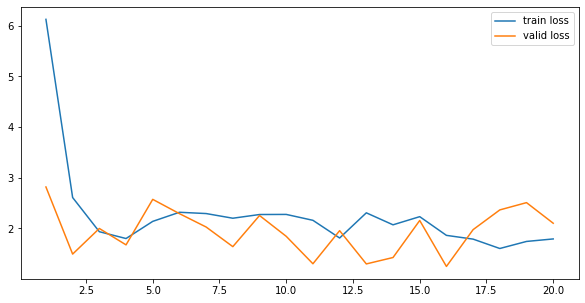

In [10]:
history = model.keras_model.history.history
epochs = range(1, config.EPOCHS + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.show()

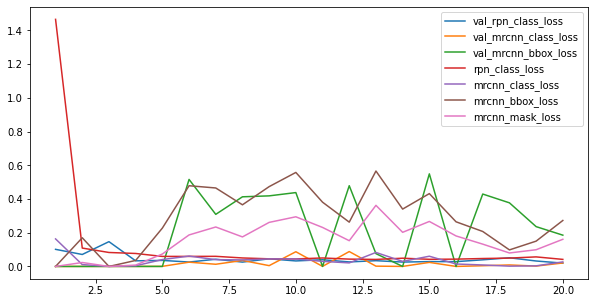

In [19]:
history = model.keras_model.history.history
epochs = range(1, config.EPOCHS + 1)
plt.figure(figsize=(10,5))
#plt.plot(epochs, history['val_loss'], label="valid loss")
plt.plot(epochs, history['val_rpn_class_loss'], label="val_rpn_class_loss")
#plt.plot(epochs, history['val_rpn_bbox_loss'], label="val_rpn_bbox_loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="val_mrcnn_class_loss")
plt.plot(epochs, history['val_mrcnn_bbox_loss'], label="val_mrcnn_bbox_loss")
#plt.plot(epochs, history['val_mrcnn_mask_loss'], label="val_mrcnn_mask_loss")
#plt.plot(epochs, history['loss'], label="loss")
plt.plot(epochs, history['rpn_class_loss'], label="rpn_class_loss")
#plt.plot(epochs, history['rpn_bbox_loss'], label="rpn_bbox_loss")
plt.plot(epochs, history['mrcnn_class_loss'], label="mrcnn_class_loss")
plt.plot(epochs, history['mrcnn_bbox_loss'], label="mrcnn_bbox_loss")
plt.plot(epochs, history['mrcnn_mask_loss'], label="mrcnn_mask_loss")
plt.legend()
plt.show()

In [15]:
history

{'val_loss': [2.8173218965530396,
  1.4922582507133484,
  1.9980790853500365,
  1.674442505836487,
  2.5728445053100586,
  2.2907999992370605,
  2.026926064491272,
  1.6393550515174866,
  2.2538417100906374,
  1.8431158542633057,
  1.3013492465019225,
  1.9546568393707275,
  1.298164176940918,
  1.4246692538261414,
  2.1555988788604736,
  1.2483531832695007,
  1.9751682043075562,
  2.364489662647247,
  2.5082118988037108,
  2.1014114379882813],
 'val_rpn_class_loss': [0.1014690414071083,
  0.07098336555063725,
  0.14703837148845195,
  0.033322017267346384,
  0.035794921591877936,
  0.026150450855493546,
  0.04272837154567242,
  0.0257661709561944,
  0.04528110194951296,
  0.03268857095390558,
  0.03981079161167145,
  0.02677457556128502,
  0.034167378954589364,
  0.025957390666007996,
  0.028748981282114984,
  0.028558395430445672,
  0.039284972846508025,
  0.05147067531943321,
  0.03231751844286919,
  0.019790316745638848],
 'val_rpn_bbox_loss': [2.715814709663391,
  1.421111917495727

In [9]:
class InferenceConfig(SteelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [30]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
COCO_MODEL_PATH = r"C:\Users\HPDQ\Mask_RCNN\logs\steel20211014T2004\mask_rcnn_steel_0011.h5"

In [31]:
class InferenceConfig(SteelConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = r"C:\Users\HPDQ\Mask_RCNN\logs\steel20211014T2004\mask_rcnn_steel_0011.h5"
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\HPDQ\Mask_RCNN\logs\steel20211014T2004\mask_rcnn_steel_0011.h5
Re-starting from epoch 11


In [32]:
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

390
584
211
1051
126
1331
820
1083
1224
108
mAP:  0.03066666752099991


589
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max: 1600.00000  float64
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (1, 4)                min:  385.00000  max:  602.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


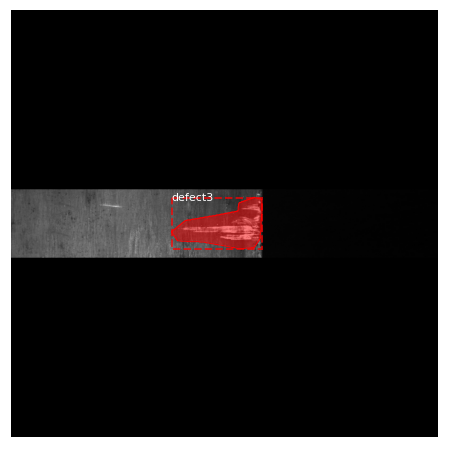

In [33]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [19]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


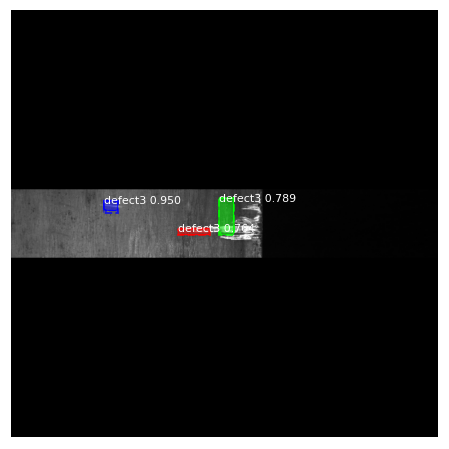

In [34]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())